# Purpose of Study

In recent months, our local volunteer ambulance service had reached a point of failure. Given that monthly call volume and responses to emergencies were at an all-time low, action needed to be taken to prevent further poor performance. In this study, the Yearly, Monthly, Daily and Hourly Call volumes were calculated. Using this information, trends, patterns and relationships for all types of call volume were identified to better understand the operational statistics of all calls and general performance over time. A solution to restore call volume has recently been implemented and its performance has been quantified as well. Forecasting and Modeling were performed on Phone Demand - the main source of demand for the ambulance service in order to predict the likelihood of an emergency call occurring on any day of the week at a given time. Using this information, operations and staffing were proactively altered yielding a resurgence in call volume. The conclusion of this study has provided the daily primary and secondary waves of demand as well as the optimal windows of demand. Having access to such a detailed breakdown of call volume has given our organization an opportunity to restructure ambulance crew shifts to more efficiently respond to emergencies within the community it serves.    

# Import Relevant Packages for Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patheffects as mpe
from matplotlib.lines import Line2D
from pandas.plotting import register_matplotlib_converters
import tensorflow as tf
%matplotlib inline
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.stats import pearsonr
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from datetime import datetime
from datetime import timedelta as td
import datetime
import calendar
import logging
import copy

Using TensorFlow backend.


# Create a DataFrame for the main Dataset

In [2]:
# Read CSV data file as a Pandas Data Frame
df = pd.read_csv(r"C:\Users\John\Desktop\Call_Data_Master_2020.csv") 
# Pandas Data Frame: Data containing daily operations of a volunteer ambulance service (JAN 2017 - DEC 2020) 

# (Over 2,300 phone calls and radio activity) 
# (All demand and activity is based on date, time of event, month and day of week)

# DataFrame selection criteria:
# If the '1000 Line' column is marked 'Yes' the call was Phone Demand 
# If the '1000 Line' column is marked 'No' the call was Radio Activity 

df = df.dropna(how='all', axis='columns') # Drop any empty columns
print(df.columns) # Display column categories

Index(['Date', 'PCR Number', 'DOB', 'Sex', 'Total Mileage', 'Call Location',
       'Call Received', 'Enroute', 'At Scene', 'From Scene', 'At Destination',
       'In Service', 'In Quarters', 'Disposition', '1000 Line'],
      dtype='object')


# Data Pre-Processing - Establishing Datetime Format

In [3]:
# Append a Data Frame 'Datetime' colmn using the corresponding dates and times from the current Data Frame
df['Datetime'] = df['Date'] + ' ' + df['Call Received'] + ":00"

# Assign a new Data Frame column 'Day', arbitrarily call an exisiting column to fill in the dimensions of the DataFrame
df['Day'] = df['Date']

for i in range(len(df)):
    # Iterate through the 'Datetime' Data Frame column and convert it to a Time Series Object 
    df['Datetime'][i] = pd.Timestamp(df['Datetime'][i])
    
    # Iterate through Data Frame 'Column' and return the day of the week into the appended Data Frame column 'Day'  
    a = df['Date'][i].split('/')  # Split the 'Date' into three parts
    date = a[1] + ' ' + a[0] + ' ' + a[2]  # Concatenate the day, month and year into a string
    date_index = datetime.datetime.strptime(date, '%d %m %Y').weekday()  # Convert the dates into date indicies 
    df['Day'][i] = calendar.day_name[date_index]  # Pass through the calendar function and return the day of the week   

# Establish the Data Frame index in terms of a Time Series and sort the Data Frame to yield entries in chronological order 
df.index = df['Datetime']
df = df.sort_index()

# Append the columns 'Hour', 'Month', and 'Year' to the original DataFrame
df['Hour'] = df['Datetime'].dt.hour  # Extract the hour from column 'Datetime' and assign it to column 'Hour'
df['Month'] = df['Datetime'].dt.month  # Extract the month from column 'Datetime' and assign it to column 'Month'
df['Month Name'] = df['Datetime'].dt.strftime('%b') # Extract the month name from column 'Datetime' 
df['Year'] = df['Datetime'].dt.year  # Extract the year from column 'Datetime' and assign it to column 'Year'

# Disregard DataFrame copy errors 

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
df

Date PCR Number         DOB     Sex  Total Mileage  \
Datetime                                                                        
2017-01-01 06:44:00    1/1/2017  5-4330346   1/28/1932  Female            8.0   
2017-01-02 03:59:00    1/2/2017  5-4330353   11/6/1944    Male            0.0   
2017-01-02 05:34:00    1/2/2017  5-4330348   1/26/1932  Female            9.0   
2017-01-02 11:25:00    1/2/2017  5-4330104    3/4/1927  Female            4.0   
2017-01-02 23:35:00    1/2/2017  5-4330347   9/13/1935  Female            5.0   
...                         ...        ...         ...     ...            ...   
2020-12-30 10:58:00  12/30/2020  5-3999780    1/3/1938  Female            0.0   
2020-12-30 13:57:00  12/30/2020  5-3999781         NaN     NaN            0.0   
2020-12-30 16:20:00  12/30/2020  5-3999783    8/8/1985  Female            0.0   
2020-12-30 16:20:00  12/30/2020  5-3999782  12/30/1976  Female            0.0   
2020-12-30 18:45:00  12/30/2020  5-3999784   7/18/1994  Female            3.0   

                    Call Location Call Received Enroute At Scene From Scene  \
Datetime                                                                      
2017-01-01 06:44:00     Residence          6:44    6:46     7:51       8:07   
2017-01-02 03:59:00     Residence          3:59    4:08     4:16        NaN   
2017-01-02 05:34:00     Residence          5:34    5:40     5:43       5:58   
2017-01-02 11:25:00     Residence         11:25   11:28    11:30      11:36   
2017-01-02 23:35:00     Residence         23:35   23:40    23:43      23:53   
...                           ...           ...     ...      ...        ...   
2020-12-30 10:58:00     Residence         10:58   10:59    11:02        NaN   
2020-12-30 13:57:00     Residence         13:57   13:58    14:01        NaN   
2020-12-30 16:20:00          Road         16:20   16:21    16:27        NaN   
2020-12-30 16:20:00          Road         16:20   16:21    16:27        NaN   
2020-12-30 18:45:00          Road         18:45   18:46    18:56      19:12   

                     ... In Service In Quarters           Disposition  \
Datetime             ...                                                
2017-01-01 06:44:00  ...       8:30        8:46  Northshore Manhasset   
2017-01-02 03:59:00  ...       4:29        4:39                   RMA   
2017-01-02 05:34:00  ...       6:33        7:06  Northshore Manhasset   
2017-01-02 11:25:00  ...      12:21       12:54                  NYPQ   
2017-01-02 23:35:00  ...       0:30        0:48                  NYPQ   
...                  ...        ...         ...                   ...   
2020-12-30 10:58:00  ...      11:21       12:02                   RMT   
2020-12-30 13:57:00  ...      14:06       14:36      No Patient Found   
2020-12-30 16:20:00  ...      16:50       17:00                   RMT   
2020-12-30 16:20:00  ...      16:50       17:00                   RMT   
2020-12-30 18:45:00  ...      19:50       20:15     Flushing Hospital   

                    1000 Line             Datetime        Day Hour  Month  \
Datetime                                                                    
2017-01-01 06:44:00       Yes  2017-01-01 06:44:00     Sunday    6      1   
2017-01-02 03:59:00       Yes  2017-01-02 03:59:00     Monday    3      1   
2017-01-02 05:34:00       Yes  2017-01-02 05:34:00     Monday    5      1   
2017-01-02 11:25:00       Yes  2017-01-02 11:25:00     Monday   11      1   
2017-01-02 23:35:00       Yes  2017-01-02 23:35:00     Monday   23      1   
...                       ...                  ...        ...  ...    ...   
2020-12-30 10:58:00        No  2020-12-30 10:58:00  Wednesday   10     12   
2020-12-30 13:57:00        No  2020-12-30 13:57:00  Wednesday   13     12   
2020-12-30 16:20:00        No  2020-12-30 16:20:00  Wednesday   16     12   
2020-12-30 16:20:00        No  2020-12-30 16:20:00  Wednesday   16     12   
2020-12-30 18:45:00        No  2020-12-30 18:45:00  Wednesday   18     

# Divide DataFrame into Four Datasets:

In [5]:
# Get all of the years from the dataset
year_range_all = df['Year'].unique()

# Get each unique month from the dataset 
month_labels = df['Month Name'].unique()
month_labels = [x.upper() for x in month_labels] 

# Total Phone Demand - All phone calls made to ambulance station
df_Phone = df[df['1000 Line'] == 'Yes'] #Criteria for selecting Total Phone Demand 

# Met Phone Demand - Phone calls the ambulance responded to
df_Phone_Met = df[(df['1000 Line'] == 'Yes') & (df['Disposition'] != 'Unmet Demand')] # Conditions for Met Phone Demand

# Unmet Phone Demand - Phone calls the ambulance did not respond to 
df_Phone_Unmet = df[(df['1000 Line'] == 'Yes') & (df['Disposition'] == 'Unmet Demand')] # Conditions for Unmet Phone Demand

# Radio Activity - Optional calls the ambulance responded to through the 911 network
df_Radio = df[df['1000 Line'] == 'No']  # Conditions for Radio Activity

# Resample each entire DataFrame by month and count the monthly call volume
Phone_Total = df_Phone['Call Received'].resample('M').count()
Phone_Met = df_Phone_Met['Call Received'].resample('M').count()
Phone_Unmet = df_Phone_Unmet['Call Received'].resample('M').count() 
Radio = df_Radio['Call Received'].resample('M').count()

# If unmet phone data has zero calls for the first month add a zero
if len(Phone_Unmet) < len(Phone_Met):
    Phone_Unmet = np.pad(Phone_Unmet, (1,0), 'constant')
    # Add extra zeros if the most recent months have no unmet demand
    diff = abs(len(Phone_Unmet) - len(Phone_Met))
    Phone_Unmet = np.pad(Phone_Unmet, (0,diff), 'constant') 

# Monthly call data - stored to calculate the yearly call totals
call_data = [Phone_Met,Phone_Unmet,Radio]

# Create a datetime plotting index
dt_index = df['Call Received'].resample('M').count().index

# Get an array of just years for which an event occurred for any type of demand or activity
Phone_year = np.array(df_Phone.index.year)
Phone_Met_year = np.array(df_Phone_Met.index.year)
Radio_year = np.array(df_Radio.index.year)

# Convert the respective Data Frame 'Day' columns to lists for any type of demand or activity
Day_Of_Week_Phone = df_Phone['Day'].astype(str).values.tolist()
Day_Of_Week_Phone_Met = df_Phone_Met['Day'].astype(str).values.tolist()
Day_Of_Week_Radio = df_Radio['Day'].astype(str).values.tolist()

# List of the days of the week - Not listed in order from DataFrame so manually entered list is needed
DOW = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# Function to duplicate the entries in a list n times
def duplicate(testList,n):
    return testList*n

# Function to return all possible pairs of an input
def pairs(input):
    result = []
    for p1 in range(len(input)):
            for p2 in range(p1+1,len(input)):
                    result.append([input[p1],input[p2]])
    return result

# Function to return a decimal as a time 
def dec2time(input):
    Hours = input
    Minutes = 60 * (Hours % 1)

    return str("%d:%02d" % (Hours, Minutes))

# Declare Yearly and Monthly Call Volume Variables

In [6]:
# Save the monthly and yearly totals for each type of demand or activity 
year_labels = [] # Store each year as a literal text string

call_data_yearly = [None]*len(year_range_all) # Store the monthly call data by year for each type of demand or activity 
call_volume_yearly = [None]*len(year_range_all) # Store the yearly call volume for each type of demand or activity 

Phone_Total_yearly = [None]*len(year_range_all) # Store the monthly Total Phone Demand by year
Phone_Total_volume_yearly = [None]*len(year_range_all) # Store the yearly call volume for Total Phone Demand 

Phone_Met_yearly = [None]*len(year_range_all) # Store the monthly Met Phone Demand by year
Phone_Met_volume_yearly = [None]*len(year_range_all) # Store the yearly call volume for Met Phone Demand

Phone_Unmet_yearly = [None]*len(year_range_all) # Store the monthly Unmet Phone Demand by year
Phone_Unmet_volume_yearly = [None]*len(year_range_all) # Store the yearly call volume for Unmet Phone Demand

Radio_yearly = [None]*len(year_range_all) # Store the monthly Radio Activity by year 
Radio_volume_yearly = [None]*len(year_range_all) # Store the yearly call volume for Radio Activity

Combined_volume_yearly = [None]*len(year_range_all) # Store the combined yearly call volume  

call_volume = [None]*len(call_data) # Store the cumulative call volume for each type of demand or activity 

# Iterate through the loop to populate the variables. Each variable will have a length = len(year_range_all)
# Access the data of each year by index. i.e. 0 --> 2017, 1 --> 2018, 2 --> 2019, 3 --> 2020
for i in range(len(year_range_all)):
    year_labels.append(str(year_range_all[i]))
    
    call_data_yearly[i] = [Phone_Met[(i*12):(i*12)+12],Phone_Unmet[(i*12):(i*12)+12],Radio[(i*12):(i*12)+12]]
    call_volume_yearly[i] = [sum(Phone_Met[(i*12):(i*12)+12]),sum(Phone_Unmet[(i*12):(i*12)+12]),sum(Radio[(i*12):(i*12)+12])]
        
    Phone_Total_yearly[i] = Phone_Total[(i*12):(i*12)+12]
    Phone_Total_volume_yearly[i] = sum(Phone_Total[(i*12):(i*12)+12])
        
    Phone_Met_yearly[i] = Phone_Met[(i*12):(i*12)+12]
    Phone_Met_volume_yearly[i] = sum(Phone_Met[(i*12):(i*12)+12])
        
    Phone_Unmet_yearly[i] = Phone_Unmet[(i*12):(i*12)+12]
    Phone_Unmet_volume_yearly[i] = sum(Phone_Unmet[(i*12):(i*12)+12])
        
    Radio_yearly[i] = Radio[(i*12):(i*12)+12]
    Radio_volume_yearly[i] = sum(Radio[(i*12):(i*12)+12])
    
    Combined_volume_yearly[i] = sum(Radio[(i*12):(i*12)+12])+sum(Phone_Met[(i*12):(i*12)+12])
    
for j in range(len(call_data)):
    call_volume[j] = sum(call_data[j])

# Monthly Call Volume

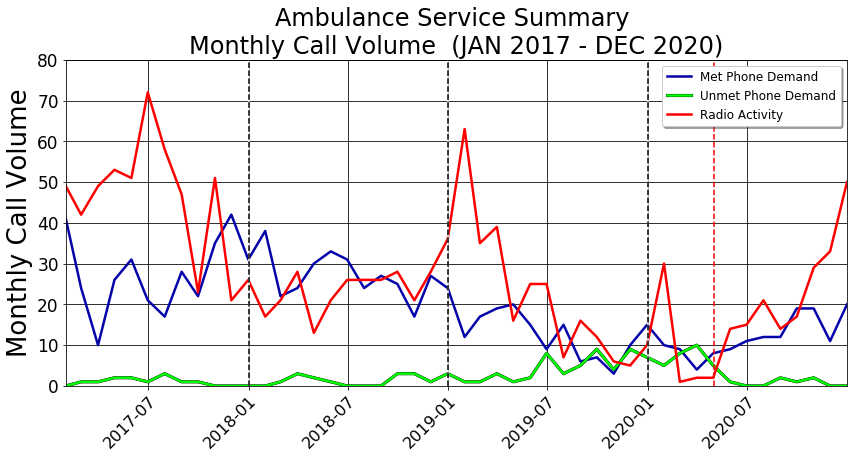

In [7]:
# Create a plot summarizing the monthly ambulance service call volume over the year range
fig, ax = plt.subplots(figsize=(14,6)) 

register_matplotlib_converters() # Register matplotlib converters

outline = mpe.withStroke(linewidth=3.1, foreground='black') # Create a border for line plots

# Plot Met Phone Demand, Unmet Phone Demand and Radio Activity on the same axis
ax.plot(dt_index, Phone_Met, color='#0504aa', lw=2.5, label='Met Phone Demand')
ax.plot(dt_index, Phone_Unmet, color = 'lime', lw=2.5, path_effects=[outline], label='Unmet Phone Demand')
ax.plot(dt_index, Radio, color='red', lw=2.5, label='Radio Activity')

# Label and format plot
ax.set_title('Ambulance Service Summary \n'+'Monthly Call Volume '+' '+'('+str.upper(df['Month Name'][0])+' '
             +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
             +str(year_range_all[-1])+')', fontsize=24)
ax.set_ylabel('Monthly Call Volume', fontsize=26)
ax.margins(x=0) # Removes gaps on the x-axis
ax.margins(y=0) # Removes gaps on the y-axis
ax.grid(True, color='k')
ax.legend(prop={'size': 12}, loc=1, shadow=True)
    
plt.xticks(rotation=45, fontsize=16, ha='right', rotation_mode='anchor') # x-axis formatting
plt.yticks(fontsize=17) # y-axis formatting

x_numbers = ax.get_yticks()
plt.ylim([0,x_numbers[-1]]) # y-axis upper and lower bounds

# Add red dashed line to signify the turning point in operations after solution is implemented 
plt.axvline('2020-05-01T01:00:00.000000000', color='r', linewidth=1.5, linestyle='--')

# Add dashed vertical lines to see the transition between years
for l in range(len(year_range_all[1:])):
    plt.axvline(x=str(year_range_all[l+1])+'-01-01T01:00:00.000000000', color='w', linewidth=1.5, linestyle='-')
    plt.axvline(x=str(year_range_all[l+1])+'-01-01T01:00:00.000000000', color='k', linewidth=1.5, linestyle='--')

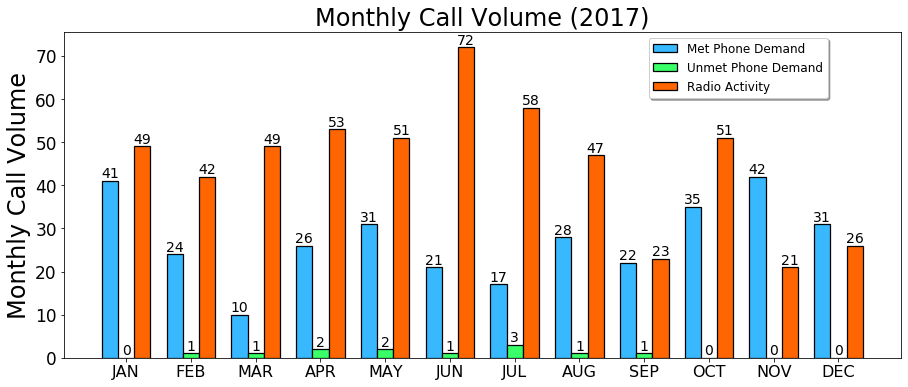

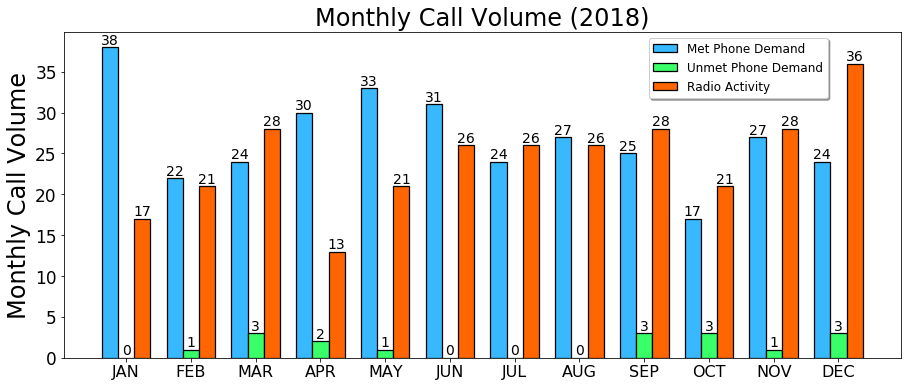

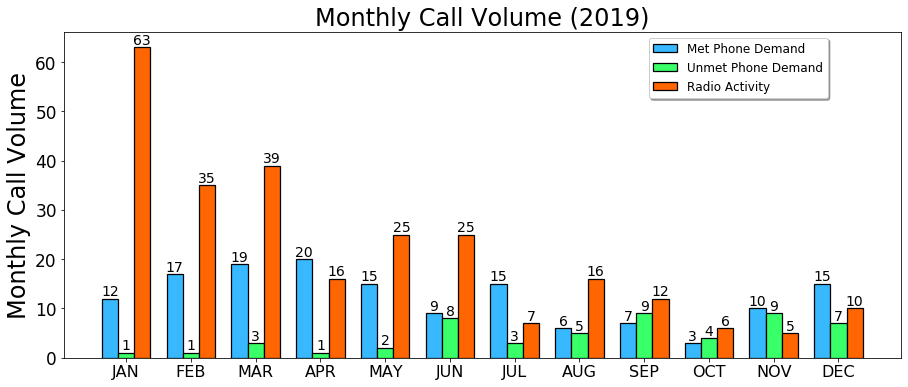

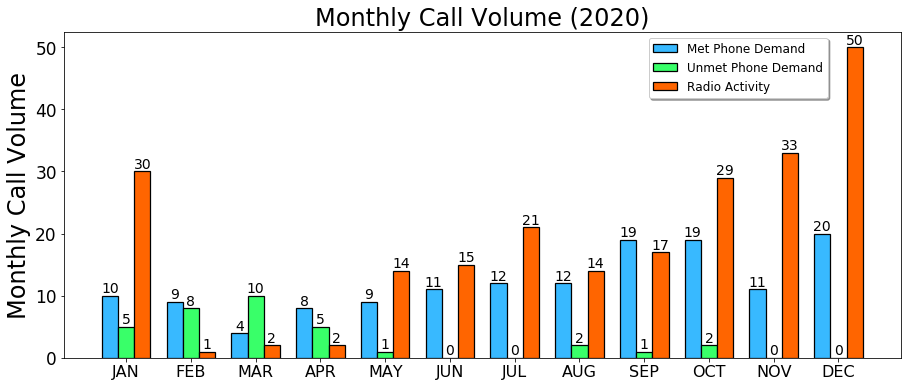

In [8]:
# Create a Bar Graphs displaying the monthly call volume of each category by year
for i in range(len(year_range_all)):
    fig, ax = plt.subplots(figsize=(15,6))

    # Establish the position and relative spacing of the data 
    index = np.arange(len(month_labels))
    bar_width = 0.25

    # Plot Bar Graphs for Met Phone Demand, Unmet Phone Demand and Radio Activity on the same axis
    rects1 = plt.bar(index - bar_width, Phone_Met.iloc[(i*12):(i*12)+12], bar_width, color='#38b9ff', edgecolor='k', 
                     linewidth='1.25', label='Met Phone Demand')
    rects2 = plt.bar(index, Phone_Unmet[(i*12):(i*12)+12], bar_width, color='#39ff69', edgecolor='k', linewidth='1.25', 
                     label='Unmet Phone Demand')
    rects3 = plt.bar(index + bar_width, Radio.iloc[(i*12):(i*12)+12], bar_width, color='#ff6500', edgecolor='k', 
                     linewidth='1.25', label='Radio Activity')

    rects = [rects1,rects2,rects3]
    data_temp = [Phone_Met.iloc[(i*12):(i*12)+12], Phone_Unmet[(i*12):(i*12)+12], Radio.iloc[(i*12):(i*12)+12]]

    # Label the top of each bar with the monthly call volume
    for j in range(len(rects)):    
        for rects[j], label in zip(rects[j], (data_temp[j])):
            height = rects[j].get_height()
            ax.text(rects[j].get_x() + rects[j].get_width()/2, height, label, ha='center', va='bottom', size=14)

    # Label and format plot        
    ax.set_title('Monthly Call Volume'+' '+'('+year_labels[i]+')', fontsize=24)
    plt.xticks(index, month_labels, fontsize=16) # x-axis formatting
    plt.yticks(fontsize=17) # y-axis formatting
    plt.ylabel('Monthly Call Volume', fontsize=24)
    plt.legend(prop={'size': 12}, shadow=True, loc=1, bbox_to_anchor=(0.92,1))
plt.show()

## Monthly Call Volume for all types of Demand and Activity can be visualized over time

Phone demand is the driving force of the ambulance service. 
    
    • It is the primary source of demand because these are emergency calls made directly to the ambulance station. 

Radio Activity are optional calls that the crew can complete through the 911 network.
    
    • Radio activity can be completed when a crew is available to handle phone demand.  
      
In **2017** and **2018**, majority of the Phone Demand was met. 

From **SEP 2018 - DEC 2018** there is a noticeable increase in monthly unmet calls (Approx 2-3 calls missed per month). The change is not too alarming however because Met Phone Demand consists of 23 calls per month on average.

From **JAN 2019 - MAY 2019** the trend of Unmet Phone Demand remains constant (Approx 2-3 calls missed per month). As the Unmet Phone Demand continues at this rate, the Met Phone Demand decreases during this window. Met Phone demand drops to about 17 calls per month on average for this <br> time-period.

From **JUN 2019 - MAY 2020** there is a rapid increase in Unmet Phone Demand and Met Phone Demand drops significantly. For the first time in service history Unmet Phone Demand exceeds Met Phone Demand (**SEP 2019, OCT 2019 and MAR 2020**). For the first time in service history monthly call volume hits an <br> all-time low of 3 met calls in a month (**OCT 2019**). 

In **APR 2020**, a third party ambulance service was added to help handle Unmet Phone Demand. By **MAY 2020** Unmet Phone Demand has almost returned to zero. First increase in Radio Activity since **JAN 2020**. Relative performance stabilized almost to what is was a year ago in **MAY 2019**.

Between **MAY 2020** and **OCT 2020** substantial improvements to call volume have been observed. Met Phone demand is currently 
comparable to early **2019** totals at approximately 20 calls per month. Unmet Phone demand has been curtailed significantly and has not exceeded more than 2 missed calls in a month since the operational changes were implemented. For the first time in **2020** has there been a month with no missed demand. Radio Activity is back to performing as well as it had post-COVID and in **2019**.

Between **NOV 2020** and **DEC 2020** Radio activity has been the greatest it ever has been all year. December saw 50 responses to Radio emergencies, the highest total since **JAN 2019**. For two consecutive months in a row, all Phone Demand was met.

The overall performance for the last quarter of **2020** was better than it was a year ago.

    • Continuing this recovery into 2021, call volume is anticipated to reach levels seen in 2017 and 2018.

    • Monthly Call Volume is not seasonal but contingent upon public presence of the ambulance
    responding to Phone Demand and Radio Activity. As Phone Demand goes Unmet for too long of 
    a period monthly call volume drops. If Phone demand is almost entirely met and Radio Activity response is high, 
    Total Phone Demand Call Volume rises.

## Pairwise comparison of Input Features as a function of Monthly Call Volume 

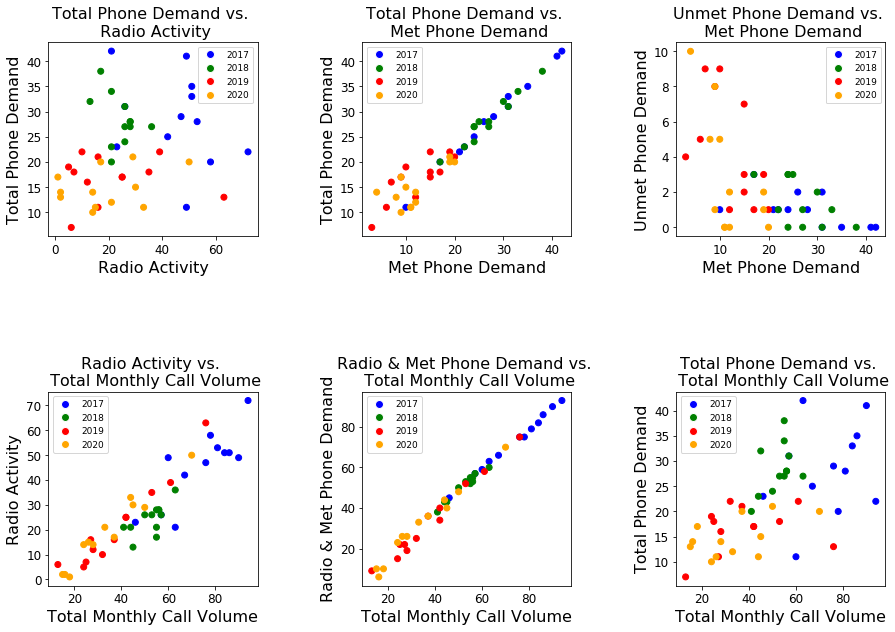

In [9]:
# Establish subplot parameters 
row = np.arange(3)
col = np.arange(4)

# Create a subplot displaying scatter plots of select pairs of data
fig, ax = plt.subplots(row[-1],col[-1], figsize=(15,10), gridspec_kw = {'wspace':0.5, 'hspace':0.8})

classes = np.repeat(np.arange(len(year_range_all)),12) # Create a list of year lables
colormap = np.array(['blue', 'green', 'red', 'orange']) # Create a list of colors 

# If last list is short, adjust the length of the class list
if 12 - len(Phone_Met_yearly[-1]) > 0:
    classes = classes[:len(classes)-(12-len(Phone_Met_yearly[-1]))]
    
legend_elements = []

# Create a legend for the years in the plot with respective colors
for i in range(len(year_range_all)):
    legend_elements.append(Line2D([],[],marker='o', color='w', label=year_labels[i],markerfacecolor=colormap[i],markersize=8))

# Total Phone Demand vs. Radio Activity    
scatter1 = ax[0,0].scatter(Radio, Phone_Total, c=colormap[classes])
# Label and format plot
title1 = ax[0,0].set_title('Total Phone Demand vs. \n'+' '+'Radio Activity', fontsize=16)
x1 = ax[0,0].set_xlabel('Radio Activity', fontsize='16')
y1 = ax[0,0].set_ylabel('Total Phone Demand', fontsize='16')
ax[0,0].tick_params(axis='x', labelsize=12)
ax[0,0].tick_params(axis='y', labelsize=12)
legend1 = ax[0,0].legend(handles=legend_elements, loc=1, prop={'size': 9})

# Total Phone Demand vs. Met Phone Demand
ax[0,1].scatter(Phone_Met, Phone_Total, c=colormap[classes])  

# Label and format plot
title2 = ax[0,1].set_title('Total Phone Demand vs. \n'+' '+'Met Phone Demand', fontsize=16)
x2 = ax[0,1].set_xlabel('Met Phone Demand', fontsize='16')
y2 = ax[0,1].set_ylabel('Total Phone Demand', fontsize='16')
ax[0,1].tick_params(axis='x', labelsize=12)
ax[0,1].tick_params(axis='y', labelsize=12)
legend2 = ax[0,1].legend(handles=legend_elements, prop={'size': 9})

# Unmet Phone Demand vs. Met Phone Demand
ax[0,2].scatter(Phone_Met, Phone_Unmet, c=colormap[classes]) 

# Label and format plot
title3 = ax[0,2].set_title('Unmet Phone Demand vs. \n'+' '+'Met Phone Demand', fontsize=16)
x3 = ax[0,2].set_xlabel('Met Phone Demand', fontsize='16')
y3 = ax[0,2].set_ylabel('Unmet Phone Demand', fontsize='16')
ax[0,2].tick_params(axis='x', labelsize=12)
ax[0,2].tick_params(axis='y', labelsize=12)
legend3 = ax[0,2].legend(handles=legend_elements, prop={'size': 9})

# Radio Activity vs. Total Monthly Call Volume
ax[1,0].scatter(Phone_Total+Radio, Radio, c=colormap[classes]) 

# Label and format plot
title4 = ax[1,0].set_title('Radio Activity vs. \n'+' '+'Total Monthly Call Volume', fontsize=16)
x4 = ax[1,0].set_xlabel('Total Monthly Call Volume', fontsize='16')
y4 = ax[1,0].set_ylabel('Radio Activity', fontsize='16')
ax[1,0].tick_params(axis='x', labelsize=12)
ax[1,0].tick_params(axis='y', labelsize=12)
legend4 = ax[1,0].legend(handles=legend_elements, prop={'size': 9})

# Radio & Met Phone Demand vs. Total Monthly Call Volume
ax[1,1].scatter(Phone_Total+Radio, Phone_Met+Radio, c=colormap[classes])  

# Label and format plot
title5 = ax[1,1].set_title('Radio & Met Phone Demand vs. \n'+' '+'Total Monthly Call Volume', fontsize=16)
x5 = ax[1,1].set_xlabel('Total Monthly Call Volume', fontsize='16')
y5 = ax[1,1].set_ylabel('Radio & Met Phone Demand', fontsize='16')
ax[1,1].tick_params(axis='x', labelsize=12)
ax[1,1].tick_params(axis='y', labelsize=12)
legend5 = ax[1,1].legend(handles=legend_elements, prop={'size': 9})

# Total Phone Demand vs. Total Monthly Call Volume
ax[1,2].scatter(Phone_Total+Radio, Phone_Total, c=colormap[classes])   

# Label and format plot
title6 = ax[1,2].set_title('Total Phone Demand vs. \n'+' '+'Total Monthly Call Volume', fontsize=16)
x6 = ax[1,2].set_xlabel('Total Monthly Call Volume', fontsize='16')
y6 = ax[1,2].set_ylabel('Total Phone Demand', fontsize='16')
ax[1,2].tick_params(axis='x', labelsize=12)
ax[1,2].tick_params(axis='y', labelsize=12)
legend6 = ax[1,2].legend(handles=legend_elements, prop={'size': 9})

In [10]:
data = [] # Empty variable to store the scatter plot data

for i in range(len(row)-1):
    for j in range(len(col)-1):
        d = ax[i,j].collections[0] # Store the data as a matplotlib collection
        d.set_offset_position('data') # Extract the data as a masked array 
        data_temp = np.array(d.get_offsets()) # Convert the data to a temporary array
        #print(data_temp)
        data.append(data_temp) # Append and save the data to a nested array 
        
# Empty statistical metrics arrays 
Pearson = []
Spearman = []
T_Test = []

stats_data = {} # Empty dictionary to store the statistical data for each figure 
table_data = [] # Empty array to append data to for a dataframe

for i in range(len(data)):    
    temp = data[i].T # Reshape the data 
   
    # Separate out the data 
    x = temp[0] 
    y = temp[1]
    
    Pearson.append(pearsonr(x,y))
    Spearman.append(stats.spearmanr(x,y))
    T_Test.append(stats.ttest_ind(x,y))

    stats_data[i] = ['{:0.3f}'.format(Pearson[i][0]),'{:0.3f}'.format(Spearman[i][0]),'{:0.3f}'.format(T_Test[i][0]),
                     '{:0.3f}'.format(T_Test[i][1])]
    table_data.append(stats_data[i]) # Append the data in a format for a dataframe 
    
# Vertical Labels 
xlabels = ['Total Phone Demand vs.'+' '+'Radio Activity', 
          'Total Phone Demand vs.'+' '+'Met Phone Demand', 
          'Unmet Phone Demand vs.'+' '+'Met Phone Demand', 
          'Radio Activity vs.'+' '+'Total Monthly Call Volume',
          'Radio & Met Phone Demand vs.'+' '+'Total Monthly Call Volume',
          'Total Phone Demand vs.'+' '+'Total Monthly Call Volume'] 

# Horizontal Labels 
ylabels = ['Pearson','Spearman','T-Statistic','p-value']

# Create dataframe
stats_df = pd.DataFrame(table_data, xlabels, ylabels)  

In [11]:
print('Correlation and T-test (α = 0.05) Results:')
stats_df

Correlation and T-test (α = 0.05) Results:


Pearson Spearman  \
Total Phone Demand vs. Radio Activity                0.266    0.339   
Total Phone Demand vs. Met Phone Demand              0.966    0.953   
Unmet Phone Demand vs. Met Phone Demand             -0.593   -0.587   
Radio Activity vs. Total Monthly Call Volume         0.920    0.906   
Radio & Met Phone Demand vs. Total Monthly Call...   0.995    0.993   
Total Phone Demand vs. Total Monthly Call Volume     0.622    0.655   

                                                   T-Statistic p-value  
Total Phone Demand vs. Radio Activity                    1.984   0.050  
Total Phone Demand vs. Met Phone Demand                 -1.284   0.202  
Unmet Phone Demand vs. Met Phone Demand                 11.652   0.000  
Radio Activity vs. Total Monthly Call Volume             5.648   0.000  
Radio & Met Phone Demand vs. Total Monthly Call...       0.544   0.588  
Total Phone Demand vs. Total Monthly Call Volume         8.409   0.000

# Phone Demand and Radio Activity are independent features 

For all T-tests: Alpha = 0.05 <br>

**Total Phone Demand vs. Radio Activity** - Comparison of all Phone Demand (Met and Unmet) against Radio Activity <br>

• No evidence of correlation exists between these two variables. Any lead to a positively linear relation is offset by the outliers of high radio activity. <br>
• These input features are separate entities of activity. <br>
• The difference in the means and variances between the two variables is not extreme enough to be more significant than just variability within the data. <br> 
• A clear relationship is not defined at instantaneous points of time.

****

**Total Phone Demand vs. Met Phone Demand** - Comparison of all Phone Demand (Met and Unmet) against Met Phone Demand <br>

• Total Phone Demand and Met Phone Demand are strongly linearly related and positively correlated. <br>
• As the call volume increases the 1:1 relation between the variables is more apparent suggesting the majority of the phone demand met during the most <br> active months. <br> 
• At the bottom of the curve, the data has a larger spread suggesting that a failure to meet demand and a decrease in call volume are related. <br> 
• The difference in the means and variances between the two variables is not extreme enough to be more significant than just variability within the data. 

****

**Unmet Phone Demand vs. Met Phone Demand** - Comparison of Phone Demand that was Met and Unmet <br>	

• Unmet and Met Phone demand share a moderate inversely-linear relation and negative correlation. <br>
• The scatter plot between these two features suggests that when 35 or more calls are met no demand will go unmet. <br> 
• Ideally there would be a clearly defined inverse relationship between the two variables. Instead a notably large spread in the data exists.   
• Upon visualizing the plot, two distinct clusters exist. The first group on the upper LHS consists of months where 4 or more calls were missed while the group on the RHS contains months of 3 or less missed calls. <br> 
• Future work can be done with KNN or K-means clustering classify and predict good and poor performing months based on this separation. <br> 

****

**Radio Activity vs. Total Monthly Call Volume** - Compare Radio Activity to all Calls <br>

• Radio Activity and Total Monthly Call Volume are strongly linearly related and positively correlated. <br> 
• The observed differences between the two variables is extreme enough to not have been from just variability in the data. <br>

****

**Radio & Met Phone Demand vs. Total Monthly Call Volume** - Compare completed calls to all Calls 	

• Radio & Met Phone Demand and Total Monthly Call Volume are strongly linearly related and positively correlated. <br> 
• The difference in the means and variances between the two variables is not extreme enough to be more significant than just variability within the data. <br>
• The absence of Unmet Phone Demand is not significant. <br> 
• To include both Radio & Met Phone Demand and Total Monthly Call Volume in a model would be redundant.

****

**Total Phone Demand vs. Total Monthly Call Volume** - Compare all Phone Demand (Met and Unmet) to all Calls <br>

• Total Phone Demand and Total Monthly Call Volume share a moderate inversely-linear relation and negative correlation. <br>
• The observed differences between the two variables is extreme enough to not have been from just variability in the data. <br>
• The absence of radio activity from Total Monthly Call Volume is significant. <br> 
• The scatter plot bares a similar resemblance to the Total Phone Demand vs. Radio Activity. This further proves the behavior of Phone Demand and Radio Activity are variables of importance.  

# Yearly Call Volume 

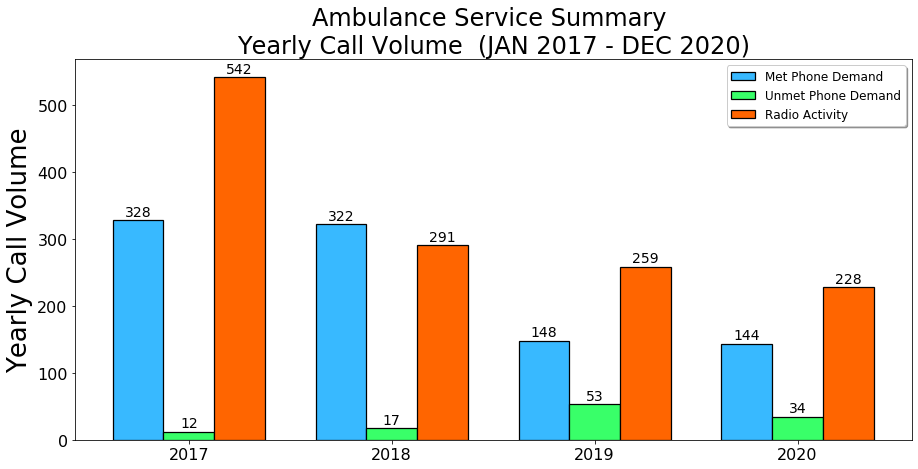

In [12]:
# Create a plot displaying the Yearly Call Volume for each type of demand or activity 
fig, ax = plt.subplots(figsize=(15,7))

# Establish the position and relative spacing of the data 
index = np.arange(len(year_range_all))
bar_width = 0.25

# Plot Bar Graphs for Met Phone Demand, Unmet Phone Demand and Radio Activity on the same axis
rects1 = plt.bar(index - bar_width, Phone_Met_volume_yearly, bar_width, color='#38b9ff', edgecolor='k', 
                 linewidth='1.25', label='Met Phone Demand')
rects2 = plt.bar(index, Phone_Unmet_volume_yearly, bar_width, color='#39ff69', edgecolor='k', linewidth='1.25', 
                 label='Unmet Phone Demand')
rects3 = plt.bar(index + bar_width, Radio_volume_yearly, bar_width, color='#ff6500', edgecolor='k', 
                 linewidth='1.25', label='Radio Activity')

rects = [rects1,rects2,rects3]
data_temp = [Phone_Met_volume_yearly, Phone_Unmet_volume_yearly, Radio_volume_yearly]

# Label the top of each bar with the yearly call volume
for i in range(len(rects)):    
    for rects[i], label in zip(rects[i], (data_temp[i])):
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width()/2, height+2, label, ha='center', va='bottom', size=14)

# Label and format plot        
ax.set_title('Ambulance Service Summary \n'+'Yearly Call Volume '+' '+'('+str.upper(df['Month Name'][0])+' '
             +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
             +str(year_range_all[-1])+')', fontsize=24)
plt.xticks(index, year_labels, fontsize=16) # x-axis formatting
plt.yticks(fontsize=16) # y-axis formatting
plt.ylabel('Yearly Call Volume', fontsize=26)
plt.legend(prop={'size': 12}, shadow=True)
plt.show()

## Yearly Call Volumes are quantified for all types Demand or Activity

**2017** - Phone Demand almost entirely met, on average approx. one call per month was missed, Radio Demand at an all time high.
****
**2018** - Phone Demand remains comparable to that of 2017, Unmet Phone Demand remains at a reasonable level. Radio Demand down by almost 50% relative to 2017.
****
**2019** - Phone Demand down by 50% relative to 2018, Unmet Demand has tripled and exceeds the previous two years combined. On average 4 calls per month were missed. Radio Activity dropped by 32 calls but is on a level consistent with 2018.
****
**2020** - Five months have been completed so far and the yearly call volumes for Met Phone Demand and Radio Activity are down. If the current Met Phone Demand and Radio Activity call volumes were tripled projected totals would not reach 2019 levels.

**MAY 2020** <br>
    • Unmet Phone demand is almost as high as 2017 and 2018 combined. To combat further unmet calls a third party ambulance service will be called when crews are not staffed. Moving forward in 2020, the analysis of this data will be used to 
    restore monthly call volumes as seen in 2017 and 2018. <br>
    
   • 28 emergency calls were unmet prior to **MAY 2020**.
    
**OCT 2020** <br> 
    • Met Phone demand call volume expected to meet and or exceed 2019 totals. <br>
    • Between **MAY** and **OCT** only 5 emergency calls were unmet. 

**DEC 2020** <br>
    • Closing out the year, 2020 yielded similar call volume totals to 2019 in all call volume categories  
    • Despite the COVID-19 pandemic, the addition of a 3rd party ambulance in **APR** and new operational orders pertaining to crew scheduling in **OCT**, enabled a recovery for the 2nd half of the year 


# Monthly Call Volume Distribution by Year 

In [13]:
# Create a table that summarizes the pairwise comparisons of Monthly Call Volume by Year 
indicies =  np.arange(4) # Define an array for the number of years to be analyzed 
units = pairs(indicies) # Run the pairwise sorting function

phone_met_ttest = [] # Store the t-test results for met phone demand
phone_unmet_ttest = [] # Store the t-test results for unmet phone demand
radio_ttest = [] # Store the t-test results for radio activity 
year_pairs = {} # Store the pairs of years from the list 'year_range_all'
pair_stats_data = {} # Empty dictionary to store the statistical data for each figure 
pair_table_data = [] # Empty array to append data to for a dataframe
vertical_labels = [] # Empty array for dataframe labels 

for i in range(len(units)):
    phone_met_ttest.append(stats.ttest_ind(Phone_Met_yearly[units[i][0]],Phone_Met_yearly[units[i][1]]))
    phone_unmet_ttest.append(stats.ttest_ind(Phone_Unmet_yearly[units[i][0]],Phone_Unmet_yearly[units[i][1]]))
    radio_ttest.append(stats.ttest_ind(Radio_yearly[units[i][0]],Radio_yearly[units[i][1]]))
    
    year_pairs[i] = year_range_all[units[i]] # Save all possible year combinations as an array 
    
    pair_stats_data[i] = ['{:0.3f}'.format(phone_met_ttest[i][0]),phone_met_ttest[i][1],
                          '{:0.3f}'.format(phone_unmet_ttest[i][0]),phone_unmet_ttest[i][1],
                     '{:0.3f}'.format(radio_ttest[i][0]),radio_ttest[i][1]]
    pair_table_data.append(pair_stats_data[i]) # Append the data in a format for a dataframe
    
    # Vertical Labels 
    vertical_labels.append(str(year_pairs[i][0])+' '+'vs.'+' '+str(year_pairs[i][1]))

# Horizontal Labels 
header = ['Phone Met (T-Statistic)','p-value','Phone Unmet (T-Statistic)','p-value','Radio (T-Statistic)','p-value']

# Create dataframe
pair_stats_df = pd.DataFrame(pair_table_data, vertical_labels, header)

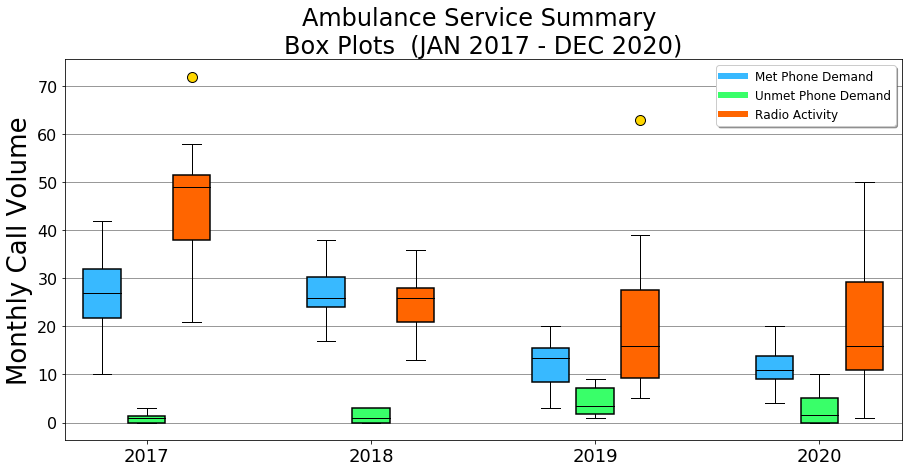

In [14]:
# Create a plot displaying the distribution of the Monthly Call Volume for each type of demand or activity  
fig, ax = plt.subplots(figsize=(15,7))

# Plot properties and colors
flierprops = dict(marker='o', markerfacecolor='gold', markersize=10)
medianprops = dict(color='k')
bar_width = 0.25

# Set x-axis position for the data 
x1 = np.array(range(len(year_range_all)))*3-0.6
x2 = np.array(range(len(year_range_all)))*3
x3 = np.array(range(len(year_range_all)))*3+0.6

# Plot Box Plots for Met Phone Demand, Unmet Phone Demand and Radio Activity on the same axis
box1 = ax.boxplot(Phone_Met_yearly, positions=x1, flierprops=flierprops, medianprops=medianprops, patch_artist=True)
box2 = ax.boxplot(Phone_Unmet_yearly, positions=x2, flierprops=flierprops, medianprops=medianprops, patch_artist=True)
box3 = ax.boxplot(Radio_yearly, positions=x3, flierprops=flierprops, medianprops=medianprops, patch_artist=True)

# Label and format plot
ax.set_title('Ambulance Service Summary \n'+'Box Plots '+' '+'('+str.upper(df['Month Name'][0])+' '
             +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
             +str(year_range_all[-1])+')', fontsize=24)
ax.set_xticklabels(year_labels, fontsize='18')
ax.set_xticks(range(0, len(year_range_all)*3, 3))
ax.set_ylabel('Monthly Call Volume', fontsize='26')
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, axis='y', zorder=1, color='grey')

boxes = [box1,box2,box3]
colors = [['#38b9ff'],['#39ff69'],['#ff6500']]
labels = ['Met Phone Demand','Unmet Phone Demand','Radio Activity']

# Set the color and label each dataset 
for i in range(len(boxes)):
    color_string = duplicate(colors[i],len(year_range_all))
    
    for patch, color in zip(boxes[i]['boxes'],color_string):
        patch.set(color='k', linewidth=1.5)
        patch.set_facecolor(color)
    
    # Draw temporary colored lines and use them to create a legend
    plt.plot([], c=colors[i][0], linewidth=6, label=labels[i])

plt.legend(prop={'size': 12}, shadow=True)
plt.show()

In [15]:
print('Pairwise T-tests (α = 0.05) for each demand category by Year')
pair_stats_df

Pairwise T-tests (α = 0.05) for each demand category by Year


Phone Met (T-Statistic)       p-value Phone Unmet (T-Statistic)  \
2017 vs. 2018                   0.158  8.755443e-01                    -0.890   
2017 vs. 2019                   4.788  8.805994e-05                    -3.630   
2017 vs. 2020                   4.997  5.301374e-05                    -1.795   
2018 vs. 2019                   6.503  1.531855e-06                    -3.073   
2018 vs. 2020                   6.936  5.788279e-07                    -1.344   
2019 vs. 2020                   0.158  8.755990e-01                     1.188   

                p-value Radio (T-Statistic)   p-value  
2017 vs. 2018  0.382975               4.463  0.000195  
2017 vs. 2019  0.001479               3.576  0.001686  
2017 vs. 2020  0.086373               4.315  0.000279  
2018 vs. 2019  0.005570               0.508  0.616693  
2018 vs. 2020  0.192534               1.149  0.262762  
2019 vs. 2020  0.247613               0.397  0.695339

## Show how the spread of data varies by Demand, Activity and Year 

For all T-tests: Alpha = 0.05 <br>

**2017** - Large spread in monthly call volume for Met Phone Demand and Radio Activity.  <br> Most active year of Radio Activity. Radio Activity exceeds Met Phone Demand for most months during the year.  <br> The range of values are symmetric and negatively skewed distributions respectively. 
    
    • Unmet Phone Demand is negatively skewed. Mainly 1 or 2 calls missed per month, one month had 3 missed calls. 
    Four months with no missed called. Excellent Efficiency. 
    
    Max Values: Phone Met 42, Phone Unmet 3, Radio Activity 72  
    Min Values: Phone Met 10, Phone Unmet 0, Radio Activity 21 
    Range: Phone Met 32, Phone Unmet 3, Radio Activity 51

****

**2018** - More consistent year for Met Phone Demand and Radio Activity. Slightly more Met Phone Demand per month than Radio. The range of values are positively and negatively skewed distributions respectively.

    • Met Phone Demand yearly call volume comparable to 2017 but the spread is more contained. 
    Unmet Phone Demand is positively skewed. Mainly 1 or 2 calls missed per month, four months had 3 missed calls. 
    Four months with no missed called. Good Efficiency. 
    
    Max Values: Phone Met 38, Phone Unmet 3, Radio Activity 36
    Min Values: Phone Met 17, Phone Unmet 0, Radio Activity 13
    Range: Phone Met 21, Phone Unmet 3, Radio Activity 23
    
****

**2019** - Radio Activity has a comparable call volume relative to 2018 but is highly inconsistent per month. <br> Jan 2019 there was a strong amount of Radio Activity but the monthly call volume declined by the end of the year. <br> Met Phone Demand is not up to par to the previous two years. Contains most inactive month to date: 3 Met Phone calls.
    
    • The distributions for Radio Activity and Met Phone Demand are positively and negatively skewed respectively. 
    Unmet Phone Demand is positively skewed. Up to 9 calls missed in two separate months. Total of 53 missed calls. 
    Every month has some form of Unmet Phone Demand. Poor Efficiency.

    Max Values: Phone Met 20, Phone Unmet 9, Radio Activity 63
    Min Values: Phone Met 3, Phone Unmet 1, Radio Activity 5
    Range: Phone Met 17, Phone Unmet 8, Radio Activity 58

****

**2020** - **MAY 2020** Radio Activity hits a monthly low. Most inactive month to date with only 1 call completed. <br> Majority of Radio Activity contains less than 15 calls per month. Met Phone Demand is performing poorly. <br> The maximum amount of calls completed in one month is also equal to the minimum calls completed in 2017.
    
    • Radio Activity and Met Phone Demand have positive and negative skews respectively. 
    Unmet Phone Demand is positively skewed. Maximum number of calls turned down in a month at 10.
    Every month has some form of Unmet Phone Demand. Extremely Poor Efficiency. 

    Max Values: Phone Met 10, Phone Unmet 10, Radio Activity 30 
    Min Values: Phone Met 4, Phone Unmet 1, Radio Activity 1 
    Range: Phone Met 6, Phone Unmet 9, Radio Activity 29 
    
    • As more data is added to the model the boxplots will change
    
**OCT 2020** - Radio activity has improved since **MAY**. Most months past this point have seen about 15-20 responses per month. Monthly call volume for Met Phone demand is starting to take a similar distribution to 2019, currently the IQR is smaller than the previous year but the max and min values of the plots are within 1 call of each other respectively.

Radio Activity hits a monthly low. Most inactive month to date with only 1 call completed.
Majority of Radio Activity contains less than 15 calls per month. Met Phone Demand is performing poorly.
The maximum amount of calls completed in one month is also equal to the minimum calls completed in 2017. For the first time in 2020 were there months with no Unmet Phone Demand. From **MAY** to **OCT** Unmet Phone Demand has only increased by 5 calls for the year. 

    • Radio Activity and Met Phone Demand have negatively skewed and symmetric distributions respectively. 
    • Unmet Phone Demand is positively skewed.

    Max Values: Phone Met 19, Phone Unmet 10, Radio Activity 30 
    Min Values: Phone Met 4, Phone Unmet 0, Radio Activity 1  
    Range: Phone Met 15, Phone Unmet 10, Radio Activity 29  
    
**DEC 2020** - The year finished off with **DEC** having the best month of performance. Radio activity and Phone Demand call volumes were at an all-time high for the year.

    Max Values: Phone Met 20, Phone Unmet 10, Radio Activity 50 
    Min Values: Phone Met 4, Phone Unmet 0, Radio Activity 1  
    Range: Phone Met 16, Phone Unmet 10, Radio Activity 49  
    
****

**Note:** The circles indicate any outliers in the data.

## T-Test confirms the observations pertaining to yearly performance

Significant changes in call volume and measures of similarity in performance are quantified with the T-Statistic <br> 
Negative T-Statistic indicates first group is smaller than the second group (result lies to the left side of the hypothesized mean).

****

**Phone Met** 

• Performance in 2017 and 2018 was consistent because nearly identical volume of calls were met. A low T-statistic and p-value > 0.05 caused the null hypothesis to be accepted thus confirming no drastic change in met phone demand call volume. We can infer that both years had similar levels of good performance.   

• 2019 and 2020 suffered in performance relative to either of the two preceding years. Upon observing the four combinations of year pairs every comparison yielded an extreme enough of a result to reject the null hypothesis. This means that 2019 and 2020 faced a drastic decline in met phone demand relative to 2017 and 2018. 

• A pairwise comparison of 2019 and 2020 yielded no statistically significant result suggesting that both years have similar levels of poor performance.

****

**Phone Unmet**

• The same conclusions can be drawn for Unmet Phone demand as stated above for Phone demand. 
There are two exceptions to these results however.

• Referencing the boxplots above, 2018 and 2020 have similar distributions when it comes to the monthly unmet call data. The T-test confirms this by indicating there is no statistically significant difference between the sets of data. 

• Among all of the years of data, 2018 was marginally worse than 2017 (the best performing year) and 2020 was marginally better than 2019 (the worst performing year) to produce this type of result.  

• A pairwise comparison of 2017 and 2020 yielded no statistically significant result suggesting that both years have similar levels of performance.

• **Note:** All pair-wise T-tests that yield statistically significant results and always include 2019 and one of the three other years. 2019 was the only year to have missed calls every month and had the most unmet demand of any year. The T-tests prove the distinct differences in behavior for this call volume category relative to 2017, 2018 and 2020.     

****

**Radio**

• 2017 was the most active year at 542 Radio Activity responses. 2018, 2019 and 2020 all had 50% or less activity for the year. Any comparison to 2017 is statistically significant. High T-statistics and p-values < 0.05 

• 2018 and 2019 had similar Radio Activity totals - moderately active years. This pair of years offers no statistically extreme difference in behavior. 

• 2018 and 2020 had similar totals of Radio Activity. There is no statistically significant difference in the data as shown in the T-test results despite 2020 having a broader distribution of data than 2018.

• 2020 and 2019 have similar totals of Radio Activity. There is no statistically significant difference in the data as shown in the T-test results. The box plot above supplements this because both years exhibit similar distributions of data.

# Aggregate Call Statistics and Charts 

Standard Error for Met Phone Demand: 9.8
Standard Error for Unmet Phone Demand: 2.7
Standard Error for Radio Activity: 16.9


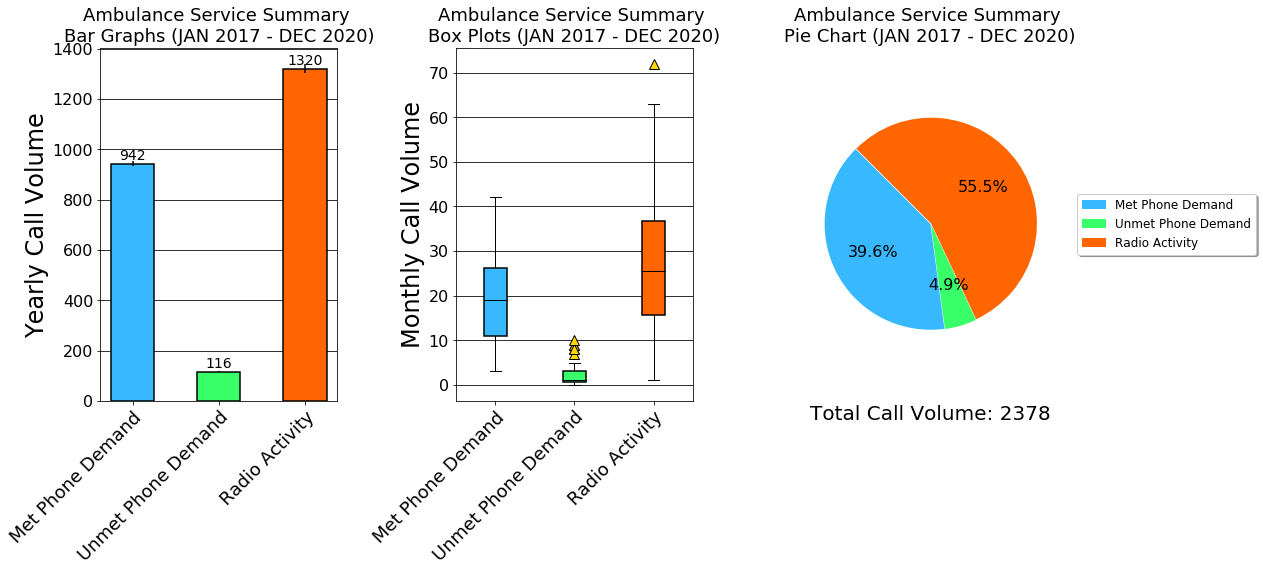

In [16]:
# Create a subplot displaying the cumulative call statistics (Bar Graph, Box Plot and Pie Chart)
fig, ax = plt.subplots(1, len(call_data), figsize=(17,6.5), gridspec_kw={'wspace':0.5, 'hspace':0})
  
labels = ['Met Phone Demand','Unmet Phone Demand','Radio Activity']
colors = ['#38b9ff','#39ff69','#ff6500']

# Plot Bar Graphs for Met Phone Demand, Unmet Phone Demand and Radio Activity on the same axis
for l in range(len(call_data)): 
    err = np.std(call_data[l])
    print('Standard Error for'+' '+str(labels[l])+': '+str("{:0.1f}".format(err)))
    ax[0].bar(x=l, yerr=err, height=call_volume[l], width=0.5, color=colors[l], edgecolor='k', linewidth='1.5', align='center')

# Label and format plot       
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(labels, rotation=45, fontsize='18',ha='right', rotation_mode='anchor')
ax[0].set_ylabel('Yearly Call Volume',fontsize='24')
ax[0].tick_params(axis='y', labelsize=16)
ax[0].set_title('Ambulance Service Summary \n'+'Bar Graphs'+' '+'('+str.upper(df['Month Name'][0])+' '
                +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
                +str(year_range_all[-1])+')', fontsize=18)
ax[0].yaxis.grid(True, color='k')
ax[0].set_axisbelow(True)
rects = ax[0].patches

# Label the top of each bar with the yearly call volume
for rect, label in zip(rects, (call_volume)):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', size=14)
    
# Box Plot Properties and colors
flierprops = dict(marker='^', markerfacecolor='gold', markersize=10)
medianprops = dict(color='k')

# Plot Box Plots for Met Phone Demand, Unmet Phone Demand and Radio Activity on the same axis
box = ax[1].boxplot(call_data, flierprops=flierprops, medianprops=medianprops, patch_artist=True)

# Label and format plot   
ax[1].set_title('Ambulance Service Summary \n'+'Box Plots'+' '+'('+str.upper(df['Month Name'][0])+' '
                +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
                +str(year_range_all[-1])+')', fontsize=18)
ax[1].set_xticklabels(labels, rotation=45, fontsize='18',ha='right', rotation_mode='anchor')
ax[1].set_ylabel('Monthly Call Volume', fontsize='24')
ax[1].tick_params(axis='y', labelsize=16)
ax[1].grid(True, axis='y', zorder=1, color='k')

# Set the color for each dataset 
for patch, color in zip(box['boxes'], colors):
    patch.set(color='k', linewidth=1.5)
    patch.set_facecolor(color)

# Pie Chart Properties
explode = (0.004,0.004,0.004)

# Plot a Pie Chart for Met Phone Demand, Unmet Phone Demand and Radio Activity
ax[2].pie(call_volume, explode=explode, colors=colors, textprops={'fontsize': 16}, autopct='%1.1f%%', startangle=135)

# Label and format plot   
ax[2].set_title('Ambulance Service Summary \n'+'Pie Chart'+' '+'('+str.upper(df['Month Name'][0])+' '
                +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
                +str(year_range_all[-1])+')', fontsize=18)
ax[2].set_xlabel('Total Call Volume:' + ' ' + str(sum(call_volume)), fontsize='20')
ax[2].legend(labels, loc="center right", bbox_to_anchor=(0.8, 0, 1.1, 1), prop={'size': 12}, shadow=True)
ax[2].axis('equal')  # Make shape of pie stay a circle
plt.show()

## Yearly Call Volume and Monthly Call Volume are quantified over time

    • Collectively over 2,300 calls have been handled by the ambulance service over four years.
    • Radio Activity makes up ~16% more of the total call volume than Met Phone Demand. 
    • Combined these two categories make up ~95% of the total call volume and are responses to emergencies. 
    • Although Unmet Phone Demand consists merely of ~5% of the total call volume, the recent years of have 
    caused an adverse increase in missed calls - reference "Call Statistics and Charts by Year Section" for detail. 
    
****

**Note:** The trianges indicate any outliers in the data.

# Call Statistics and Charts by Year

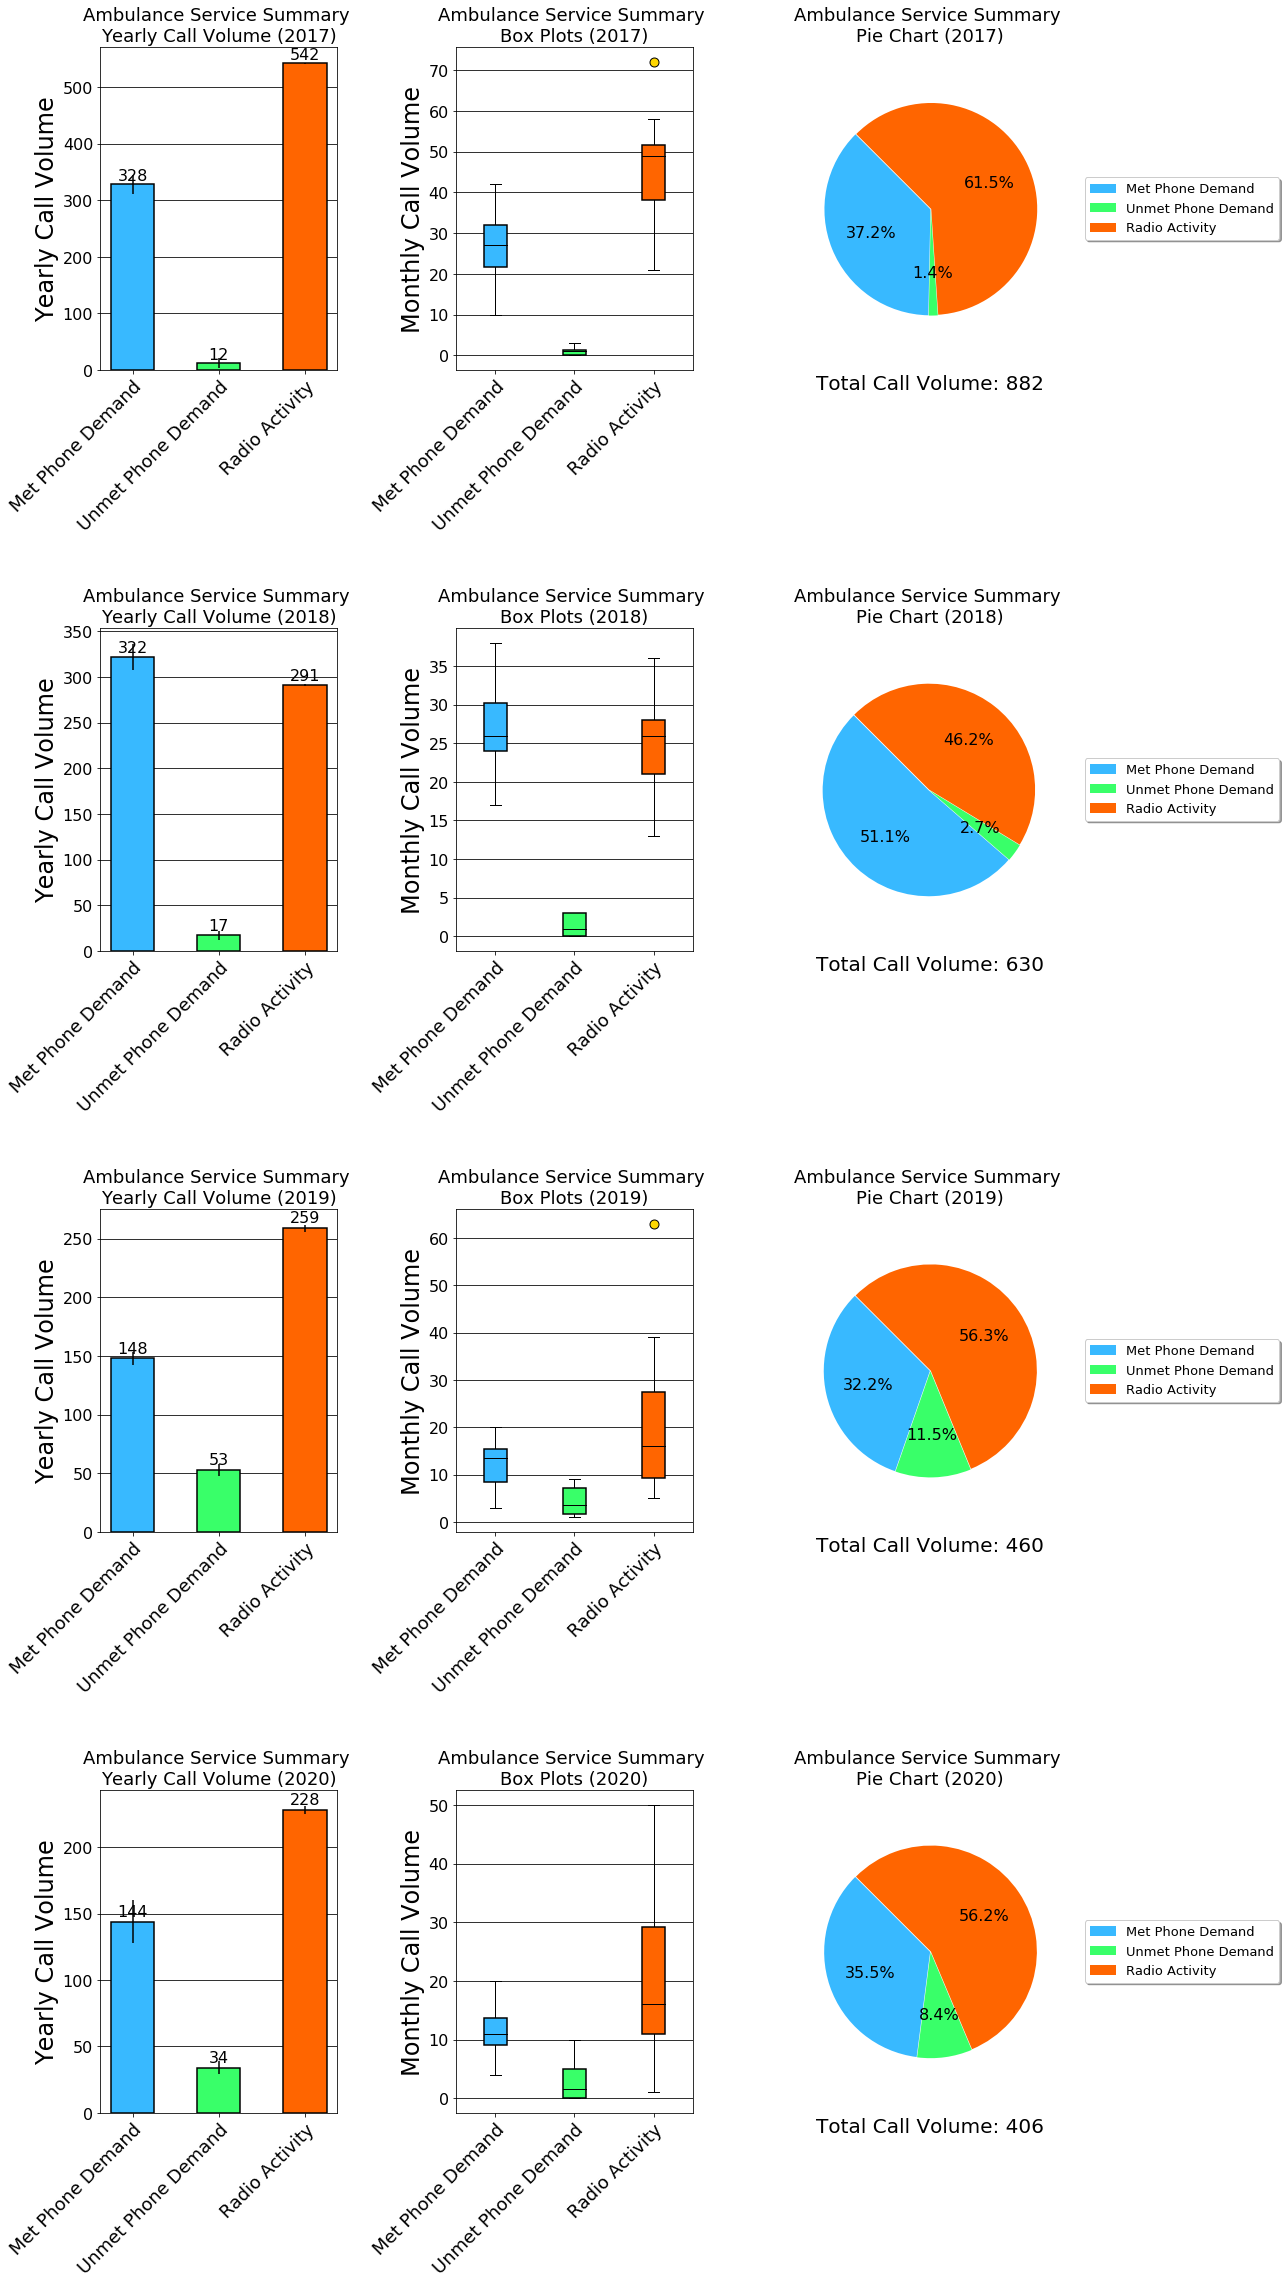

In [17]:
# Create a subplot displaying the call statistics by year (Bar Graph, Box Plot and Pie Chart)
fig, ax = plt.subplots(len(year_range_all), len(call_data), figsize=(17,38), gridspec_kw = {'wspace':0.5, 'hspace':0.8})

# General labels and colors for the data 
labels = ['Met Phone Demand','Unmet Phone Demand','Radio Activity']
colors = ['#38b9ff','#39ff69','#ff6500']
relative_percentage = [] # Calculates the percentage of call volume for each year relative to the cumulative total

# Box Plot Properties and colors
flierprops = dict(marker='o', markerfacecolor='gold', markersize=9)
medianprops = dict(color='k')

# Pie Chart Properties
explode = (0.004,0.004,0.004)

# Make a plot for each year of data 
for l in range(len(year_range_all)):                       
    # Plot Bar Graphs by year for Met Phone Demand, Unmet Phone Demand and Radio Activity
    for i in range(len(call_data)):
        ax[l,0].bar(x=i, yerr=err, height=call_volume_yearly[l][i], width=0.5, color=colors[i], edgecolor='k', 
                    linewidth='1.5', align='center')
        err = np.std(call_data_yearly[l][i])
        relative_percentage.append(call_volume_yearly[l][i]/sum(call_volume)*100)
        
    # Label and format plot    
    ax[l,0].set_xticks([0,1,2])
    ax[l,0].set_xticklabels(labels, rotation=45, fontsize='18', ha='right', rotation_mode='anchor')
    ax[l,0].set_ylabel('Yearly Call Volume', fontsize='24')
    ax[l,0].tick_params(axis='y', labelsize=16)
    ax[l,0].set_title('Ambulance Service Summary \n'+'Yearly Call Volume'+' '+'('+str(year_range_all[l])+')', fontsize=18)
    ax[l,0].yaxis.grid(True, color='k')
    ax[l,0].set_axisbelow(True)
    rects = ax[l,0].patches
    
    # Label the top of each bar with the yearly call volume
    for rect, label in zip(rects, (call_volume_yearly[l])):
        height = rect.get_height()
        ax[l,0].text(rect.get_x() + rect.get_width()/2, height+2, label, ha='center', va='bottom', size=16)

    # Plot Box Plots by year for Met Phone Demand, Unmet Phone Demand and Radio Activity
    box = ax[l,1].boxplot(call_data_yearly[l], flierprops=flierprops, medianprops=medianprops, patch_artist=True)
    
    #Label and format plot 
    ax[l,1].set_title('Ambulance Service Summary \n'+'Box Plots'+' '+'('+str(year_range_all[l])+')', fontsize=18)
    ax[l,1].set_xticklabels(labels, rotation=45, fontsize='18', ha='right', rotation_mode='anchor')
    ax[l,1].set_ylabel('Monthly Call Volume', fontsize='24')
    ax[l,1].tick_params(axis='y', labelsize=16)
    ax[l,1].grid(True, axis='y', zorder=1, color='k')
    
    # Set the color for each dataset 
    for patch, color in zip(box['boxes'], colors):
        patch.set(color='k', linewidth=1.5)
        patch.set_facecolor(color)

    # Plot a Pie Chart by year for Met Phone Demand, Unmet Phone Demand and Radio Activity 
    ax[l,2].pie(call_volume_yearly[l], explode=explode, colors=colors, textprops={'fontsize': 16}, 
                autopct='%1.1f%%', startangle=135)
    
    # Label and format plot
    ax[l,2].axis('equal') # Make shape of pie stay a circle
    ax[l,2].set_title('Ambulance Service Summary \n'+'Pie Chart'+' '+'('+str(year_range_all[l])+')', fontsize=18)
    ax[l,2].set_xlabel('Total Call Volume:' + ' ' + str(sum(call_volume_yearly[l])), fontsize='20')
    legend = ax[l,2].legend(labels, loc="center right", bbox_to_anchor=(0.9, 0, 1.1, 1), prop={'size': 13}, shadow=True)

## Yearly Call Volume and Monthly Call Volume are quantified by Year 

**2017** - Highest total call volume with respect to all years in observation. Unmet Phone demand is at a mere 1.4%. 

    • Radio activity outnumbers Met Phone Demand by 24.3% relative to the total demand.
    • Total Call Volume: 882 - Very active year on all fronts for ambulance service.
    
****

**2018** - Due to a drop in Radio Activity but no major change in Met or Unmet Phone Demand. 
    
    • Met Phone Demand come closer to comprising Total Call Volume a bit more evenly at 46.2%.
    • Unmet Phone Demand increases to 2.7% but the change is relative to a decrease in overall call volume.
    • Unmet Phone demand came in at 17 calls for the year which is an acceptable total. 
    • Met Phone Demand remains relatively unchanged. 
    • Total Call Volume: 630 - Consistent year for ambulance service despite dropping by about 250 calls. 

****

**2019** - An inherent decrease in Met Phone Demand has caused a shift in the makeup of the Total Call Volume. 

    • Consequently Radio Activity (56.3%) outnumbers Met Phone Demand (32.2%) by almost 25%. 
    • Despite Radio Activity percentage increasing for 2019 the call volume dropped by 32 calls compared to 2018.
    • Unmet Phone Demand has slipped up to 11.5% of all of the calls in 2019. 53 missed calls for the year - Poor 
    • The sum of the Met and Unmet Phone Demand (201) is 121 calls less than Met Phone Demand of 2018. 
    • Total Call Volume: 460 - Continual Unmet Phone Demand due to staffing issues lead to a drop in Total Phone Demand.   

****

**2020** - At the current rate, projected total call volume will not meet half the total call volume of 2019.
    
**MAY 2020** <br>
    • Total Call Volume: 118 - Total call volume for the rest of the year is projected to be an all-time low. <br>
    • Action needs to be taken.
 
**OCT 2020** <br>
    • Total Call Volume: 292 - A rise in Total call volume has occurred. There is potential to reach 350 calls by the end of the year 
    
    
**DEC 2020** <br>
    • Total Call Volume: 406 - The year finished off with over 400 calls, more than the expected target for 2020. <br>
    • Despite the COVID-19 pandemic, 3% more of the Phone Demand was met in 2020 vs. 2019. <br>
    • Both 2019 and 2020 saw ~56% of the total call volume come from Radio Activity.
****

**Note:** The circles indicate any outliers in the data.

# Pie Chart - (Aggregate Call Volume and Yearly Call Volume)

Yearly Percent Contribution Relative to Total Call Volume
 
2017: Met Phone Demand 13.8%, Unmet Phone Demand 0.5%, Radio Activity 22.8%
2018: Met Phone Demand 13.5%, Unmet Phone Demand 0.7%, Radio Activity 12.2%
2019: Met Phone Demand 6.2%, Unmet Phone Demand 2.2%, Radio Activity 10.9%
2020: Met Phone Demand 6.1%, Unmet Phone Demand 1.4%, Radio Activity 9.6%


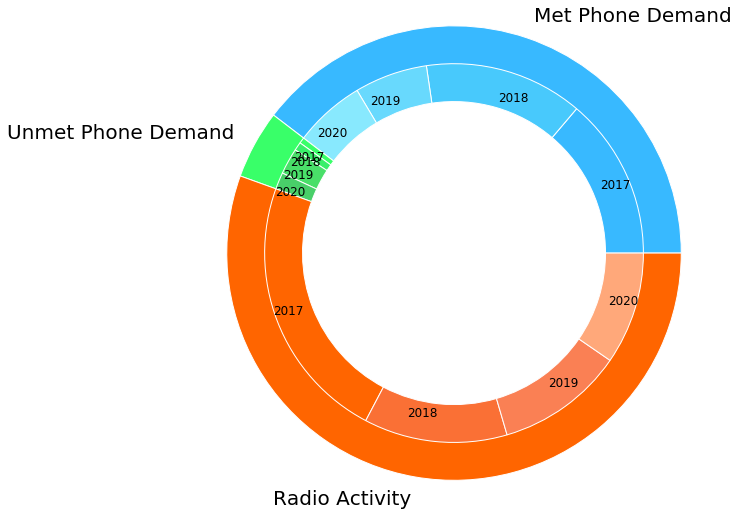

In [18]:
# Create a pie chart subplot that compares the call totals over the year range versus the totals by year 
fig, ax = plt.subplots(figsize=(9,9))

# Create the labels for each ring section
outer_labels = ['Met Phone Demand', 'Unmet Phone Demand', 'Radio Activity']
inner_labels = duplicate(year_labels,len(call_volume))

# Create the sizes for each group by calculating the yearly call volume percentage relative to the aggregate call volume
outer_data = (call_volume)/sum(call_volume)*100
inner_data = []
index = []

# Calculate the relative percentage 
for i in range(len(call_volume)):    
    for j in range(i,len(call_volume)*len(call_volume)+i+1,len(call_volume)): 
        inner_data.append(relative_percentage[j])
        index.append(j)

# Calculate and display the Yearly Percent Contribution Relative to Total Call Volume 
print('Yearly Percent Contribution Relative to Total Call Volume')
print(' ')
for j in range(len(year_range_all)):
               temp = relative_percentage[j*3:j*3+3]
               print(str(year_range_all[j])+':'+' '+'Met Phone Demand'+' '+str("{:0.1f}".format(temp[0]))+'%'+','
                     ' '+'Unmet Phone Demand'+' '+str("{:0.1f}".format(temp[1]))+'%'+','
                     ' '+'Radio Activity'+' '+str("{:0.1f}".format(temp[2]))+'%')
                
# Create colors
colors = ['#38b9ff','#39ff69','#ff6500'] 
colors_alt = ['#38b9ff','#48c9fc','#68d9fd',
              '#88e9fe','#39ff69','#39ef69','#49df69','#49cf69','#ff6500','#fa7035','#fa8054','#ffa87a'] 

# Outer Ring - Aggregate Call Volume
Outer, _ = ax.pie(outer_data, radius=3.0, labels=outer_labels, textprops={'fontsize': 20}, colors=colors)
plt.setp(Outer, width=0.6, edgecolor='white')
 
# Inner Ring - Yearly Call Volume 
Inner, _ = ax.pie(inner_data, radius=2.5, labels=inner_labels, textprops={'fontsize': 12}, labeldistance=0.85,
                  colors=colors_alt)

# Format plot 
ax.axis('equal')
plt.setp(Inner, width=0.5, edgecolor='white')
plt.show()

## The ratios of each year with respect to the call volume categories can be visualized

**2017** - Highest contribution of Radio Activity. <br>
****
**2019** - Met Phone Demand dropped by almost half with respect to **2017**. <br> 
****
**2019** - Unmet Phone Demand quadrupled relative to **2018**. <br> 
****
**2020** - The year has similar contributions to the Total Call Volume as **2019**.  
****    
    • Met Phone Demand and Unmet Phone Demand were consistent in their call volumes for 2017 and 2018.
    • Radio Activity Remained relatively consistent between 2018 and 2019.
    • 2020 and 2019 totals are now relatively consistent in proportion as the year has concluded. 

# Monthly Call Volume - (Total Phone Demand and Met Phone Demand)

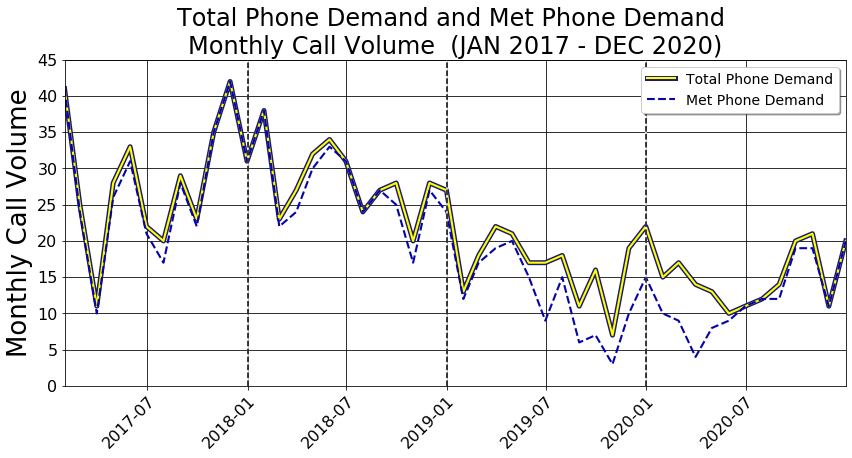

In [19]:
# Create a plot comparing the Monthly Call Volume of Total Phone Demand and Met Phone Demand over the year range  
fig, ax = plt.subplots(figsize=(14,6))

outline_alt = mpe.withStroke(linewidth=5, foreground='midnightblue') # Create a border for line plots

# Plot the monthly call volume of Total Phone Demand and Met Phone Demand 
ax.plot(dt_index,Phone_Total, color='yellow', lw=2.1, path_effects=[outline_alt], label='Total Phone Demand')
ax.plot(dt_index,Phone_Met, '--', color='#0504aa', lw=2.1, label='Met Phone Demand')

# Label and format plot
ax.set_title('Total Phone Demand and Met Phone Demand \n'+'Monthly Call Volume '+' '+'('
             +str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+' '+'-'+' '
             +str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')', fontsize=24)
ax.set_ylabel('Monthly Call Volume', fontsize=26)
ax.margins(x=0) # Removes gaps between outer tick marks and figure
ax.grid(True, color='k')
ax.legend(prop={'size': 14}, shadow=True)

# Add dashed vertical lines to see the transition between years
for l in range(len(year_range_all[1:])):
    plt.axvline(x=str(year_range_all[l+1])+'-01-01T01:00:00.000000000', color='w', linewidth=1.5, linestyle='-')
    plt.axvline(x=str(year_range_all[l+1])+'-01-01T01:00:00.000000000', color='k', linewidth=1.5, linestyle='--')

# Label and format plot    
plt.xticks(rotation=45, fontsize=16, ha='right', rotation_mode='anchor') # x-axis formatting
plt.yticks(fontsize=16) # y-axis formatting

x_numbers = ax.get_yticks()
plt.ylim([0,x_numbers[-1]]) # y-axis upper and lower bounds
plt.show()

## Overlay provides a visual of the monthly performace of Met Phone Demand relative to Total Phone Demand. 

Total Phone Demand serves as the true stream of demand and it is representative of all Phone Demand regardless if it was met or not. Instances where the dashed blue line and yellow line overlap signify Phone Demand was Met at 100%.

****

**2017** - Four months contained 100% Met Phone Demand including all months that exceeded 35 calls per month. 
    
    • For all other months, the Met Phone Demand rate was 90% or higher - Excellent 
    • July 2017 was the one month exception of the year. Also note that Radio Activity was on the lower end for the month. 

****

**2018** - Four months contained 100% Met Phone Demand. Two of these months had 30 or more calls. 
    
    • All remaining months had a Met Phone Demand rate of 85% or higher - Good 

****

**2019** - Met Phone Demand performance faces one of the lowest percentage drops of all time (JUL-AUG) - Poor 
    
    • Despite lack of performance, the Total Phone Demand manages to climb back to 20 or more calls (OCT-DEC) 
    • The flow of demand was still there but there was a struggle to meet it. 

****

**2020** - Met Phone Demand has been approaching an acceptable target level. 

    • During this time-period, there was a two-fold effect. The lack in Met Demand was suppressing the Total Phone Demand.
    • 20 members of the ambulance service were on sick leave due to COVID.
    • COVID also caused residents to stop calling for emergencies as often
    • Staffing for remaining emergencies proved difficult.
    • April 2020 and onward: Met Phone Demand exhibits a positive trend to recovery due to introduction of a 3rd party
    ambulance service. 
    
    • The total phone demand call volume as of October 2020 is as high as it was pre-COVID due to staffing changes.
    • November and December saw 100% of Phone Demand get met - two consecutive months of excellent performance.
    
****

Best Window of Performance: **AUG 2017 - FEB 2018** - Highest Monthly Call Volumes and Met Phone Demand Rate <br>
Worst Window of Performance: **AUG 2019 - APR 2020** - Lowest Monthly Call Volumes and Met Phone Demand Rate <br>

• Looking at the final quarter of 2020, Total Phone Demand bears similar numbers to what were received in this timespan a year ago. <br> 
• The Met Phone Demand rate has vastly improved as indicated by the close mirroring of the yellow and blue line plots.  

****    
**Note:** See Phone Demand Completion Rate for more detail.

# Yearly Call Volume - (Total Phone Demand and Met Phone Demand)

Percentage of Met Phone Demand by Year
2017: 96.5%
2018: 95.0%
2019: 73.6%
2020: 80.9%


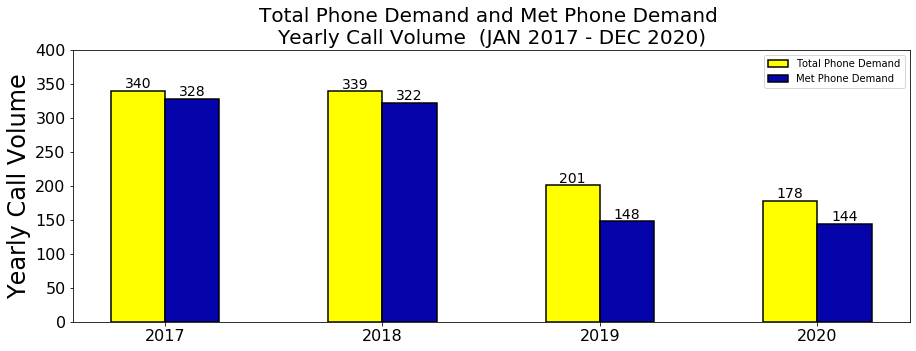

In [20]:
# Create a plot displaying the Yearly Call Volume for Total Phone Demand and Met Phone Demand 
fig, ax = plt.subplots(figsize=(15,5))

# Establish the position and relative spacing of the data
index = np.arange(len(year_range_all))
bar_width = 0.25

# Plot Bar Graphs for Total Phone Demand and Met Phone Demand on the same axis
rects1 = plt.bar(index, Phone_Total_volume_yearly, bar_width, color='yellow', edgecolor='k', linewidth='1.5', 
                 label='Total Phone Demand')
rects2 = plt.bar(index + bar_width, Phone_Met_volume_yearly, bar_width, color='#0504aa', edgecolor='k', linewidth='1.5', 
                 label='Met Phone Demand')

rects = [rects1,rects2]
data_temp = [Phone_Total_volume_yearly, Phone_Met_volume_yearly]

# Label the top of each bar with the yearly call volume
for i in range(len(rects)):    
    for rects[i], label in zip(rects[i], (data_temp[i])):
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width()/2, height+10, label, ha='center', va='center', size=14)

# Calculate and display the yearly percentage of Met Phone Demand relative to Total Phone Demand 
print('Percentage of Met Phone Demand by Year')
for j in range(len(year_range_all)):
    print(str(year_range_all[j])+':'+' '+
          str("{:0.1f}".format(Phone_Met_volume_yearly[j]/Phone_Total_volume_yearly[j]*100))+'%')
        
# Label and format plot
ax.set_title('Total Phone Demand and Met Phone Demand \n'+'Yearly Call Volume '+' '+'('
             +str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+' '+'-'+' '
             +str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')', fontsize=20)
plt.xticks(index + bar_width/2, year_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Yearly Call Volume', fontsize=24)

x_numbers = ax.get_yticks()
plt.ylim([0,x_numbers[-1]]) # y-axis upper and lower bounds
plt.legend()
plt.show()

## Yearly Call Volume is quantified to visualize the Total and Met Phone Demand totals

**2017** - Phone Demand almost entirely met - **Excellent** <br> 
****
**2018** - Phone Demand almost entirely met, totals similar to **2017** - **Excellent** <br> 
****
**2019** - Phone Demand partially met - **Fair** <br> 
****
**2020** - Phone Demand partially met - **Fair**
****

    • The main source of demand was handled appropriately in 2017 and 2018.  
    • The difference in Phone Demand Completion between the two years in negligible. 

Net change (**2018 vs. 2019**) - Total Phone Demand drops by 41%, Met Phone Demand drops by 54% <br> Net change (**2018 vs. 2020**) - Total Phone Demand drops by 47%, Met Phone Demand drops by 59% as of **DEC 2020**

    • The net change in Total and Met Phone Demand exhibits a drastic decline for 2019 and 2020. The Total Phone demand and 
    Met Phone Demand counts for these years however, remain consistent.
    • 2020 received 23 less Phone Demand calls than the previous year. Despite this drop, 81% of all Phone Demand was met in 2020 compared to 74% in 2019.
    

# Call Volume Distribution - (Total Phone Demand and Met Phone Demand) 


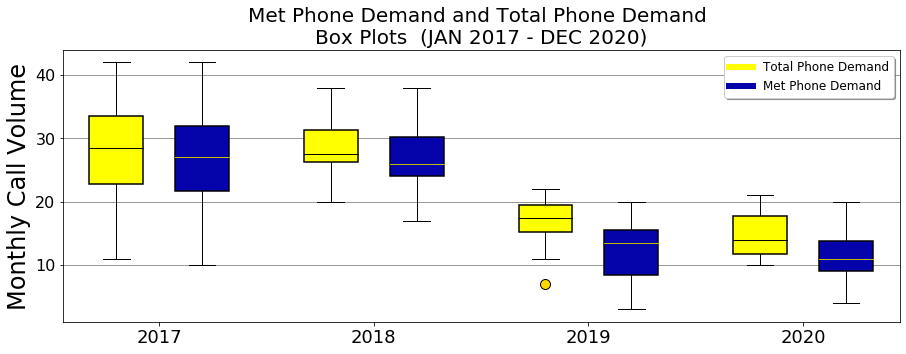

In [21]:
# Create a plot displaying the distribution of the Monthly Call Volume for Total Phone Demand and Met Phone Demand
fig, ax = plt.subplots(figsize=(15,5))

# Plot properties and colors
flierprops = dict(marker='o', markerfacecolor='gold', markersize=10)
medianprops = dict(color='k')
bar_width = 0.25

# Set x-axis position for the data 
x1 = np.array(range(len(year_range_all)))*2.0-0.4
x2 = np.array(range(len(year_range_all)))*2.0+0.4

# Plot Box Plots for Total Phone Demand and Met Phone Demand on the same axis
box1 = ax.boxplot(Phone_Total_yearly, positions=x1, flierprops=flierprops, medianprops=dict(color='k'), patch_artist=True)
box2 = ax.boxplot(Phone_Met_yearly, positions=x2, flierprops=flierprops, medianprops=dict(color='y'), patch_artist=True)

# Label and format plot
ax.set_title('Met Phone Demand and Total Phone Demand \n'+'Box Plots '+' '+'('+str.upper(df['Month Name'][0])+' '
             +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
             +str(year_range_all[-1])+')', fontsize=20)
ax.set_xticklabels(year_labels, fontsize='18')
ax.set_xticks(range(0, len(year_range_all)*2, 2))
ax.set_ylabel('Monthly Call Volume', fontsize='24')
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, axis='y', zorder=1, color='grey')

boxes = [box1,box2]
colors = [['yellow'],['#0504aa']]
labels = ['Total Phone Demand','Met Phone Demand']

# Set the color and label each dataset
for i in range(len(boxes)):
    color_string = duplicate(colors[i],len(year_range_all))
    
    for patch, color in zip(boxes[i]['boxes'],color_string):
        patch.set(color='k', linewidth=1.5)
        patch.set_facecolor(color)
    
    # Draw temporary colored lines and use them to create a legend
    plt.plot([], c=colors[i][0], linewidth=6, label=labels[i])

# Label and format plot    
plt.legend(prop={'size': 12}, shadow=True)
plt.show()

## Show how the spread of data varies for Total and Met Phone Demand by Year

**2017** - Relatively large spread for Total and Met Phone Demand. Both datasets are symmetric distributions and the inter quartile ranges are contained above 20 calls per month. 

    • Phone Demand was completely met during the most active month and two calls were missed during the least active month. 
    The Unmet Phone Demand is spread over the course of the year and no particular month has an extreme total of missed 
    calls.
    
    Max Values: Phone Total 42, Phone Met 42 
    Min Values: Phone Total 11, Phone Met 10 
    Range: Phone Total 31, Phone Met 32 
    
****

**2018** - Spread of Total and Met Phone Demand is more condensed compared to 2017. Both datasets are positively skewed distributions and the inter quartile ranges are contained above 20 calls per month.
    
    • Phone Demand was completely met during the most active month and three calls were missed during the least active 
    month. The Unmet Phone Demand is spread over the course of the year and no particular month has an extreme total of 
    missed calls. 
    
    • Despite the drop in maximum monthly Phone Demand (from 42 to 38), the minimum Total Phone Demand increased by 9 calls 
    and the minimum monthly Met Phone Demand increased by 7 calls.  
    
    Max Values: Phone Total 38, Phone Met 38 
    Min Values: Phone Total 20, Phone Met 17 
    Range: Phone Total 18, Phone Met 21
    
****

**2019** - Total Phone Demand has a symmetric distribution while Met Phone Demand has a negatively skewed distribution. <br> The maximum values do not exceed the first quartile in either of the two previous years suggesting an extreme drop in general Phone Demand and response the primary source of emergencies. 
    
    • The busiest month of Total Phone demand had 22 calls and 20 of those calls were met. The least active month for  
    Total Phone demand had 7 calls and only 4 of those calls were met. 
    
    • There is a disparate difference in the boxplots suggesting that several months within the year contain several missed  
    calls.

    Max Values: Phone Total 20, Phone Met 22 
    Min Values: Phone Total 7, Phone Met 4 
    Range: Phone Total 13, Phone Met 16

****

**2020** - **MAY 2020** Total Phone Demand has a symmetric distribution while Met Phone Demand has a negatively skewed distribution. Similarly to 2019, the disparate difference in distribution of the boxplots suggests that several months faced unusually high totals of Unmet Phone Demand.
    
    • During the most active month, only 10 of the 17 calls were met. 
    • Minimum Total Phone demand saw an increase to 10 calls yet only 4 calls were actually met. 

    • The range of the datasets are relatively contained in terms of spread but all of the monthly 
    totals are below 20 calls. 
    
    • The maximum totals for each dataset fall between Q1 and Q3 of the previous year suggesting 
    an overall drop in activity.  
    
    Max Values: Phone Total 17, Phone Met 10 
    Min Values: Phone Total 10, Phone Met 4
    Range: Phone Total 7, Phone Met 6
    
**OCT 2020** - Total Phone Demand and Met Phone Demand both have positively skewed distributions. 
    
    • The IQR ranges are identical for 2019 and 2020 pertaining to Total Phone Demand.  
    
    • Despite the disruptions in demand from the COVID-19 Pandemic, the minimum amount of Total Phone demand received in 
    2020 exceeded the 2019 minimum by 3 calls.     
    
**DEC 2020** - Total Phone Demand and Met Phone demand retain positively skewed distributions.

    • In the last month of activity for 2020, 20 Phone Demand calls were met. This matches the best performing month of 2019 which occurred in April. 
    
    • The busiest month of the year came in October with a total of 21 Phone Demand Calls.
    
    Max Values: Phone Total 21, Phone Met 20 
    Min Values: Phone Total 10, Phone Met 4
    Range: Phone Total 11, Phone Met 16
   
****

While **2017** had a large spread of monthly Total Phone demand and **2018** was more contained, both years are good examples of strong performance for the ambulance service. Total Phone Demand was virtually equal, majority of the Phone Demand was met and during the months with the highest call volumes demand was met to the fullest extent. **2019** and **2020** indicated that failing to meet Phone Demand over an extended period of time hurts the Total Phone Demand in the long run.  

    • The approach to meeting Phone Demand and staffing needs reconsideration moving forward.
    • As of OCT 2020, Total Phone Demand has the potential to meet or exceed the 2019 total.   
    • As of DEC 2020, Met Phone Demand met the 2019 total but Total Phone Demand did not.
    • Looking at the monthly met percentage rates however, the service is performing better than it was a year ago.

****

**Note:** The circles indicate any outliers in the data.

# Phone Demand Percent Completion Rate

Average Phone Demand Percent Completion Rate by Year
2017: 95.5%
2018: 94.6%
2019: 71.2%
2020: 80.9%


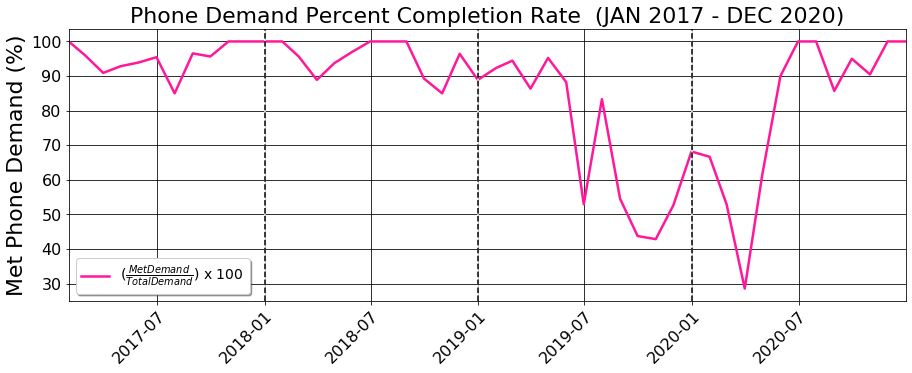

In [22]:
# Create a plot displaying the Phone Demand Percent Completion Rate 
fig, ax = plt.subplots(figsize=(15,5)) 

# Plot Met Phone Demand as a percentage of Total Phone Demand 
ax.plot(dt_index,Phone_Met/Phone_Total*100, color='#ff199a', lw=2.5, label=''r'$(\frac{Met Demand}{Total Demand})$ x 100')

# Label and format plot
ax.set_title('Phone Demand Percent Completion Rate '+' '+'('+str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+
             ' '+'-'+' '+str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')', fontsize=22)
ax.set_ylabel('Met Phone Demand (%)', fontsize=22)
ax.margins(x=0) # Removes gaps on the x-axis
ax.grid(True, color='k')
ax.legend(prop={'size': 14},shadow=True)

# Add dashed vertical lines to see the transition between years
for l in range(len(year_range_all[1:])):
    plt.axvline(x=str(year_range_all[l+1])+'-01-01T01:00:00.000000000', color='w', linewidth=1.5, linestyle='-')
    plt.axvline(x=str(year_range_all[l+1])+'-01-01T01:00:00.000000000', color='k', linewidth=1.5, linestyle='--')

# Calculate and display the yearly percentage of Met Phone Demand relative to Total Phone Demand 
print('Average Phone Demand Percent Completion Rate by Year')
for j in range(len(year_range_all)):
    print((str(year_range_all[j])+':'+' '+
           str("{:0.1f}".format(sum((Phone_Met[j*12:j*12+12]/Phone_Total[j*12:j*12+12])*100)/12)))+'%')

# Label and format plot
plt.xticks(rotation=45, fontsize=16, ha='right', rotation_mode='anchor') # x-axis formatting
plt.yticks(fontsize=16) # y-axis formatting
plt.show()

## Phone Demand Percent Completion Rate is defined as the percentage of Phone Demand that was met relative to Total Phone Demand 

**2017** - All but one month had a Percent Completion Rate above 90%. 
    
    • Four months had 100% Phone Demand Completion Rate. 
    • Overall Performance - Excellent
    
****

**2018** - A total of only four months had a Percent Completion Rate under 90%. 

    • Four months had 100% Phone Demand Completion Rate. 
    • Overall Performance - Good 

****

**2019** - During the first five months the Average Phone Demand Percent Completion Rate was at 91.3%.
    
    • By the end of the year the Average Percent Completion Rate dropped to 71.2% 
    • At no time during the year was Phone Demand Completion Rate at 100%.
    • Average Phone Demand Percent Completion Rate - Fair 

****

**2020** - The Average Phone Demand Percent Completion Rate to date is 64.2% 
    
   **MAY 2020** - Phone Demand Percent Completion Rate reached 90% for the first time in 2020. 
      
    • All remaining months had Percent Completion Rates under 70%. 
    • Average Phone Demand Percent Completion Rate to date is 59.9 - Poor 
    
   **OCT 2020** - Phone Demand Percent Completion Rate typically 90% or greater for all months.
   
    • Substantial improvement pertaining to meeting Phone Demand
    • Average Phone Demand Percent Completion Rate between MAY 2020 and OCT 2020 is 93.5%. 
    • Vast 6 month improvement relative to the first 5 months of the year.   
    
   **DEC 2020** - Phone Demand Percent Completion Rate typically 90% or greater for all months.
    • Average Phone Demand Percent Completion Rate between MAY 2020 and OCT 2020 is 95.1%.  
   
****

Best Window of Performance: **JAN 2017 - AUG 2018**. Percent Completion Rate relatively consistent and above the 90% target. Aside from the outliers of **JUL 2017** and **MAR 2018**, this was the best continuous span of performance for the service.

• Transitioning into **SEP 2018**, the Percent Completion Rate never reaches 100% again to date. Starting in this month, there
was a change in leadership to allow one of the lieutenants to assume more responsibility overseeing daily operations. During the initial nine months (**SEP 2018 - MAY 2019**) of this operational change, 90.7% of all Phone Demand was met. Performance seemed to be going well despite the slight drop in Call Completion Rate nothing seemed alarming. 

• Transitioning into **JUN 2019**, the Percent Completion Rate unexpectedly dropped to 52.9%, the lowest for its time July Recovered to 83.3% but the negative trend continued in subsequent months until October where Percent Completion Rate dropped even lower to 42.9% making this the worst performing month to date. Also note this month contains the lowest. Total and Met Phone Demand Call Volumes at 7 and 3 calls respectively. 

• Continuing to **JAN 2020**, there appeared to be a recovery of Percent Completion Rate at 68.2% suggesting that there would be a positive trend continuing through the rest of the year. As the year carried on however, the Percent Completion Rate fell to 28.6%, the lowest to date in **MAR of 2020**. A combination of ongoing staffing issues, the COVID-19 pandemic and members calling out sick led to the inevitable decline. 

• Recovery Stage: **APR 2020 - MAY 2020**, and onward. Phone Demand Percent Completion rate has been restored to 90%. Achieving this percentage is milestone because this value has not been met since May of last year. Demand that would have gone unmet is now being outsourced to a 3rd party ambulance service. Demand that is outsourced also includes non-emergency transports that would normally not be handled by the ambulance service and a separate category will be made for non-emergency calls to reflect the change.  

• Monitoring Progress: **MAY 2020 - Present** - Staffing and demand overflow solutions have been implemented. Phone Demand Percent Completion Rate has been 90% or greater on average. Percentages on this level have not been seen since **MAY 2019**

***
    In theory since no call will go unmet unless a caller denies the 3rd party service, the call statistics concerning Phone 
    Demand will be changed to reflect what percentage of Met Phone Demand is outsourced. 
 

# Sample by Year Pre-Processing

In [23]:
# Yearly Data Collection - Separate out data by year and access it through a dictionary 
# Store the indicies of the years declared in year_range_all as a nested list
year_indicies_Phone = [] # ex: year_indicies_Phone[0] = [0,1,2,...] --> All indicies of phone demand in 2017
year_indicies_Phone_Met = [] # ex: year_indicies_Phone_Met[1] = [328,329,...] --> All indicies of met phone demand in 2018
year_indicies_Radio = [] # ex: year_indicies_Radio[2] = [833,834,835,...] --> All indicies of radio activity in 2019 

# Save all of the days of the week in choronological order as a list and access the lists by year 
Days_Phone_dict = {} # ex: Days_Phone_dict[0] = ['Sunday','Monday','Monday',...] --> All days for phone demand in 2017
Days_Phone_Met_dict = {}  # ex: Days_Phone_Met_dict[1] = ['Monday','Monday',...] --> All days for met phone demand in 2018
Days_Radio_dict = {} # ex: Days_Radio_dict[2] =  ['Tuesday','Tuesday',...] --> All days of radio activity in 2019

# Save the hour from each event in choronological order as a list and access the lists by year 
Hours_Phone_dict = {} # ex: Hours_Phone_dict[0] = ['6','3','5'...] --> All hours for phone demand in 2017 
Hours_Phone_Met_dict = {} # ex: Hours_Phone_Met_dict[1] = ['9','10','15',...] --> All hours for met phone demand in 2018  
Hours_Radio_dict = {} # ex: Hours_Radio_dict[2] = ['0','1','22',...] --> All hours for radio activity in 2019

# Obtain indcies from each day of the week as a nested list where each day is one of 7 x len(year_range_all) sublists
# There are 7 sublists per year. In this case there are 21 total sublists per variable 
DOW_Phone = [] # ex: DOW_Phone[0] = [0,13,14,...] --> All indicies of phone demand for every Sunday in 2017
DOW_Phone_Met = [] # ex: DOW_Phone_Met[9] = [11,23,27,...] --> All indicies of met phone demand for every Tuesday in 2018
DOW_Radio = [] # ex: DOW_Radio[20] = [4,5,9,...] --> All indicies of radio activity for every Saturday in 2019   

# Save data from above as a dictionary to access each nested day of week list by year
# i.e. DOW_Phone_dict[0] = [[0..],[1..],[5..],[20..],[10..],[28..],[22..]] --> All indicies of each day of the week for 2017
DOW_Phone_dict = {} # ex: DOW_Phone_dict[0][0] = [0,13,14,38,...] --> All indicies of phone demand on Sunday in 2017   
DOW_Phone_Met_dict = {} # ex: DOW_Phone_Met_dict[1][2] = [11,23...] --> All indicies of met phone demand on Tuesday in 2018
DOW_Radio_dict = {} # DOW_Radio[2][6] = [4,5,9,...] --> All indicies of radio activity on Saturday in 2019  

# Nested list containing the hours of each event sorted by the days of the week. There are 7 x len(year_range_all) sublists
# There are 7 sublists per year. In this case there are 21 total sublists per variable
Phone_daily = [] # ex: Phone_daily[0] = ['6','8','21',...] --> Phone demand on the hour for every Sunday in 2017
Phone_Met_daily = [] # ex: Phone_Met_daily[9] = ['17','0','10',...] --> Met phone demand on the hour for every Tuesday in 2018 
Radio_daily = [] # ex: Radio_daily[20] = ['18','22','21',...] --> Radio activity on the hour for every Saturday in 2019

# Save data from above as a dictionary to access each nested hourly list by year
Phone_dict = {} # ex: Phone[0][0] = ['6','8','21',...] --> Phone demand on the hour for every Sunday in 2017
Phone_Met_dict = {} # ex: Phone_Met_dict[1][2] = ['17','0','10',...] --> Met phone demand on the hour for every Tuesday, 2018  
Radio_dict = {} # ex: Radio_dict[2][6] = ['18','22','21',...] --> Radio activity on the hour for every Saturday in 2019

# Aggregate Data Collection - Pool all years of data
# Save the indicies for any type of demand or activity as an aggregrate dataset as per year_range_all
Indicies_Phone = [] # All indicies of phone demand with respect to df_Phone['Day']
Indicies_Phone_Met = [] # All indicies of met phone demand with respect to df_Phone_Met['Day']
Indicies_Radio = [] # All indicies of radio activity with respect to df_Radio['Day']

# Save the hour of an event for any type of demand or activity as an aggregrate dataset as per year_range_all
Hours_Phone = [] # All hours of Phone Demand 
Hours_Phone_Met = [] # All hours of Met Phone Demand
Hours_Radio = [] # ALl hours of Radio Activity

# Count the frequency of the calls per hour for each day
Hours_list_Phone = [] # Hours_list_Phone = [31,52,69,...] Phone demand call volume listed by day
Hours_list_Phone_Met = [] # Hours_list_Phone_Met = [30,51,65,...] Met Phone demand call volume listed by day
Hours_list_Radio = [] # Hours_list_Radio = [91,103,61,...] Radio Activity call volume listed by day

# Save the hourly call frequncy for each day by year 
Hours_list_Phone_yearly = [] # Hours_list_Phone_yearly[0] = [31, 52, 69, 54, 46, 33, 55] Phone demand call volume listed 
                             # by day of week in 2017
Hours_list_Phone_Met_yearly = [] # Hours_list_Phone_Met_yearly[1] = [48, 62, 40, 41, 41, 43, 47] Met Phone demand call 
                                 # volume listed by day of week in 2018
Hours_list_Radio_yearly = [] # Hours_list_Radio_yearly[2] = [46, 15, 24, 15, 55, 33, 71] Radio activity 
                             # call volume listed by day of week in 2019

In [24]:
# Save the hour from the time of the demand or activity for each day of the week. Access the data by year with a dictionary 
# Loop through all of the years from the dataset
for l in range(len(year_range_all)):
    # Get the positional index for each year in the dataset save it as a nested list    
    year_indicies_Phone.append([x for x, year in enumerate(Phone_year) if year == year_range_all[l]])
    year_indicies_Phone_Met.append([x for x, year in enumerate(Phone_Met_year) if year == year_range_all[l]])
    year_indicies_Radio.append([y for y, year in enumerate(Radio_year) if year == year_range_all[l]])
    
    # Convert the respective Data Frames 'Day' & 'Hour' columns to lists
    Days_Phone_yearly = df_Phone['Day'].iloc[year_indicies_Phone[l]].astype(str).values.tolist()
    Days_Phone_Met_yearly = df_Phone_Met['Day'].iloc[year_indicies_Phone_Met[l]].astype(str).values.tolist()
    Days_Radio_yearly = df_Radio['Day'].iloc[year_indicies_Radio[l]].astype(str).values.tolist()
    
    # Pass the years indicies into the DataFrames to extract the hour from the time of demand or activity 
    Hours_Phone_yearly = (df_Phone['Hour'].iloc[year_indicies_Phone[l]].astype(str).values.tolist())
    Hours_Phone_Met_yearly = (df_Phone_Met['Hour'].iloc[year_indicies_Phone_Met[l]].astype(str).values.tolist())
    Hours_Radio_yearly = df_Radio['Hour'].iloc[year_indicies_Radio[l]].astype(str).values.tolist()
    
    # Save all of the days of the week in choronological order as a list and access the lists by year in a dictionary  
    Days_Phone_dict[l] = Days_Phone_yearly
    Days_Phone_Met_dict[l] = Days_Phone_Met_yearly
    Days_Radio_dict[l] = Days_Radio_yearly
    
    # Save the hour from each event for every DOW as a list and access the lists by year in a dictionary 
    Hours_Phone_dict[l] = Hours_Phone_yearly
    Hours_Phone_Met_dict[l] = Hours_Phone_Met_yearly
    Hours_Radio_dict[l] = Hours_Radio_yearly
    
    # Iterate through all of the days of the week
    for j in range(len(DOW)):
        # Obtain indcies from each day of the week as a nested list by enumerating the days from the yearly dictionaries
        DOW_Phone.append(([i for i, x in enumerate(Days_Phone_dict[l]) if x == DOW[j]]))
        DOW_Phone_Met.append(([i for i, x in enumerate(Days_Phone_Met_dict[l]) if x == DOW[j]]))
        DOW_Radio.append([i for i, y in enumerate(Days_Radio_dict[l]) if y == DOW[j]])
        
        # Save the indicies for any type of demand or activity as an ggregrate dataset as per year_range_all
        Indicies_Phone.append([i for i, x in enumerate(Day_Of_Week_Phone) if x == DOW[j]])
        Indicies_Radio.append([i for i, x in enumerate(Day_Of_Week_Radio) if x == DOW[j]])
        Indicies_Phone_Met.append([i for i, x in enumerate(Day_Of_Week_Phone_Met) if x == DOW[j]])
    
        # Pass DOW indicies into the Data Frame column 'Hour' and return the hours of the day for each phone and radio call
        Hours_Phone.append(df_Phone['Hour'][Indicies_Phone[j]].astype(str).values.tolist())
        Hours_Radio.append(df_Radio['Hour'][Indicies_Radio[j]].astype(str).values.tolist())
        Hours_Phone_Met.append(df_Phone_Met['Hour'][Indicies_Phone_Met[j]].astype(str).values.tolist())
    
    # Save the indcies from each day of the week as a nested list and access the lists by year in a dictionary
    DOW_Phone_dict[l] = DOW_Phone[(l*7):(l*7)+7]
    DOW_Phone_Met_dict[l] = DOW_Phone_Met[(l*7):(l*7)+7]
    DOW_Radio_dict[l] = DOW_Radio[(l*7):(l*7)+7]
    
    # Iterate through all of the days of the week
    for j in range(len(DOW)):
        # Nested list containing the hours of each event sorted by the days of the week
        Phone_daily.append([Hours_Phone_dict[l][i] for i in DOW_Phone_dict[l][j]])
        Phone_Met_daily.append([Hours_Phone_Met_dict[l][i] for i in DOW_Phone_Met_dict[l][j]])
        Radio_daily.append([Hours_Radio_dict[l][i] for i in DOW_Radio_dict[l][j]])
    
    # Nested list containing the hours of each event sorted by the days of the week. Access year with a dictionary
    Phone_dict[l] = Phone_daily[(l*7):(l*7)+7]
    Phone_Met_dict[l] = Phone_Met_daily[(l*7):(l*7)+7]
    Radio_dict[l] = Radio_daily[(l*7):(l*7)+7]

    # Read in each hourly nested list by year and pass it through a dummy variable 
    Hours_Radio_yearly = Radio_dict[l]
    Hours_Phone_yearly = Phone_dict[l]
    Hours_Phone_Met_yearly = Phone_Met_dict[l]
    
    # Iterate through all of the days of the week
    for j in range(len(DOW)):
        # Append each counts of calls per hour for each day
        Hours_list_Radio.append(len(Hours_Radio_yearly[j]))
        Hours_list_Phone.append(len(Hours_Phone_yearly[j]))
        Hours_list_Phone_Met.append(len(Hours_Phone_Met_yearly[j]))
    
    # Append the hourly call frequncy for each day by year and create a nested list
    Hours_list_Radio_yearly.append(Hours_list_Radio[(l*7):(l*7)+7]) 
    Hours_list_Phone_yearly.append(Hours_list_Phone[(l*7):(l*7)+7])
    Hours_list_Phone_Met_yearly.append(Hours_list_Phone_Met[(l*7):(l*7)+7])

# Calculate the cumulative daily total over all the years in the dataset for any type of demand or activity     
Count_Radio = sum(np.array(Hours_list_Radio_yearly))
Count_Phone = sum(np.array(Hours_list_Phone_yearly))
Count_Phone_Met = sum(np.array(Hours_list_Phone_Met_yearly))

# Daily Call Volume

Unmet Phone Demand Daily Call Volume
Sunday: 15       Monday: 14       Tuesday: 18       Wednesday: 16       Thursday: 11       Friday: 22       Saturday: 20       



Met Phone Demand Daily Call Volume
Sunday: 136      Monday: 159      Tuesday: 141      Wednesday: 134      Thursday: 123      Friday: 112      Saturday: 137      



Total Daily Call Volume
Sunday: 407      Monday: 318      Tuesday: 288      Wednesday: 276      Thursday: 344      Friday: 340      Saturday: 405      



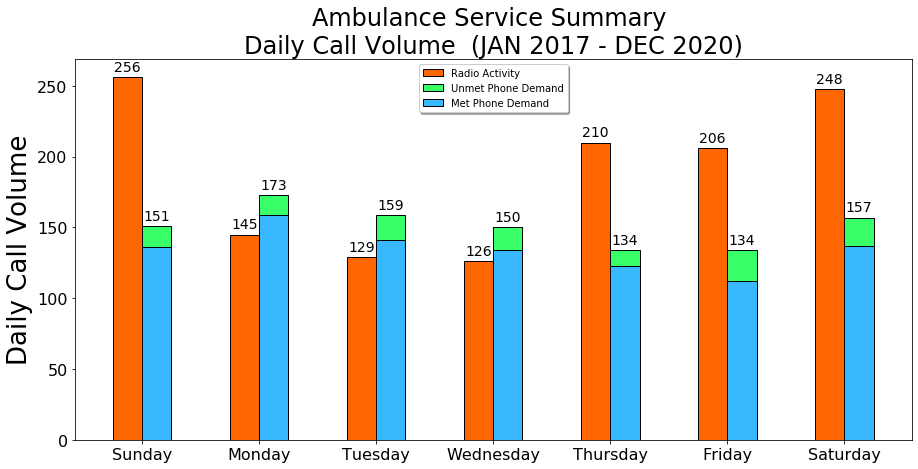

In [25]:
# Create a plot displaying the Daily Call Volume for each type of demand or activity over the year range 
fig, ax = plt.subplots(figsize=(15,7))

# Establish the position and relative spacing of the data 
index = np.arange(len(DOW))
bar_width = 0.25

# Plot Bar Graphs for Met Phone Demand, Unmet Phone Demand and Radio Activity on the same axis
rects1 = plt.bar(index-bar_width/2, Count_Radio, bar_width, color='#ff6500', edgecolor='k', linewidth='1', 
                 label='Radio Activity')
rects2 = plt.bar(index+bar_width/2, Count_Phone, bar_width, color='#39ff69', edgecolor='k', linewidth='1', 
                 label='Unmet Phone Demand')
rects3 = plt.bar(index+bar_width/2, Count_Phone_Met, bar_width, color='#38b9ff', edgecolor='k', linewidth='1', 
                 label='Met Phone Demand')

rects = [rects1,rects2]
data_temp = [Count_Radio, Count_Phone]

# Label the top of each bar with the yearly call volume
for i in range(len(rects)):    
    for rects[i], label in zip(rects[i], (data_temp[i])):
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width()/2, height+2, label, ha='center', va='bottom', size=14)

# Display the Unmet Phone Demand Daily Call Volume 
print('Unmet Phone Demand Daily Call Volume')
for j in range(len(DOW)):
    print(DOW[j]+':'+' '+str(Count_Phone[j]-Count_Phone_Met[j]), end ='       ')

print('\n')   
print('\n')
    
# Display the Met Phone Demand Daily Call Volume 
print('Met Phone Demand Daily Call Volume')
for j in range(len(DOW)):
    print(DOW[j]+':'+' '+str(Count_Phone_Met[j]), end ='      ')
    
print('\n')    
print('\n')
    
# Display the Total Daily Call Volume 
print('Total Daily Call Volume')
for j in range(len(DOW)):
    print(DOW[j]+':'+' '+str(Count_Phone[j]+Count_Radio[j]), end ='      ')

print('\n')

# Label and format plot        
ax.set_title('Ambulance Service Summary \n'+'Daily Call Volume '+' '+'('
             +str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+' '+'-'+' '
             +str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')', fontsize=24)
plt.xticks(index, DOW, fontsize=16) # x-axis formatting
plt.yticks(fontsize=16) # y-axis formatting
plt.ylabel('Daily Call Volume', fontsize=26)
plt.legend(prop={'size': 10}, shadow=True)
plt.show()

## Daily Call Volumes are quantified for all types of Demand or Activity as an aggregate total over the Year Range

Ranking of Daily Call Volume for each category from greatest to least:
    
    Radio Activity: Sun, Sat, Thurs, Fri, Mon, Tue, Wed
    Total Phone Demand: Mon, Tue, Sat, Sun, Wed, Fri/Thurs
    Unmet Phone Demand: Fri, Sat, Tue, Wed, Sun, Mon, Thurs
    Total Daily Call Volume: Sun, Sat, Thurs, Fri, Mon, Tue, Wed
    
    See above print statement for Unmet Phone Demand, Met Phone Demand and Total Daily Call Volume Totals. 

• The data implies more Phone Demand during weekdays will in turn cause crews to respond to less Radio Activity. On the weekends this does not hold true however. Phone Demand is comparable or greater than the busiest weekdays.

• Theoretically more crews are available during the off-peak hours for Thurs/Fri and weekends which causes the surge in Radio Activity when there is no Phone Demand to respond to. 

• While this observation gives good insight on the behavior of weekly trends the data includes over 2,300 calls over the span of four years. Staffing and demand patterns for Phone Demand and Radio Activity vary by year and consequently may not sync up.
    
    Consult the "Daily Call Volume by Year" section to see the aggregate weekly patterns for each year individually. 
****
**Note:** The totals above the blue and green bars is counted as Total Phone Demand (sum of Unmet and Met Phone Demand)

# Daily Call Volume by Year

In [26]:
# Create Dataframes for aspects of the Daily Call Volume plots which are not clearly represented 
unmet_count_temp = []
unmet_count_dict = {}
unmet_table = []

met_count_temp = []
met_count_dict = {}
met_table = []

total_count_temp = []
total_count_dict = {}
total_table = []

for l in range(len(year_range_all)):
    for j in range(len(DOW)):
        unmet_count_temp.append(Hours_list_Phone_yearly[l][j]-Hours_list_Phone_Met_yearly[l][j])
        unmet_count_dict[l] = unmet_count_temp[l*len(DOW):l*len(DOW)+len(DOW)]
        
        met_count_temp.append(Hours_list_Phone_Met_yearly[l][j])
        met_count_dict[l] = met_count_temp[l*len(DOW):l*len(DOW)+len(DOW)]
        
        total_count_temp.append(Hours_list_Phone_yearly[l][j]+Hours_list_Radio_yearly[l][j])
        total_count_dict[l] = total_count_temp[l*len(DOW):l*len(DOW)+len(DOW)]
    
    unmet_table.append(unmet_count_dict[l])
    met_table.append(met_count_dict[l])
    total_table.append(total_count_dict[l])    
    
unmet_df = pd.DataFrame(unmet_table, year_labels, DOW) # Unmet daily totals
unmet_df['Yearly Total'] = Phone_Unmet_volume_yearly
met_df = pd.DataFrame(met_table, year_labels, DOW)     # Met daily totals 
met_df['Yearly Total'] = Phone_Met_volume_yearly
total_df = pd.DataFrame(total_table, year_labels, DOW) # Radio and phone demand daily totals  
total_df['Yearly Total'] = Combined_volume_yearly

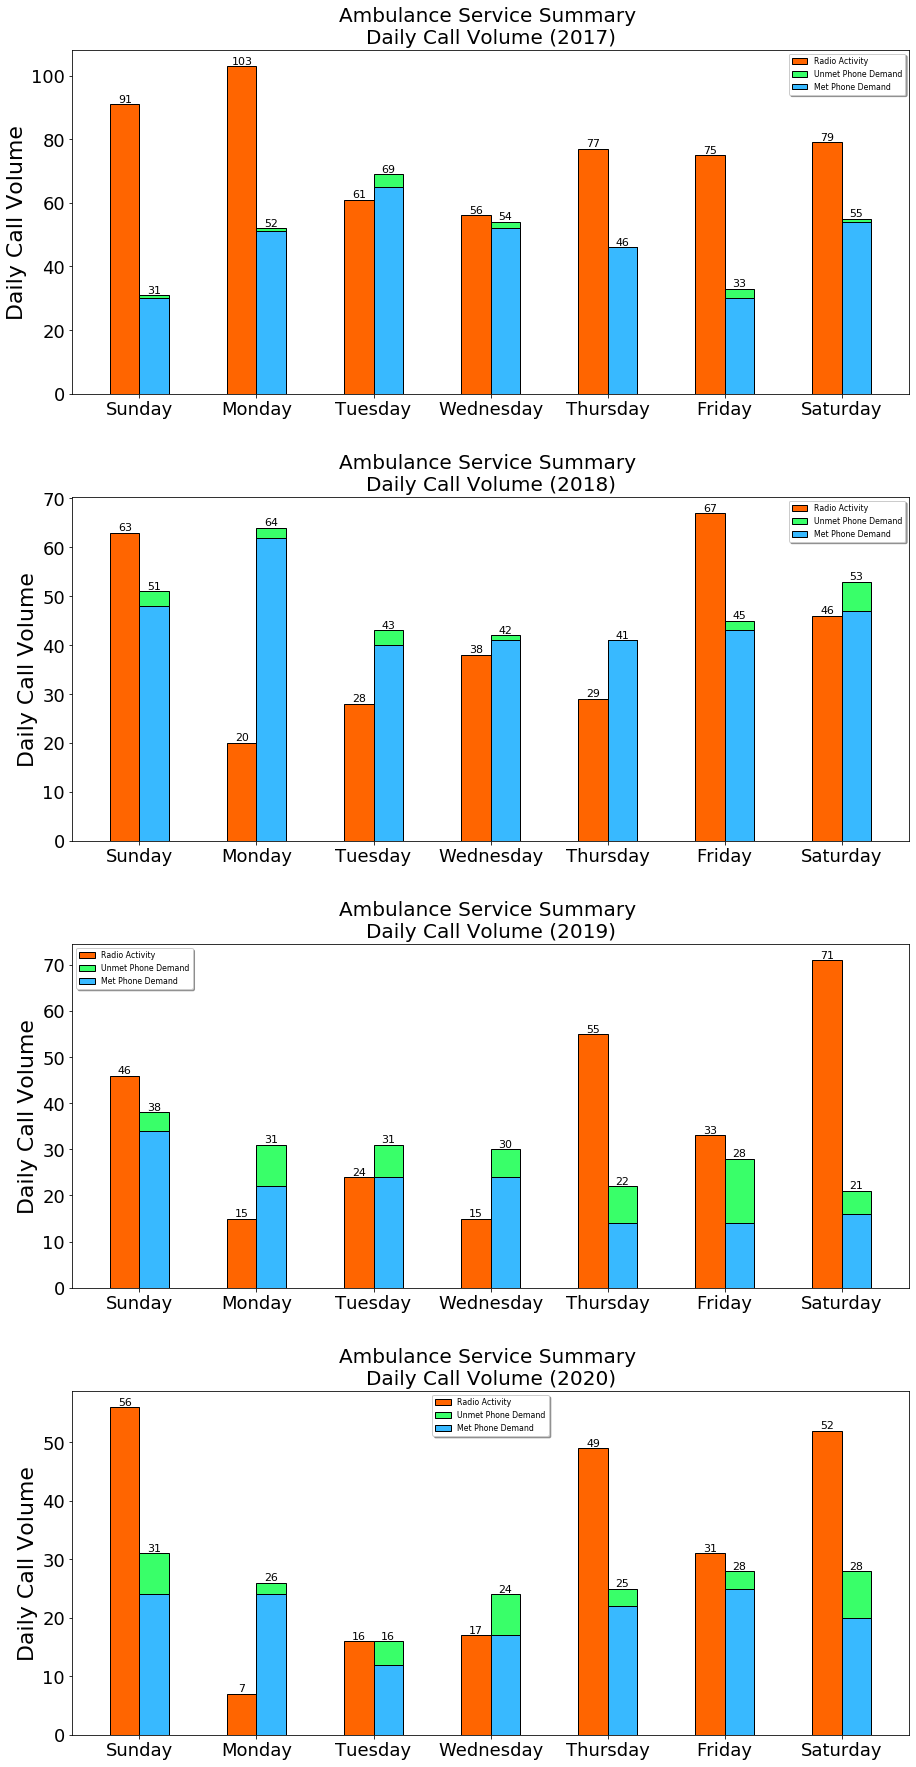

In [27]:
# Create a plot displaying the Daily Call Volume for each type of demand or activity over the year range 
fig, ax = plt.subplots(4, 1, figsize=(15,31), gridspec_kw = {'wspace':0, 'hspace':0.3},sharey=False) # Establish a subplot

index = np.arange(len(DOW))

for l in range(len(year_range_all)):
    rects1 = ax[l].bar(index-bar_width/2, Hours_list_Radio_yearly[l], bar_width, color='#ff6500', edgecolor='k', 
                       linewidth='1', label='Radio Activity')
    rects2 = ax[l].bar(index+bar_width/2, Hours_list_Phone_yearly[l], bar_width, color='#39ff69', edgecolor='k', 
                       linewidth='1', label='Unmet Phone Demand')
    rects3 = ax[l].bar(index+bar_width/2, Hours_list_Phone_Met_yearly[l], bar_width, color='#38b9ff', edgecolor='k', 
                       linewidth='1', label='Met Phone Demand')
    
    ax[l].set_title('Ambulance Service Summary \n'+'Daily Call Volume'+' ' +'('+str(year_range_all[l])+')', fontsize=20)
    ax[l].set_ylabel('Daily Call Volume', fontsize=22)
    
    rects = [rects1,rects2]
    data_temp = [Hours_list_Radio_yearly, Hours_list_Phone_yearly]

    # Label the top of each bar with the yearly call volume
    for i in range(len(rects)):    
        for rects[i], label in zip(rects[i], (data_temp[i][l])):
            height = rects[i].get_height()
            ax[l].text(rects[i].get_x() + rects[i].get_width()/2, height, label, ha='center', va='bottom', size=11)
    
    plt.sca(ax[l])
    plt.xticks(index, DOW, fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(prop={'size': 7.82}, shadow=True)
plt.show()

In [28]:
print('Unmet Phone Demand Daily Call Volume by Year')
unmet_df

Unmet Phone Demand Daily Call Volume by Year


Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
2017       1       1        4          2         0       3         1   
2018       3       2        3          1         0       2         6   
2019       4       9        7          6         8      14         5   
2020       7       2        4          7         3       3         8   

      Yearly Total  
2017            12  
2018            17  
2019            53  
2020            34

In [29]:
print('Met Phone Demand Daily Call Volume by Year')
met_df

Met Phone Demand Daily Call Volume by Year


Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
2017      30      51       65         52        46      30        54   
2018      48      62       40         41        41      43        47   
2019      34      22       24         24        14      14        16   
2020      24      24       12         17        22      25        20   

      Yearly Total  
2017           328  
2018           322  
2019           148  
2020           144

In [30]:
print('Total Daily Call Volume by Year')
total_df

Total Daily Call Volume by Year


Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
2017     122     155      130        110       123     108       134   
2018     114      84       71         80        70     112        99   
2019      84      46       55         45        77      61        92   
2020      87      33       32         41        74      59        80   

      Yearly Total  
2017           870  
2018           613  
2019           407  
2020           372

## Daily Call Volumes are quantified for all types Demand or Activity as an aggregate total by Year 

Ranking of Daily Call Volume for each category from greatest to least:

**2017** <br>
Total Phone Demand: Tue (69), Sat (55), Wed (54), Mon (52), Thurs (46), Fri (33), Sun (31) <br>
Yearly Total: 340

    • Busiest day of the work week for Phone Demand is centered around Tuesday. By the end of the week call volume settles.
    • Saturday is an exception which is as active as a Monday or a Wednesday. 
    • All of these days have a comparable volume of Phone Demand and come secondary to the Phone Demand on Tuesday.

Radio Activity: Mon (103), Sun (91), Sat (79), Thurs (77), Fri (75), Tue (62), Wed (56) <br>
Yearly Total: 542 

    • Radio Activity Call Volume exceeded Total Phone Demand Call Volume all days with exception of Tuesday, the day
    containing the most Phone Demand.

Unmet Phone Demand: Tue (4), Fri (3), Wed (2), Sun/Mon/Sat (1), Thurs (0) <br>
Yearly Total: 12

    • Thursday no Unmet Demand, Tuesday ranks in with 4 missed calls followed by 3 on Friday. 
    • All remaining days only had 1 missed call for the year.

Total Daily Call Volume: Mon (155), Sat (134), Tue (130), Thurs (123), Sun (122), Wed (110), Fri (108) <br>
Yearly Total: 870  

Call volumes for all days exceed 100 calls for the year.

**2018** <br>
Total Phone Demand: Mon (64), Sat (53), Sun (51), Fri (45), Tue (43), Wed (42), Thurs (41) <br>
Yearly Total: 339
    
    • Busiest day of the work week for Phone Demand shifted to Monday. 
    • Collectively weekends have become more active with over 50 calls on Saturday and Sunday. 
    • Tuesday - Friday has adopted a consistent pattern of 40-45 calls over the year.
    • Compared to 2017, Sunday and Friday saw an increase in Total Phone Demand.
    • Total Phone Demand Call Volume remained consistent just redistributed differently across the aggregate week.

Radio Activity: Fri (67), Sun (63), Sat (46), Wed (38), Thurs (29), Tue (28), Mon (20) <br>  
Yearly Total: 291
    
    • Far less Radio Activity for most of the work week. Bulk of Radio Activity more localized to Fridays and weekends. 
    • Compared to 2017, every day of the week saw less Radio Activity. 
    • Crews who responded to Phone Demand during the work week were less inclined to listen for Radio Calls. 

Unmet Phone Demand: Sat (6), Sun/Tue (3), Mon/Fri (2), Wed (1), Thurs (0) <br>
Yearly Total: 17
    
    • Thursday remains unscathed of Unmet Phone Demand. 
    • Saturday comes in with the most missed calls at 6 which is mildly concerning.
    • Sunday and Tuesday each totaled 3 missed calls, Monday and Friday each at 2nd Wednesday at 1.  

Total Daily Call Volume: Sun (114), Fri (112), Sat (99), Mon (84), Wed (80), Tue (71), Thurs (70) <br>
Yearly Total: 613

    • Friday saw an increase in call volume by 4 calls. 
    • Every other day saw a moderate decrease in call volume relative to 2017
    • Losses in Daily Call Volume: Sun (8), Mon (71), Tue (59), Wed (30), Thurs (53), Sat (35)

**2019** <br>
Total Phone Demand: Sun (38), Mon/Tue (31), Wed (30), Fri (28), Thurs (22), Sat (21) <br>
Yearly Total: 201
    
    • Compared to 2018, the Total Phone Demand Daily Call Volume for every day of the week decreased.
    • Sunday is the busiest day for Phone Demand with 38 calls. 
    • Monday - Wednesday and Friday were consistent and received around 30 calls over the year.
    • Tuesday and Saturday tallied around 20 calls over the year.     

Radio Activity: Sat (71), Thurs (55), Sun (46), Fri (33), Tue (24), Mon/Wed (15) <br>
Yearly Total: 259
    
    • Radio Activity is distributed similarly to 2018, but just on a smaller scale.
    • Saturday became the most active day for Radio Activity. 
    • Thursday saw an increase in activity but all other remaining days saw a decrease relative to 2018  

Unmet Phone Demand: Fri (14), Mon (9), Thurs (8), Tue (7), Wed (6), Sat (5), Sun (4) <br>
Yearly Total: 53

    • Every day of the week saw some form of Unmet Demand over the course of the year. 
    • Fridays saw 50% of the calls go unmet. Other days faired better but Unmet levels are unacceptable.
    • Unmet daily totals surpass all previous years with the exception of Saturday 2018 which exceeded the 2019 total by 1. 

Total Daily Call Volume: Sat (92), Sun (84), Thurs (70), Fri (61), Tue (55), Mon (46), Wed (45) <br>
Yearly Total: 407

    • Thursday saw an increase in call volume by 7 calls. 
    • Every other day saw a moderate decrease in call volume relative to 2018
    • Losses in Daily Call Volume: Sun (30), Mon (38), Tue (16), Wed (35), Fri (51), Sat (7)

**2020** - **MAY 2020** <br> 
Total Phone Demand: Sat (14), Sun (12), Fri (11), Mon/Wed (10), Thurs (8), Tue (4) 
    
    • Call Volumes are fractional to what they were in 2019. No significance in data. 

Radio Activity: Sun (16), Sat (14), Thurs/Fri (9), Wed (1), Mon/Tue (0) 
    
    • Daily Radio Activity Call Volumes became fractional compared to the previous year. 
    • Monday and Tuesday exhibited no activity. 
    • Towards the end of the week and weekends had the most Radio Activity but totals are insignificant.
    • No relationship between Phone Demand and Radio Activity exists. 

Unmet Phone Demand: Sat (8), Sun/Wed (5), Tue/Thurs/Fri (3), Mon (2)

    • Unmet Phone Demand totals are abysmal relative to the Total Phone Demand. 
    • Percentage Unmet: Sunday 41.6%, Tuesday 75%, Saturday 57.1% - Worst performing days for Phone Demand so far. 

Total Daily Call Volume: (Sun/Sat) (28), Fri (20), Thurs (17), Wed (11), Mon (10), Tue (4) 
    
    • Every day saw a moderate decrease in call volume relative to 2019
    • Losses in Daily Call Volume: Sun (56), Mon (36), Tue (51), Wed (34), Thurs (60), Fri (41), Sat (64)

**OCT 2020** <br>
Daily call volume totals for the year have improved relative to **MAY**. <br>
Total Phone Demand: Sun (27), Sat/Fri (23), Mon/Wed (22), Thurs (19), Tue (11)
    
    • Despite the lack of calls during the Spring of 2020, daily call volume has potential to reach similar levels to 2019 
    by the end of the year.
    
Radio Activity: Sun (41), Sat (34), Thurs (27), Fri (25), Wed (10), Tue (7), Mon (1)

    • Ambulance crews have been most active responding to Radio Activity Thurs-Sun. 
    • The two remaining months of the year leave room for more improvement.
    
Unmet Phone Demand: Sat (8), Sun/Wed (7), Tuesday (4), Thurs/Fri (3), Mon (2)   

    • Since MAY, two calls were missed on both Sun and Wed, and one call was missed on Tue.
    • The rate of missed calls is curtailed due to the 3rd party ambulance service option.
    • Any outstanding missed calls are the result of a caller declining the 3rd party services or the 3rd party service 
    being unable to fulfill the demand themselves.
    
**DEC 2020** <br>
The conclusion of 2020 has brought in relatively similar aggregate weelly trends for Total Phone Demand and Radio Activity as last year.  

Total Phone Demand: Sun (31), Fri/Sat (28), Mon (26), Thurs (25), Wed (24), Tue (16) <br>
Yearly Total: 178

    • Compared to the prior year, no major changes were observed in Total Phone Demand for every day of the week except Tuesday. The average change was +/- 4 calls excluding Tuesday.
    
    • Tuesday was most concerning however, as there were half was many calls received at 16 compared to 31 in 2019.


Radio Activity: Sun (56), Sat (52), Thurs (49), Fri (31), Wed (17), Tue (16), Mon (7) <br>
Yearly Total: 228 

    • The distribution of Radio Activity responses remains similar to 2019.
    • Most Radio Activity is confined near the weekend from Thursday - Sunday.
    • Monday - Wednesday remain the least active days for crews in terms of staffing.
    • The weekly trend tends to mimic the aggregate trend from JAN 2017 - DEC 2020. 
    
    
Unmet Phone Demand: Sat (8), Sun/Wed (7), Tue (4), Thurs/Fri (3), Mon (2) <br>
Yearly Total: 34

    • Compared to 2019, there were 19 less missed calls for the year. 
    
    • Monday, Tuesday, Thursday and Friday saw improvements in Unmet Phone demand compared to the prior year. 
    Average decrease in Unmet Demand: 7 calls 
    
    • Sunday, Wednesday and Saturday faired worse than the prior year.
    Average increase in Unmet Demand: 4 calls 
    
    • Majoirty of missed calls were during the height of the COVID-19 pandemic when crew availability was limited.
    
    • Taking into account that only 6 of 34 calls were missed since MAY there is promise that Unmet Totals will improve into
    the following year causing a shift in the proportion of Unmet Demand relative to Total Demand. 
  
Total Daily Call Volume: Sun (87), Sat (80), Thurs (74), Fri (59), Wed (41), Mon (33), Tue (32) <br> 
Yearly Total: 372

    • Sun - Fri remain the most active days of the week listed in the same descending order as 2019. The totals for these 
    days are comparable to what they were last year.
    
    • Mon and Tue were far less active. Losses in Daily Call Volume: Mon (13), Tue (23) 

****   
   
**Note:** The totals above the blue and green bars are counted as Total Phone Demand (sum of Unmet and Met Phone Demand)

# Hourly Call Volume by Year - (Total Phone Demand)

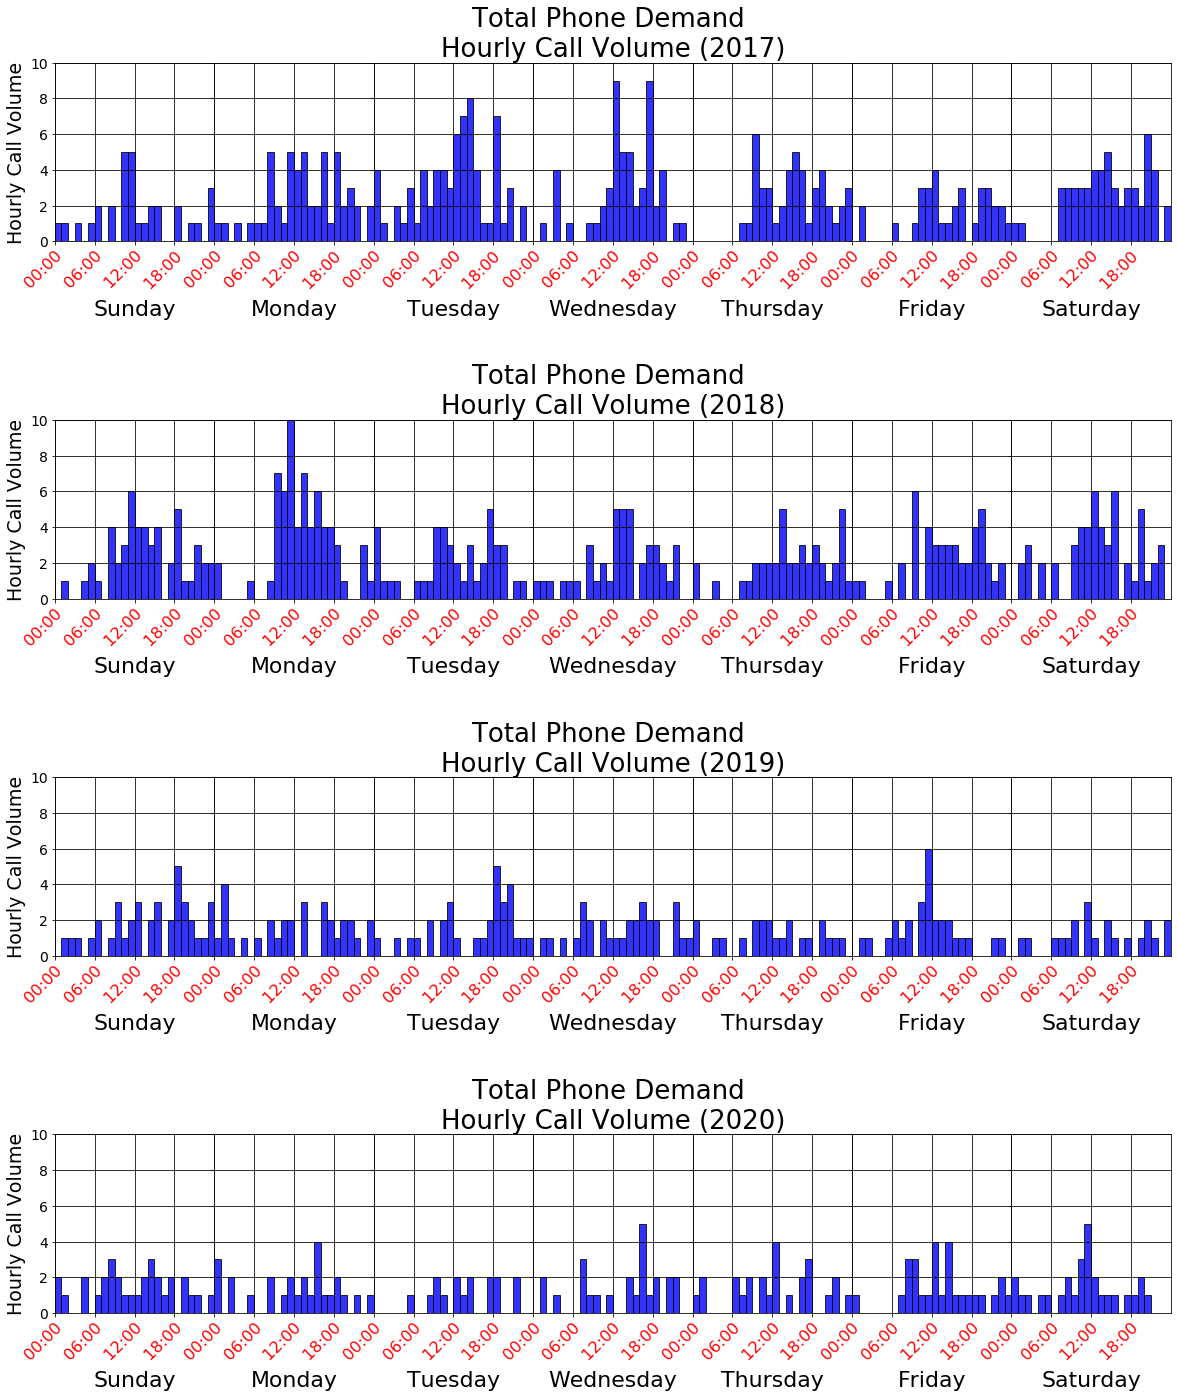

In [31]:
# Declare a year range 
year_range = year_range_all

time_ticks = [0,6,12,18] # Positional ticks for time labels 
time_labels = [' 00:00',' 06:00',' 12:00',' 18:00'] # Hourly time labels. Creates four divisions every six hours  

# Create a subplot to display the Hourly Call Volume of Total Phone Demand by year
fig, ax = plt.subplots(len(year_range), 7, figsize=(20,23), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) 

for l in range(len(year_range)):
    Hours_Phone_yearly = Phone_dict[l]
    
    for j in range(len(DOW)):
        for i in range(0, len(Hours_Phone_yearly[j])): 
            Hours_Phone_yearly[j][i] = int(Hours_Phone_yearly[j][i]) 
        Hours_Phone_yearly[j].sort() # Order the hours from least to greatest
    
        counts, bins, bars = ax[l, j].hist(x=Hours_Phone_yearly[j], bins=range(25), color='blue', edgecolor='black', 
                                           alpha=0.8, rwidth=1) # Phone Demand histgram
        ax[l,j].grid(True, color='k') # Create a grid
        ax[l,j].set_xlabel(DOW[j], fontsize=22) # Passes index j sets day of the week as the x-lablel
        ax[l,j].margins(x=0) # Removes gaps between x-ticks
    
        ax[l,3].set_title('Total Phone Demand \n'+'Hourly Call Volume'+' ' +'('+str(year_range[l])+')', fontsize=26)
        ax[l,0].set_ylabel('Hourly Call Volume', fontsize=19)
        
        plt.sca(ax[l, j]) # Updatedes current figure to the parent of ax
        plt.xticks(time_ticks, time_labels, color='red', rotation=45, fontsize=16, ha='right', rotation_mode='anchor') 
        plt.yticks(fontsize=14)
        plt.ylim([0,10])
        plt.plot(counts,alpha=0)

## The Distribution of Total Phone Demand can be visualized on the hour over an <br> aggregate week

**2017** - Tuesday and Wednesday had prominent levels of Phone Demand that were localized 
at two peaks to approximately 1200 and 1800 hrs. Friday presents itself similarly but on a smaller scale.  
        
    • Sunday, Thursday and Friday have Hourly Call Volume distributions that appear to pick up and decline in Phone Demand 
    at an even and gradual fashion. Spread of the data resembles Gaussian bell-curves. 
        
    • Monday and Saturday are fairly equal in Daily Call Volume and present similar distributions. There does not appear 
    to be any particular bias towards specific hours for Phone Demand just large blocks of demand.

****

**2018** - The peak day of activity has shifted to Monday. The peak hour of demand at 1100 hrs totaling 10 calls for the year.
    
    • Sets the record for most common time for Phone Demand on a given day - confirms the 'Medical Monday' stereotype.
    • A secondary peak occurs at midnight between Monday and Tuesday.
    • Sunday, Tuesday, Wednesday, Thursday Friday and Saturday possess similar peak hours of Phone Demand localized around 
    two peaks: late morning/early afternoon and mid to late afternoon respectively.
    • The peaks manifest themselves within a +/- 1hr tolerance of 1200 and 1800 hrs. 

****

**2019** - Sunday and Tuesday contain prominent peaks near 1800 hrs. Friday has a peak of Phone Demand around 1100 hrs.
    
    • Call Volume dropped by half compared to 2019 causing difficulty visualizing Hourly Call Volume Distributions by Day.
    • Most bars do not exceed 2 calls on the hour over the span of the year further pointing out the lack of primary demand. 
    
****

**2020** - The year finished with 23 less calls than **2019**. The Histogram reflects this drop in call volume. Compared to last year, the Hourly Call Volume is a bit sparse during some days of the week.

    • Majority of the demand for 2020 lies on Friday, Saturday and Sunday. From approximately 0800-1800 hrs at least 1 or 
    more call was received during this 10 hours time-window for the year.
    • Hourly Call Volume for Tuesday, Wednesday and Thursday does not appear as dense as the distribution of call volume 
    seen in 2019. 
    • The overall observed change in demand profile is mainly due to the lapse in Phone demand between FEB and JUN of 2020 
    from the COVID-19 pandemic.
    

# Hourly Call Volume - (Total Phone Demand)

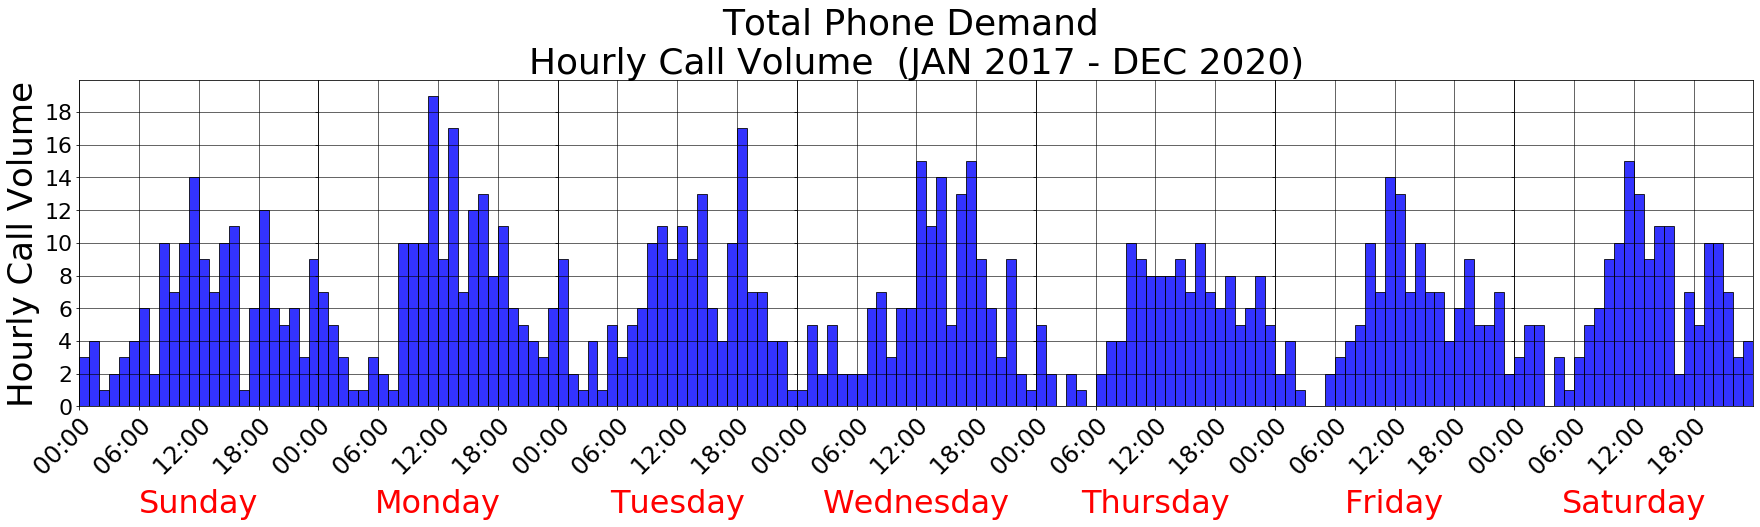

In [32]:
# Create a subplot to display the Hourly Call Volume of Total Phone Demand over the year range
fig, ax = plt.subplots(1, 7, figsize=(30,6), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) # Establish a subplot

Phone_counts = [] # Store a list of Hourly Call Volume of Total Phone Demand 

for j in range(len(DOW)):
    for i in range(0, len(Hours_Phone[j])): 
        Hours_Phone[j][i] = int(Hours_Phone[j][i]) 
    Hours_Phone[j].sort() # Order the hours from least to greatest
    
    counts, bins, bars = ax[j].hist(x=Hours_Phone[j], bins=range(25), color='blue', edgecolor='black', 
                                    alpha=0.8, rwidth=1) # Phone Demand histgram
    
    ax[j].grid(True, color='k', alpha=0.75)
    ax[j].set_xlabel(DOW[j], color='red', fontsize=32) # Passes index j sets day of the week as the x-lablel
    ax[j].margins(x=0) # Removes gaps between x-ticks
    ax[j].yaxis.set_major_locator(MaxNLocator(integer=True)) # Converts y-axis to integers
    
    ax[3].set_title('Total Phone Demand \n'+'Hourly Call Volume '+' '+'('+str.upper(df['Month Name'][0])+' '
                    +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
                    +str(year_range_all[-1])+')', fontsize=36)
    ax[0].set_ylabel('Hourly Call Volume', fontsize=34)
    
    plt.sca(ax[j]) # Updatedes current figure to the parent of ax
    plt.xticks(time_ticks, time_labels, rotation=45, fontsize=24, ha='right', rotation_mode='anchor') # x-axis tick marks
    plt.yticks(fontsize=22)
    
    # Plot a hidden line of the Hourly Call Volume counts
    plt.plot(counts,alpha = 0)
    
    Phone_counts.append(list(counts))
    
# Store the Total Phone Demand Houry Call Volume data for each day as a nested list 
y_temp_Phone = [] 

# Iterate through each subplot and extract the counts of the Hourly Call Volume 
for j in range(len(DOW)):
    line = ax[j].lines[0] # Iterate through each subplot   
    y = line.get_ydata() # Get the count data from the hidden line 
    y_temp_Phone.append(y.tolist()) # Save the data and access each day by indexing through the sublists 

# Declare a variable to store the data from y_temp_Phone as a continuous series of data
y_Phone = [] 

for sublist in y_temp_Phone: 
    for val in sublist: 
        y_Phone.append(val) 

primary_peaks = [] # Stores the time and freqency of the most active hour 
Phone_table_data = [] # Data in format for Dataframe
header = ['Primary Frequency','Primary Time'] # Horizontal Labels 

# Create a DataFrame for the daily primary times and their frequencies
for j in range(len(DOW)):
    primary_peaks.append([max(Phone_counts[j]),Phone_counts[j].index(max(Phone_counts[j]))])
    Phone_table_data.append(['{:2.0f}'.format(primary_peaks[j][0]),str(primary_peaks[j][1])+':00'])

primary_peaks_df = pd.DataFrame(Phone_table_data, DOW, header) # Dataframe for primary peaks 

# Create a Threshold and find the Primary and Secondary Waves of Demand

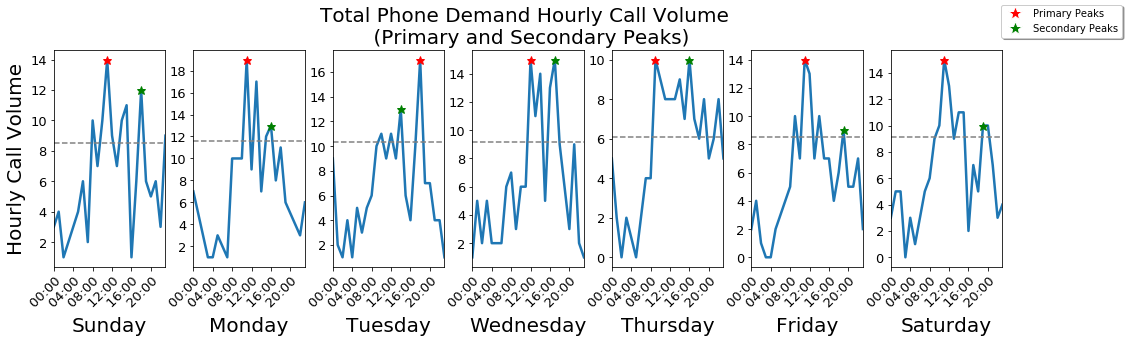

In [33]:
# Create a subplot and table that displays the primary and secondary peaks of total phone demand w.r.t. hourly call volume
peak_positions = [] # Positional indexes of the peaks listed by the DOW 
x_daily = [] # Raw data from the hourly call volume listed by the DOW 

time_ticks_alt = [0,4,8,12,16,20] # Positional ticks for time labels 
time_labels_alt = [' 00:00',' 04:00',' 08:00',' 12:00',' 16:00',' 20:00'] # Hourly time labels
df_title = ['Time Window (hrs)'] # Horizontal labels for the time differences between peaks Dataframe  
header2 = ['Secondary Frequency','Secondary Time'] # Horizontal labels for the secondary peaks Dataframe 

# Create a subplot displaying the thresholded peaks for Total Phone Demand Hourly Call Volume  
fig, ax = plt.subplots(1,7, figsize=(17,4), gridspec_kw = {'wspace':0.25, 'hspace':1})  

secondary_peaks = [] # Store the data of the secondary peaks 
primary_peak_times = [] # Store the primary peak times
secondary_peak_times = [] # Store the secondary peak times 
peak_diff = [] # Store the hourly time difference between primary and secondary peaks 
Phone_table_data2 = [] # Data in format for Dataframe

for i in range(len(DOW)):
    x = np.array(Phone_counts[i]) # Input the data 
    height = max(Phone_counts[i])*.61 # Set a threshold relative to the peak with the highest count, (aka the primary peak)
    peaks, _ = find_peaks(x, height=height) # Get the thresholded peaks 
    peak_positions.append(peaks)  
    x_daily.append(x)
    
    # Set a time selection criteria for the distance between the primary peak and potential secondary peaks 
    # Check if the thresholded peaks  are 6 or less hours away from the primary peak
    condition1 = [x for x, value in enumerate(peak_positions[i]-primary_peaks[i][0]) if value <= 6]

    if len(condition1) > 2: # Check if more than two potential secondary peaks are identified
        
        if peak_positions[i][-1:] != primary_peaks[i][1]: # Check that the primary and seconary times are different
        # If true, return the peak closest to the primary peak as the secondary peak
            secondary_peaks.append([int('{:2.0f}'.format(x_daily[i][peak_positions[i][max(condition1)]])),
                 int(peak_positions[i][max(condition1)])])
        else:     
            if peak_positions[i][-1:] == primary_peaks[i][1]: 
                secondary_peaks.append([int('{:2.0f}'.format(x_daily[i][peak_positions[i][-2]])),
                 int(peak_positions[i][-2])])
            
    if len(condition1) <= 2: # If only two peaks are returned, they are the primary and secondary peaks
        
        # Set a condition to determine the respective peaks
        # Check if the two peaks have the same count
        if x_daily[i][peak_positions[i][min(condition1)]] == x_daily[i][peak_positions[i][max(condition1)]]:
            
            # If true, set the second peak in the list as secondary
            secondary_peaks.append([int('{:2.0f}'.format(x_daily[i][peak_positions[i][max(condition1)]])),
                     int(peak_positions[i][max(condition1)])])
        else:
        
        # Otherwise, set the first peak in the list as secondary  
            secondary_peaks.append([int('{:2.0f}'.format(x_daily[i][peak_positions[i][min(condition1)]])),
                     int(peak_positions[i][min(condition1)])])
    
    # Append the hourly time difference between primary and secondary peaks 
    peak_diff.append(abs(primary_peaks[i][1]-secondary_peaks[i][1]))
    
    # Append the secondary peak data to a list for the Dataframe
    Phone_table_data2.append(['{:2.0f}'.format(secondary_peaks[i][0]),str(secondary_peaks[i][1])+':00'])
    
    # Make lists of the primary and secondary times and find the average values  
    primary_peak_times.append(primary_peaks[i][1])
    secondary_peak_times.append(secondary_peaks[i][1])
    
    primary_time_avg = round(sum(primary_peak_times)/len(DOW)*2)/2
    secondary_time_avg = round(sum(secondary_peak_times)/len(DOW)*2)/2
    
    ax[i].plot(x, lw=2.5) # Plot the Total Phone Demand Hourly Call Volume 
    #ax[i].plot(peaks, x[peaks], "*", color='r', markersize=9) # Plot all of the thresholded peaks 
    ax[i].plot(primary_peaks[i][1], primary_peaks[i][0], '*', color='r', markersize=9) # Plot thelen(DOW) Primary Peaks
    ax[i].plot(secondary_peaks[i][1], secondary_peaks[i][0], '*', color='g', markersize=9) # Plot the Secondary Peaks 
    ax[i].plot(np.ones_like(x)*max(Phone_counts[i])*.61, "--", color="gray") # Display the threshold as a vertical line 
    
    # Format and label plot 
    ax[i].set_xlabel(DOW[i], fontsize=20) 
    ax[i].margins(x=0) # Removes gaps between x-ticks
    ax[i].yaxis.set_major_locator(MaxNLocator(integer=True)) 
    
    ax[3].set_title('Total Phone Demand '+'Hourly Call Volume \n'+' '+'(Primary and Secondary Peaks)', fontsize=20)
    ax[0].set_ylabel('Hourly Call Volume', fontsize=20)
        
    plt.sca(ax[i]) # Updatedes current figure to the parent of ax 
    plt.xticks(time_ticks_alt, time_labels_alt, rotation=45, fontsize=13, ha='right', rotation_mode='anchor')
    plt.yticks(fontsize=13)
    
fig.legend(handles = [Line2D([],[], marker='*', color='w', label='Primary Peaks', markerfacecolor='r',markersize=14),
                        Line2D([],[], marker='*', color='w', label='Secondary Peaks', markerfacecolor='g',markersize=14)],
          prop={'size': 10}, shadow=True)

peak_diff_df = pd.DataFrame(peak_diff, DOW, df_title) # Dataframe for time differences between peaks 
secondary_peaks_df = pd.DataFrame(Phone_table_data2, DOW, header2) # Dataframe for secondary peaks 

In [34]:
print('Table of Total Phone Demand Primary and Secondary Peaks:')
peaks_df = pd.concat([primary_peaks_df,secondary_peaks_df,peak_diff_df],axis=1)
peaks_df

Table of Total Phone Demand Primary and Secondary Peaks:


Primary Frequency Primary Time Secondary Frequency Secondary Time  \
Sunday                   14        11:00                  12          18:00   
Monday                   19        11:00                  13          16:00   
Tuesday                  17        18:00                  13          14:00   
Wednesday                15        12:00                  15          17:00   
Thursday                 10         9:00                  10          16:00   
Friday                   14        11:00                   9          19:00   
Saturday                 15        11:00                  10          19:00   

           Time Window (hrs)  
Sunday                     7  
Monday                     5  
Tuesday                    4  
Wednesday                  5  
Thursday                   7  
Friday                     8  
Saturday                   8

## The Distribution of Total Phone Demand can be visualized on the hour over an <br> aggregate week 

The histogram shown two figures above represents the hourly phone demand call volume as an aggregate week while the preceding figure is an interpretation of the data in terms of the primary and secondary peaks of demand.

The Red and Green stars signify the primary and secondary peaks of phone demand per day respectively. The primary peak of demand always corresponds to the highest hourly call volume. The secondary peak is not necessarily the peak with the second highest hourly call volume but is identified based off the height and position with respect to the primary peak.  
    
    • Points were initially thresholded relative to the maximum call volume per day of the week - In this case, peaks with 
    61% of the height relative to the max peak value were passed through.
    • Two or more points make it past the threshold including the primary peak of demand for each iteration.
    • Based on a series of criterion relative to time, the secondary peak was determined in relation to the primary peak.
    • If the peaks are 6 hours or less away from the primary peak and there are more than 2 peaks that pass the threshold,
    select the furthest peak.  
    
    • If two peaks cross the threshold, they must be the primary and secondary peaks. Determine the order:
    • If the first peak is equal or greater than the second peak, the first peak is primary followed by the secondary peak.
    • If the first peak is less than the second, the first peak is secondary followed by the primary peak.

6 of the 7 days of the week present the primary peak before the secondary peak with the exception of Tuesday.
    
    • From left to right, the first peak is always the first wave and the second peak is always the second wave of demand.
    • The window of time between these two peaks is about 6 hours on average. 
    • Tuesday and Thursday are the only two days to have less than a 6 hour separation between peaks.
    • From Friday - Monday the primary peak of demand is at 1100 hrs. 

Taking these results into account, officers of the volunteer corps can better ascertain the optimal windows of demand to staff crews on daily. Also note that each time window has flexibility.

    • In some cases the start times for shifts in theory would start 3 hours prior to the primary wave of demand. 
    The greatest rate of change in hourly call volume intersects the call volume threshold on the LHS the primary 
    wave curve.

****

Reference the Gaussian KDE and Prophet models for further interpretability of phone demand waves and windows.

# Hourly Call Volume by Year - (Met and Unmet Phone Demand)

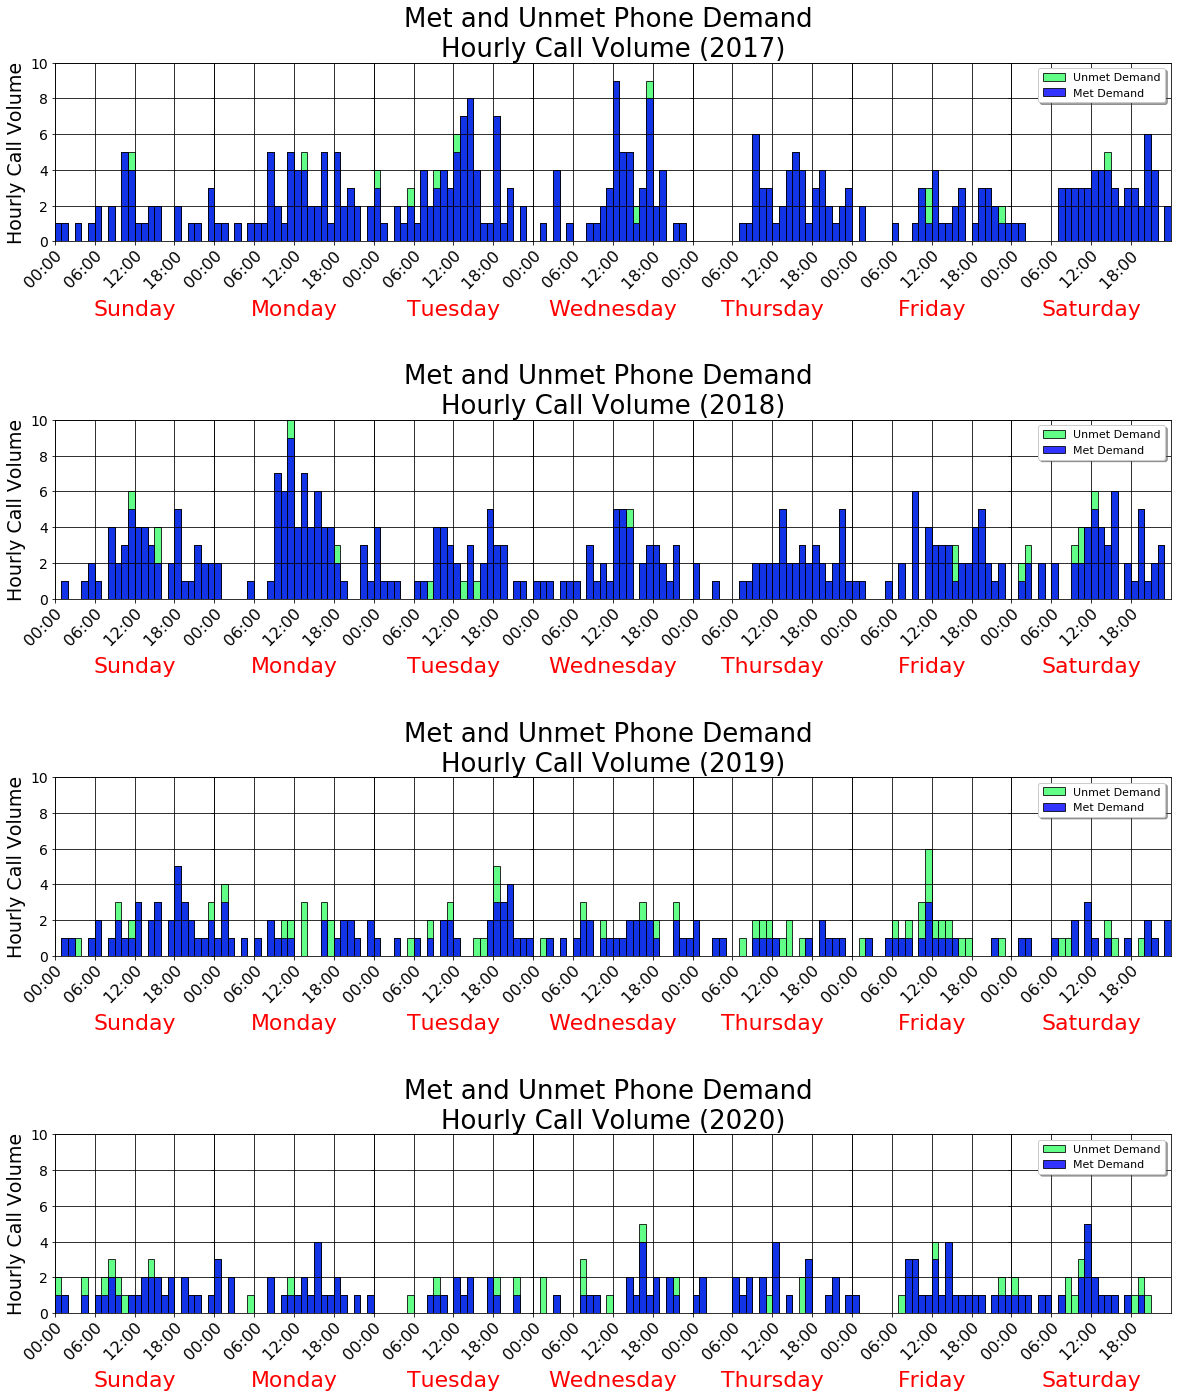

In [35]:
# Create a subplot to display the Hourly Call Volume of Met and Unmet Phone Demand by year
fig, ax = plt.subplots(len(year_range), 7, figsize=(20,23), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) 

for l in range(len(year_range)):

    Hours_Phone_yearly = Phone_dict[l] 
    Hours_Phone_Met_yearly = Phone_Met_dict[l]
        
    for j in range(len(DOW)):
        for i in range(0, len(Hours_Phone_yearly[j])): 
            Hours_Phone_yearly[j][i] = int(Hours_Phone_yearly[j][i]) 
        Hours_Phone_yearly[j].sort() # Order the hours from least to greatest
        
        for i in range(0, len(Hours_Phone_Met_yearly[j])): 
            Hours_Phone_Met_yearly[j][i] = int(Hours_Phone_Met_yearly[j][i]) 
        Hours_Phone_Met_yearly[j].sort() # Order the hours from least to greatest
        
        ax[l,j].hist(x=Hours_Phone_yearly[j], bins=range(25), color='#39ff69', edgecolor='black', 
                     alpha=0.8, rwidth=1, label='Unmet Demand') # Unmet Phone Demand histgram
        ax[l,j].hist(x=Hours_Phone_Met_yearly[j], bins=range(25), color='blue', edgecolor='black', 
                     alpha=0.8, rwidth=1, label='Met Demand') # Met Phone Demand histogram
        
        ax[l,j].grid(True, color='k') # Create a grid
        ax[l,j].set_xlabel(DOW[j], color='red', fontsize=22) # Passes index j sets day of the week as the x-lablel
        ax[l,j].margins(x=0) # Removes gaps between outer tick marks and figure
         
        ax[l,3].set_title('Met and Unmet Phone Demand \n'+'Hourly Call Volume '+'('+str(year_range[l])+')', fontsize=26)
        ax[l,0].set_ylabel('Hourly Call Volume', fontsize=19)
    
        plt.sca(ax[l,j]) # Updatedes current figure to the parent of ax
        plt.xticks(time_ticks, time_labels, rotation=45, fontsize=16, ha='right', 
                   rotation_mode='anchor') # x-axis tick marks
        plt.ylim([0,10])
        plt.yticks(fontsize=14)
     
    ax[l, 6].legend(prop={'size': 11}, shadow=True)

## The Distribution of Met and Unmet Phone Demand can be visualized on the hour over an aggregate week

On peak and off peak occurrences of Unmet Phone Demand were identified and noted in the comments below.

The label was determined based off the aggregate Met and Unmet Phone Demand Hourly Call Volume figure below (not above). <br>
In general: Hourly Call Volume >= 6 is 'on peak' and Hourly Call Volume < 6 is 'off peak'. 
    
    • For borderline cases where Hourly Call Volume is about or equal to 6, the neighboring Hourly Call Volumes 
    were considered.
    
    • Label was 'on peak' if neighboring Hourly Call Volumes were equal or less than the Hourly Call Volume in question.
    • Label was 'off peak' if neighboring Call Volumes were greater than the Hourly Call Volume in question.
    • This is a quick approach for labeling. An automated method will be implemented in the future.  

General Takeaways: Unmet Phone Demand was initially infrequent. 

    • In 2017, 2 out of 12 missed calls occurred during off peak hours. 
    • In 2018, 6 out of 17 missed calls occurred during off peak hours.
    • Tuesday was the common day for both years to have off peak Unmet Demand. 1 missed call in 2017 and 2 missed calls 
    in 2018.
    
    • All Unmet Demand for Friday of 2018 was localized to off peak hours only. Total of 2 missed calls.
    • All remaining off peak Unmet Demand occurred on Wednesday (1) for 2017 and Saturday (2) for 2018.  
    • No Unmet Demand occurred on a single Thursday in either year.

On peak Unmet Demand 2017: Sunday (1), Monday (1), Tuesday (3), Wednesday (1), Friday (3), Saturday (1) - Total 10 <br> 
On peak Unmet Demand 2018: Sunday (3), Monday (2), Tuesday (1), Wednesday (1), Saturday (4) - Total 11 

    • The pattern suggests that off peak calls were missed by chance.
    • The caller could have cancelled if the ambulance was out on another call or they reconsidered their emergency.
    • The remaining on peak calls could have gone unmet for the same reason but just as well could have been missed due
    to the rare occasion of a lack of a scheduled duty crew during peak hours of operation.

Unmet demand started making up a disparate proportion of the Total Phone Demand. <br>
    
    • In 2019, 19 out of 53 calls missed calls occurred during off peak hours. 
    • In 2019, 34 out of 53 calls missed calls occurred during on peak hours. 
    • Every day of the week had some form on peak and off peak Unmet Demand.

Off peak Unmet Demand 2019: Sunday (2), Monday (3), Tuesday (4), Wednesday (3), Thursday (1), Friday (4), Saturday (2) <br>
On peak Unmet Demand 2019: Sunday (2), Monday (6), Tuesday (3), Wednesday (3), Thursday (7), Friday (10), Saturday (3) <br>

On Monday, Thursday and Friday there was a higher likelihood that Unmet Demand occurred during on peak hours. <br> 
Among completed years 2019 was the worst performing one. The were some hours that had Phone Demand that went completely
unmet the entire year - hence the scattered green bars across the graph. <br> 

Some examples that highlight this case are: Monday at 1300 (3) on peak and Thursday at 1400 (2) on peak.
    
    • Friday was the worst performing day of the year where 14 of 28 of the calls were missed. 
    • Friday also had the highest Hourly Call Volume which occurred at 1100 hrs. 
    • The Total Phone Demand was 6 and the Unmet Phone Demand was 3 making these the highest Hourly Call Volumes for their
    respective categories. Unfortunately, the percentage of Unmet Demand was 50% making this the worst performing day and 
    hour of 2019. 

Yearly Details <br> 
**2017** - Any instance of Unmet Demand Phone Demand on a given day does not occur more than once on the same hour. <br>
The only exception to this observation is Friday at 1100 hrs where 2 out of the 3 calls were missed. 

    • Sunday, Monday and Saturday each have 1 missed call for the entire year and are on peak times of demand.
    Missed calls occurred at 1100, 1300 and 1400 hours respectively which fall late morning/early afternoon.  
    
    • Tuesday had 4 missed calls scattered throughout the morning at 0000 (on peak), 0500 (off peak), 0900 (off peak) and 
    1200 (on peak) hrs. 
    
    • Wednesday had 2 missed calls in the evening one at 1500 (off peak) and one at 1700 hrs (on peak).
    • Thursday had no missed calls.
    • Friday had 3 on peak missed calls, two in the late morning at 1100 and one a night at 2200 hrs. 

**2018** - Most instances of Unmet Demand on a given day do not occur more than once on the same hour. <br>
Exceptions: Sunday at 1500 (2), Friday 1500 (2), Saturday at 1000 (2)   

    • Sunday had 3 on peak missed calls, one at 1100 and two at 1500 hrs.
    • Monday had 2 on peak missed calls, one at 1100 and one at 1800 hrs.
    • Tuesday had 3 missed calls one at 0800 (off peak), one at 1300 (on peak) and one at 150 0 hrs (off peak). 
    • Wednesday had 1 on peak missed call at 1400 hrs. 
    • Thursday had no missed calls.
    • Friday had two off peak missed calls at 1500 hrs.   
    • Saturday had 2 off peak missed calls, one at 0100 and one at 0200 hrs and three on peak missed calls, one at 0900
    two at 1000 and one at 1200 hrs.

**2019** - Several instances of Unmet Demand on a given day occur more than once on the same hour. <br>
Examples: Monday at 1300 (3), Monday at 1700 (2), Tuesday at 1800 (2), Thursday at 1400 (2), Friday at 1000 (2),
and Friday at 1100 (3), 

    • Sunday had 4 missed calls, one at 0300 (off peak), one at 0900 (off peak), one at 1100 (on peak) 
    and one at 2300 (on peak) 

    • Monday had 9 missed calls, one at 0100 (off peak), one at 1000 (on peak), one at 1100 (on peak), 
    three at 1300 (on peak), one at 1600 (on peak), two at 1700 hrs (off peak).

    • Tuesday had 7 missed calls, one at 0500 (off peak), one at 0800 (off peak), one at 1100 (on peak), 
    one at 1500 (off peak), one at 1600 (off peak), and two at 1800 hrs (on peak).    

    • Wednesday had 6 missed calls, one at 0100 (off peak), one at 0700 (off peak), one at 1000 (off peak), 
    one at 1600 (on peak), one at 1800 (on peak) and one at 2100 hrs (on peak).

    • Thursday had 8 missed calls, one at 0700 (off peak), one at 0900 (on peak), one at 1000 (on peak), 
    one at 1100 (on peak), one at 1300 (on peak), two at 1400 (on peak), and one at 1600 hrs (on peak).

    • Friday had 14 missed calls, one at 0100 (off peak), one at 0600 (off peak), one at 0800 (off peak), 
    two at 1000 (on peak), three at 1100 (on peak), one at 1200 (on peak), one at 1300 (on peak), 
    one at 1400 (on peak), one at 1600 (off peak), one at 1700 (on peak), one at 2200 hrs (on peak).     

    • Saturday had 5 missed calls, one at 0700 (off peak), one at 0800 (off peak), one at 1400 (on peak), 
    one at 1500 (on peak) and one at 1900 hrs (on peak).
    
**2020** - Among the 34 Unmet Phone Demand calls, 6 occurred after **APR 2020**. The remaining 28 calls were missed prior to the addition of a 3rd party ambulance to handle excess demand. Compared to 2019, there were fewer instances of Unmet Demand that occurred more than once on the same hour.

    • These events were: Wednesday at 0100 (2), Wednesday at 0700 (2), and Saturday at 0800 (2) 
    • All remaining instances of Unmet Demand only happened with respect to the given Day and Hour of the event. 
   
For the sake of simplicity, only the daily totals of Unmet Demand for the year will be listed for 2020 not the times.  

    • Sunday (7)
    • Monday (2)
    • Tuesday (4)   
    • Wednesday (7) 
    • Thursday (3)
    • Friday (3)
    • Saturday (8)
    
****
    
**Note:** During 2020, 21 of 34 missed calls fell between the 12 hour window of 0600-1800 hrs. 
    

# Hourly Call Volume -  (Met and Unmet Phone Demand)

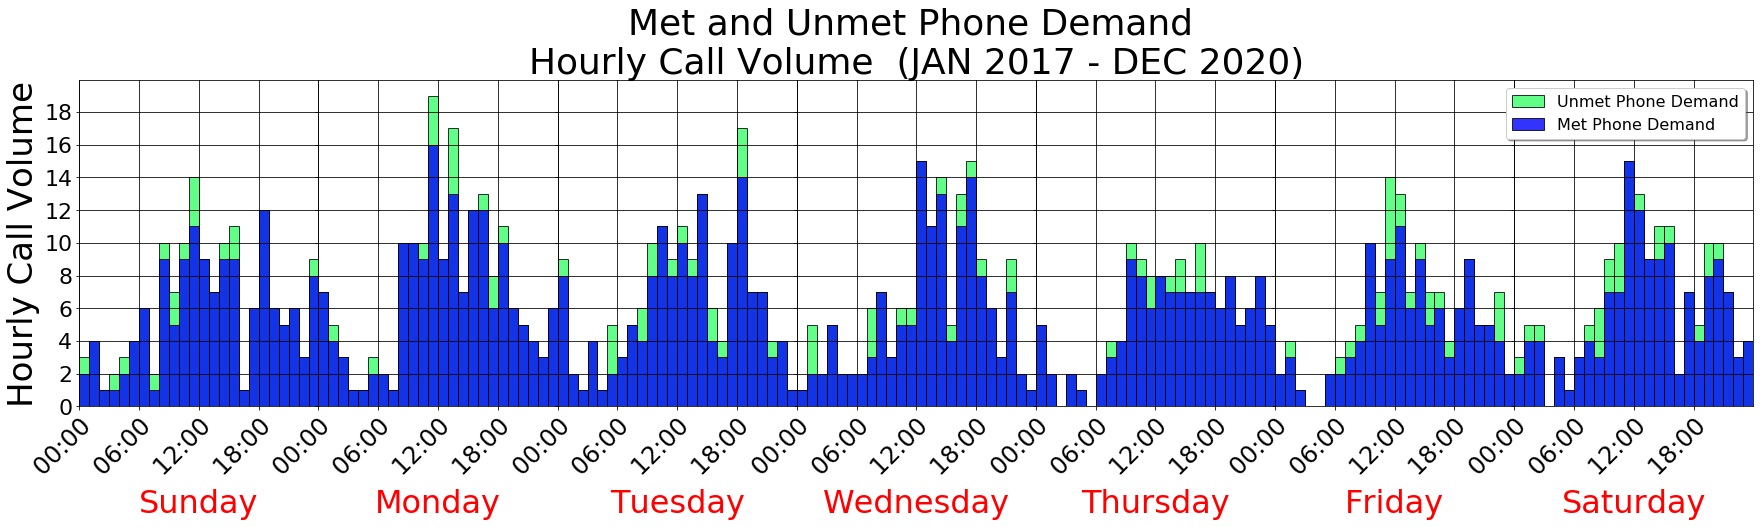

In [36]:
# Create a subplot to display the Hourly Call Volume of Met and Unmet Phone Demand over the year range
fig, ax = plt.subplots(1, 7, figsize=(30,6), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) # Establish a subplot

for j in range(len(DOW)):
    for i in range(0, len(Hours_Phone_Met[j])): 
        Hours_Phone_Met[j][i] = int(Hours_Phone_Met[j][i]) 
    Hours_Phone_Met[j].sort() # Order the hours from least to greatest
    
    ax[j].hist(x=Hours_Phone[j], bins=range(25), color='#39ff69', edgecolor='black', 
               alpha=0.8, rwidth=1, label='Unmet Phone Demand') # Unmet Phone Demand histgram
    ax[j].hist(x=Hours_Phone_Met[j], bins=range(25), color='blue', edgecolor='black', 
               alpha=0.8, rwidth=1, label='Met Phone Demand') # Met Phone Demand histogram
    
    ax[j].grid(True, color='k') # Create a grid
    ax[j].set_xlabel(DOW[j], color='red', fontsize=32) # Passes index j sets day of the week as the x-lablel
    ax[j].margins(x=0) # Removes gaps between outer tick marks and figure
    ax[j].yaxis.set_major_locator(MaxNLocator(integer=True)) # Converts y-axis to integers
    
    ax[3].set_title('Met and Unmet Phone Demand \n'+'Hourly Call Volume '+' '+'('+str.upper(df['Month Name'][0])+' '
                    +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
                    +str(year_range_all[-1])+')', fontsize=36)
    ax[0].set_ylabel('Hourly Call Volume', fontsize=34)
    
    plt.sca(ax[j]) # Updatedes current figure to the parent of ax
    plt.xticks(time_ticks, time_labels, rotation=45, fontsize=24, ha='right', rotation_mode='anchor') # x-axis tick marks
    plt.yticks(fontsize=22)

ax[j].legend(prop={'size': 16}, shadow=True) 
plt.show()

## The Distribution of Met and Unmet Phone Demand can be visualized on the hour over an aggregate week

**As of MAY 2020:** <br>
The window of 1700-0000 hrs had no instances of Unmet Phone Demand for hour years on Sundays and Thursdays.

**Note:** One exception of a missed on peak call at 2300 hrs on a Sunday of 2019. According to the data, this pattern indicates that these days and times were staffed and managed most effectively. Looking at the aggregate collection of Met and Unmet Phone Demand, frequent occurrences of Unmet Phone Demand 
(2 or more missed calls on the hour), occurred during on peak times.

    • Common examples which recurred on multiple days of the week over time were 1000, 1100, 1200 and 1800 hrs. 

# Hourly Call Volume by Year - (Radio Activity)

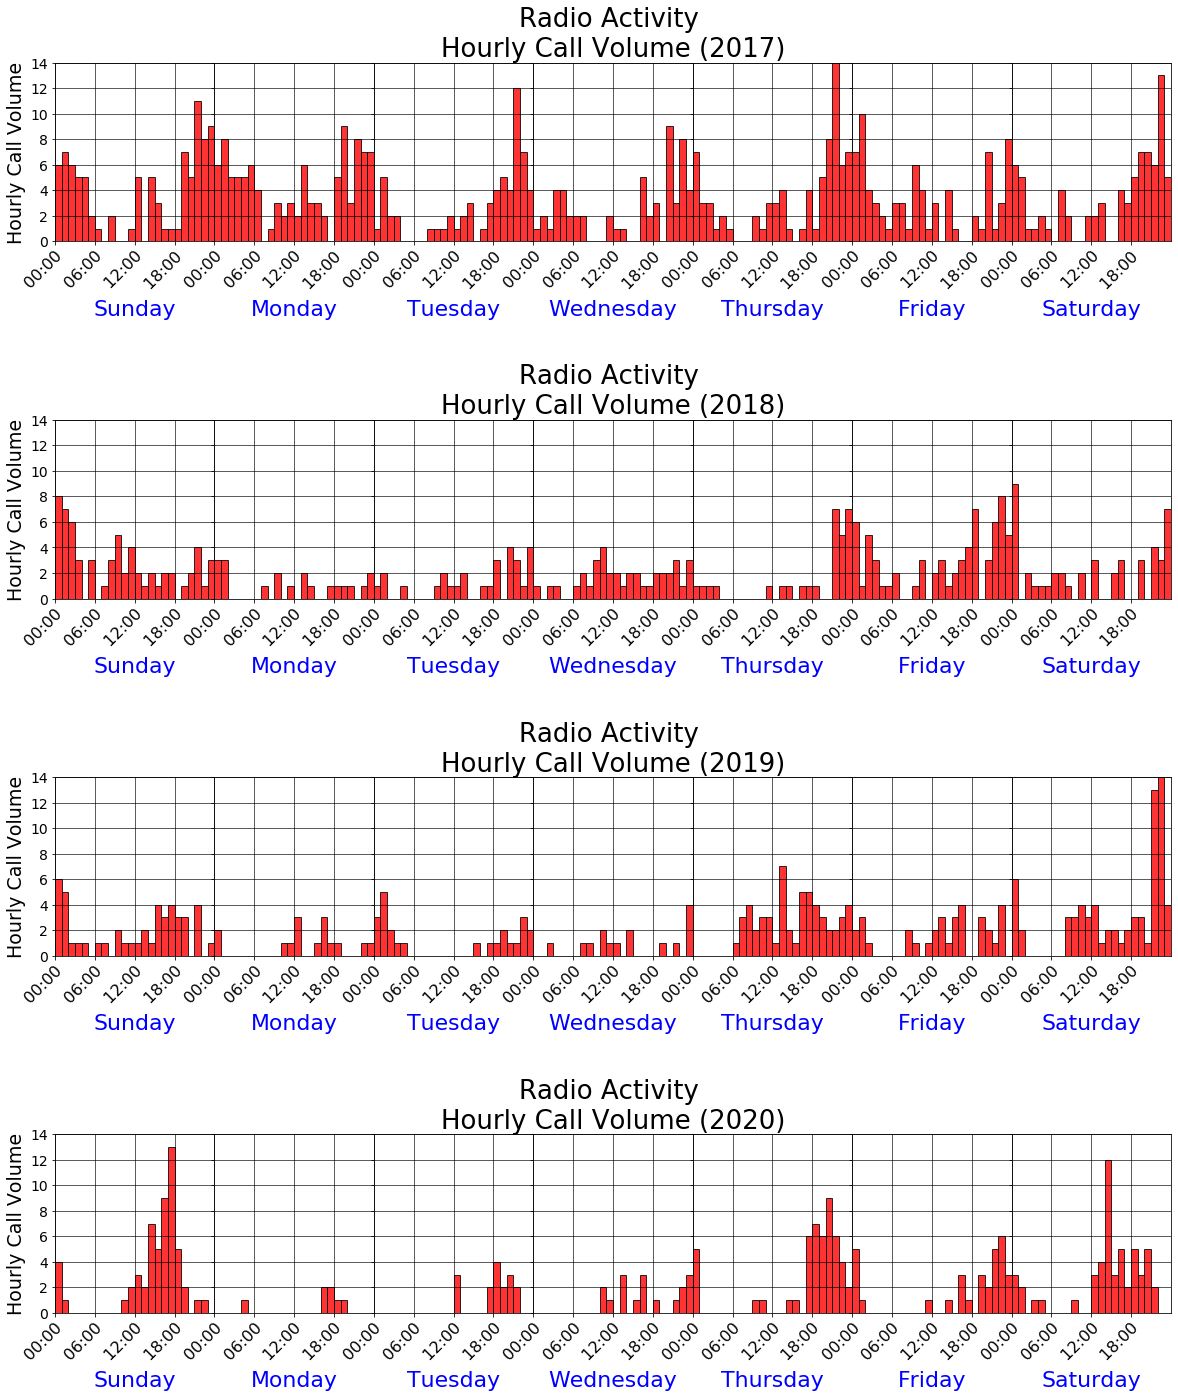

In [37]:
# Create a subplot to display the Hourly Call Volume of Radio Activity by year
fig, ax = plt.subplots(len(year_range), 7, figsize=(20,23), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True)

for l in range(len(year_range)):
    Hours_Radio_yearly = Radio_dict[l]
    
    for j in range(len(DOW)):
        for i in range(0, len(Hours_Radio_yearly[j])): 
            Hours_Radio_yearly[j][i] = int(Hours_Radio_yearly[j][i]) 
        Hours_Radio_yearly[j].sort() # Order the hours from least to greatest
    
        counts, bins, bars = ax[l,j].hist(x=Hours_Radio_yearly[j], bins=range(25), color='red', edgecolor='black', 
                                          alpha=0.8, rwidth=1) # Radio Activity histgram
        ax[l,j].grid(True, color='k', alpha=0.8)
        ax[l,j].set_xlabel(DOW[j], color='blue', fontsize=22) # Passes index j sets day of the week as the x-lablel
        ax[l,j].margins(x=0) # Removes gaps between x-ticks
    
        ax[l,3].set_title('Radio Activity \n'+'Hourly Call Volume '+'('+str(year_range[l])+')', fontsize=26)
        ax[l,0].set_ylabel('Hourly Call Volume', fontsize=19) 
            
        plt.sca(ax[l,j]) # Updatedes current figure to the parent of ax
        plt.xticks(time_ticks, time_labels, rotation=45, fontsize=16, ha='right', rotation_mode='anchor') # x-axis tick marks
        plt.yticks(fontsize=14)
        plt.ylim([0,14])
        plt.plot(counts, alpha=0)

## The Distribution of Radio Activity can be visualized on the hour over an aggregate week 

The tabulated Hourly Call Volumes for Radio Activity are responses to calls within the 911 network by crews that are 
already scheduled and available for Phone Demand, the main source of demand for the Ambulance Service. 

**2017** - Crews responded to the most Radio Activity during the window of 1800-0000 hrs.

    • The peak Hourly Call Volumes however, varied by day.  
    • The max hour of Radio Activity occurred at 2100 hrs for three days: 
        Sunday at (11), Tuesday at (12) and Thursday at (14)
    
    • The remaining totals were: 
        Monday 1900 at (9), Wednesday at 2000 (9), Friday at 0100 (10) and Saturday at 2200 hrs (13)

Sunday nights into Monday early mornings, 5 or more calls were responded to on every hour of the night. 
Supports theory of sufficient staffing for Sunday evenings because of high rate of Met Phone Demand and Radio Activity.

Thursday nights into Friday early mornings were also very active nights containing 5 or more Radio Activity responses
on every hour of the night. Likewise the same staffing theory as Sunday evenings holds true.

**2018** - Crews responded to the most Radio Activity during the window of 1800-0000 hrs.
    
    • The peak Hourly Call Volumes however, varied by day.  
    • The max hour of Radio Activity occurred at 0000 hrs for three days: Sunday at (8), Monday at (3) and Saturday at (7)
    • The max hour of Radio Activity occurred at 2300 hrs for two days: Tuesday (4) and Thursday (7)
    • The remaining totals were: Wednesday at 1000 (4) and Friday at 2200 hrs (8)
    • While yearly Call Volume dropped by 251 calls in 2018, Thursday, Friday and Saturday nights made up most 
    Radio Activity during the 1800-0000 hr window for the year.    

**2019** - The most common hour for response to Radio Activity for each day of the week was: 

    • Sunday at 0000 hrs (6)
    • Monday at 1200 hrs (3)
    • Tuesday at 0100 hrs (5)
    • Wednesday at 2300 (4)
    • Thursday at 1300 hrs (7)
    • Friday at 2200 hrs (4)  
    • Saturday at 2200 hrs (14)

Peak call volumes have dropped significantly. Saturday night into Sunday early morning was the most active period 
for Radio Activity. 

    • While Radio Activity remained comparable to 2018, Radio Activity became more concentrated to the weekends. 
    Case in point Saturday maxing out at 13 calls at 2100 hrs and 14 calls at 2200 hrs making this the busiest pair of 
    consecutive hours to date.

**2020** - Response to Radio Activity has restructured itself completely under the new operations since **OCT 2020**. Crews have been scheduled recurring weekly shifts and the Hourly Call Volume reflects that. <br>

The most common hour for response to Radio Activity for each day of the week was: 

    • Sunday at 1700 hrs (13)
    • Monday at 1700 hrs (2)  
    • Tuesday at 1800 hrs (4)  
    • Wednesday at 1400 hrs (3)
    • Thursday at 2000 hrs (9)
    • Friday at 2200 hrs (6)  
    • Saturday at 1400 hrs (12)

Peak call volumes have shifted to Sunday and Saturady afternoons, and Thursday and Friday evenings relatively exclusively. 

# Hourly Call Volume - (Radio Activity)

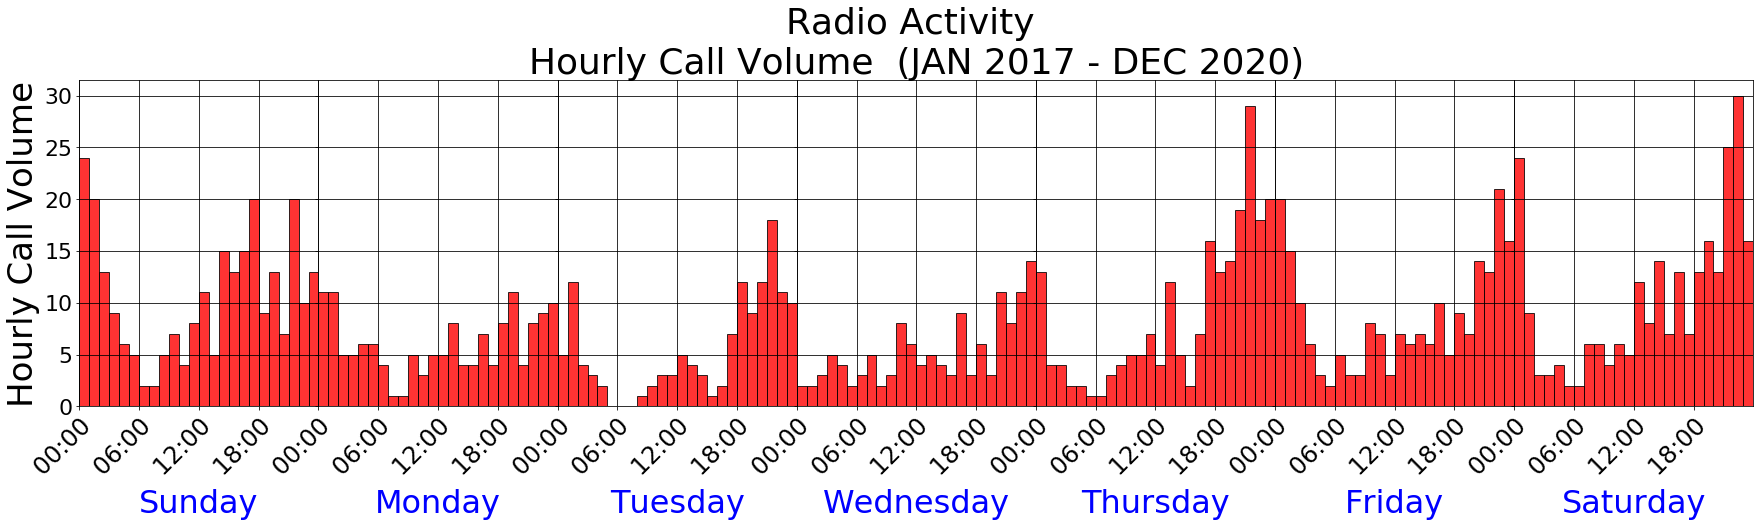

In [38]:
# Create a subplot to display the Hourly Call Volume of Radio Activity over the year range 
fig, ax = plt.subplots(1, 7, figsize=(30,6), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) #Establish a subplot

Radio_counts = [] # Store a list of the Hourly Call Volume of Radio Activity 

for j in range(len(DOW)):
    for i in range(0, len(Hours_Radio[j])):
        Hours_Radio[j][i] = int(Hours_Radio[j][i]) 
    Hours_Radio[j].sort() # Order the hours from least to greatest
    
    counts, bins, bars = ax[j].hist(x=Hours_Radio[j], bins=range(25), color='red', edgecolor='black', 
                                    alpha=0.8, rwidth=1) # Radio Activity histgram
    ax[j].grid(True, color='k')
    ax[j].set_xlabel(DOW[j], color='blue', fontsize=32) # Passes index j sets day of the week as the x-lablel
    ax[j].margins(x=0) # Removes gaps between outer tick marks and figure
    
    ax[3].set_title('Radio Activity \n'+'Hourly Call Volume '+' '+'('+str.upper(df['Month Name'][0])+' '
                    +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
                    +str(year_range_all[-1])+')', fontsize=36)
    ax[0].set_ylabel('Hourly Call Volume', fontsize=34)
    
    plt.sca(ax[j]) # Updatedes current figure to the parent of ax
    plt.xticks(time_ticks, time_labels, rotation=45, fontsize=24, ha='right', rotation_mode='anchor') # x-axis tick marks
    plt.yticks(fontsize=22)
    
    # Plot a hidden line of the Hourly Call Volume counts
    plt.plot(counts,alpha=0)
    
    Radio_counts.append(list(counts))

# Store the Radio Activity Houry Call Volume data for each day as a nested list    
y_temp_Radio = []     

# Iterate through each subplot and extract the counts of the Hourly Call Volume
for j in range(len(DOW)):
    line = ax[j].lines[0] # Iterate through each subplot
    y = line.get_ydata() # Get the count data from the hidden line
    x = line.get_xdata() # Save the data and access each day by indexing through the sublists 
    y_temp_Radio.append(y.tolist())

# Declare a variable to store the data from y_temp_Phone as a continuous series of data
y_Radio = [] 
  
for sublist in y_temp_Radio: 
    for val in sublist: 
        y_Radio.append(val) 

Radio_pairs = [] # Stores the time and freqency of the most active hour
temp_data = {}
Radio_table_data = [] # Data in format for Dataframe
header = ['Primary Frequency','Primary Time'] # Horizontal Labels 

# Create a DataFrame for the daily primary times and their frequencies
for j in range(len(DOW)):
    Radio_pairs.append([max(Radio_counts[j]),Radio_counts[j].index(max(Radio_counts[j]))])
    temp_data[j] = ['{:3.0f}'.format(Radio_pairs[j][0]),str(Radio_pairs[j][1])+':00']

    Radio_table_data.append(temp_data[j])
radio_stats_df = pd.DataFrame(Radio_table_data, DOW, header) # Dataframe for primary peaks 

In [39]:
print('Table of the Daily Radio Activity Primary Peaks:')
radio_stats_df

Table of the Daily Radio Activity Primary Peaks:


Primary Frequency Primary Time
Sunday                   24         0:00
Monday                   11         0:00
Tuesday                  18        21:00
Wednesday                14        23:00
Thursday                 29        21:00
Friday                   21        22:00
Saturday                 30        22:00

## The Distribution of Radio Activity can be visualized on the hour over an aggregate week

**As of DEC 2020:** <br>
The peak time for Radio Activity responses generally occurred after 1800 hrs and sometimes lasted 3-6 hours past 0000 hrs. <br>
Looking at the aggregate week plot, it's clear that Thursday, Friday and Saturday nights were optimal in responses. 

The most frequent Hourly Call Volume for each day was as follows: 
    
    • Sunday at 0000 hrs (24)
    • Monday at 0000 hrs (11)
    • Tuesday at 2100 hrs (18)
    • Wednesday at 2300 hrs (14)
    • Thursday at 2100 hrs (29) 
    • Friday at 2200 hrs (21) 
    • Saturday at 2200 hrs (30)

Sunday and Monday all had peak Hourly Call Volumes at 0000 hrs. <br>
Tuesday and Thursday had peak Hourly Call Volumes at 2100 hrs. <br> 
Friday and Saturday had peak Hourly Call Volumes at 2200 hrs. <br>
Wednesday was unique such that the peak Hourly Call Volumes occurred at 2300 hrs. 

****

**Note:** The Hourly Call Volume peak at 2100 hrs for Thursday is an outlier relative to the neighboring counts. 

    • Visualizing the trend for the plot the peak Hourly Call Volume was projected to be 2300 hrs. 

# Hourly Call Volume by Year - (Total Phone Demand and Radio Activity)

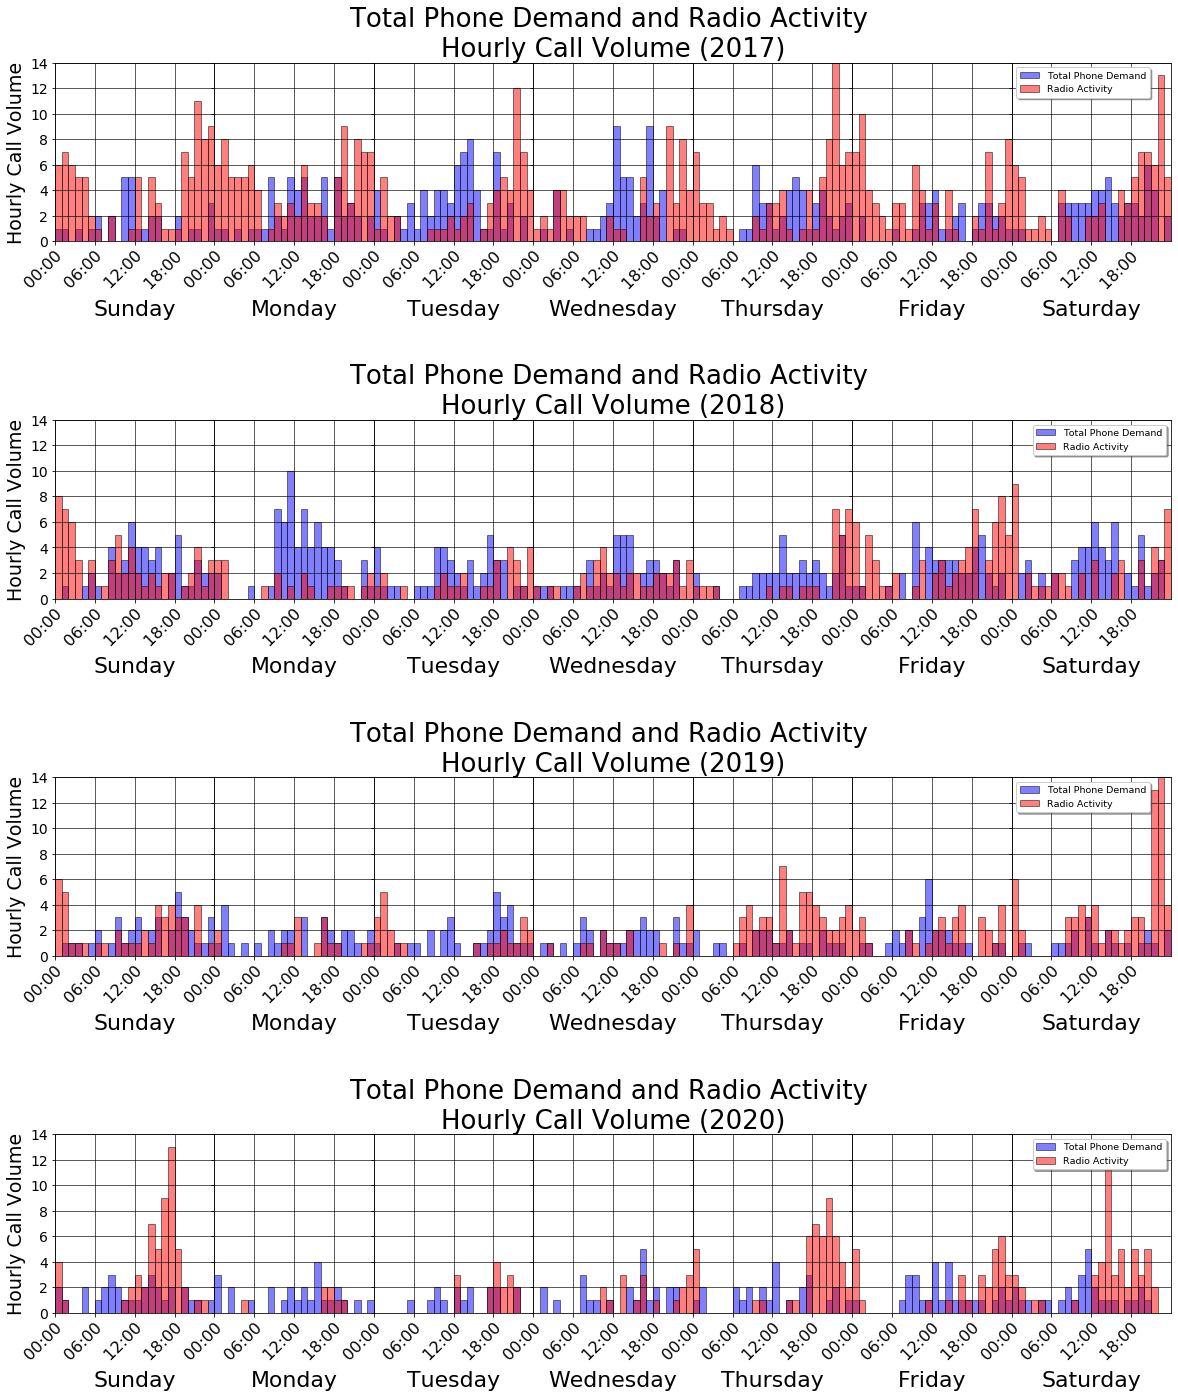

In [40]:
# Create a subplot to compare the Hourly Call Volume of Total Phone Demand and Radio Activity by year
fig, ax = plt.subplots(len(year_range), 7, figsize=(20,23), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) 

for l in range(len(year_range)):

    Hours_Phone_yearly = Phone_dict[l] 
    Hours_Radio_yearly = Radio_dict[l]
        
    for j in range(len(DOW)):
        for i in range(0, len(Hours_Phone_yearly[j])): 
            Hours_Phone_yearly[j][i] = int(Hours_Phone_yearly[j][i]) 
        Hours_Phone_yearly[j].sort() # Order the hours from least to greatest
        
        for i in range(0, len(Hours_Radio_yearly[j])): 
            Hours_Radio_yearly[j][i] = int(Hours_Radio_yearly[j][i]) 
        Hours_Radio_yearly[j].sort() # Order the hours from least to greatest
        
        ax[l,j].hist(x=Hours_Phone_yearly[j], bins=range(25), color='blue', edgecolor='black', 
                     alpha=0.5, rwidth=1, label = 'Total Phone Demand') # Phone Demand histgram
        ax[l,j].hist(x=Hours_Radio_yearly[j], bins=range(25), color='red', edgecolor='black', 
                     alpha=0.5, rwidth=1, label='Radio Activity') # Radio Activity histogram
        ax[l,j].grid(True, color='k', alpha=0.8)
        ax[l,j].set_xlabel(DOW[j], fontsize=22) # Passes index j sets day of the week as the x-lablel
        ax[l,j].margins(x=0) # Removes gaps between outer tick marks and figure
         
        ax[l,3].set_title('Total Phone Demand and Radio Activity \n'+'Hourly Call Volume '+'('+
                          str(year_range[l])+')', fontsize=26)
        ax[l,0].set_ylabel('Hourly Call Volume', fontsize=19)
        
        plt.sca(ax[l, j]) # Updatedes current figure to the parent of ax
        plt.xticks(time_ticks, time_labels, rotation=45, fontsize=16, ha='right', rotation_mode='anchor') #x-axis tick marks
        plt.ylim([0,14])
        plt.yticks(fontsize=14)
    
    ax[l, 6].legend(prop={'size': 9.5},shadow=True)

## The Distribution of Total Phone Demand and Radio Activity can be visualized on the hour over an aggregate week

Total Phone Demand is plotted in blue and Radio Activity is plotted in red. 

    • If Total Phone Demand outnumbers Radio Activity on the histogram (blue > red), Radio Activity is dark red.  
    • If Radio Activity outnumbers Total Phone Demand on the histogram (red > blue), Total Phone Demand is dark red.  
    
**2017** - There is a succinct separation between the peak Hourly Call Volume for Total Phone Demand and Radio Activity. The time which separates these two peaks is at 1800 hrs. Total Phone Demand peaks before and Radio Activity peaks after. <br>
    
    • The windows of these peaks vary by day and are most distinguishable for Sunday, Tuesday, Wednesday and Saturday. 
    • Radio Activity outnumbered Phone Demand after 1800s hrs Monday, Thursday and Friday evenings as well. 
    • On the contrary, the peak Hourly Call Volume windows for Total Phone Demand appear to be interleaved with 
    Radio Activity Hourly Call Volume. 

**2018** - Total Phone Demand peaks before 1800 hrs and Radio Activity peaks after 1800 hrs however the distinction is 
clearer on some days more so than others. <br>

    • The separation between the two call types is most prominent on Thursday, Friday and Saturday. 
    • Days with the highest Total Phone Demand and lowest Radio Activity Hourly Call Volumes were Monday and Tuesday.
    • On Sunday, Wednesday and Friday the peak Hourly Call Volume windows for Total Phone Demand appear to be interleaved 
    with Radio Activity Hourly Call Volume. 

**2019** - Yearly Call Volume for Total Phone Demand drops. The peak regions of Hourly Call Volume are harder to identify.

    • Friday is the only example of clear and separable windows of peak Hourly Call Volume which occur at 1100 and 0000 hrs 
    for Total Phone Demand and Radio Activity respectively. Note: 0000 hrs technically counts as Saturday but falls under
    Friday night Radio Activity. 
    
    • Sunday consists mainly of interleaved activity between the two call types with the exception of early Sunday morning  
    which falls under Saturday night Radio Activity.
    
    • Thursday and Saturday are the most active day for Radio Activity and outnumber every instance of Total Phone Demand
    Hourly Call Volume. 
    
**2020** - Total Phone Demand drops by 23 calls and Radio activity drops by 31 calls.

    • Radio Activity Peaks greatly outnumber Phone Demand Peaks.  
    
    • The separation between Radio activity and Phone Demand is not as prominent as previous years due to the drop in 
    overall activity.
    
    • On the busier days such as Thurs-Sun, Phone Demand peaked at or near 1200 hrs followed by a Radio Activity peaks 
    during the evening or night hours.


# Hourly Call Volume -  (Total Phone Demand and Radio Activity) 

Sunday: SpearmanrResult(correlation=-0.13690788392754336, pvalue=0.5333398281637312)

Monday: SpearmanrResult(correlation=0.0005020285283407269, pvalue=0.9981861158928127)

Tuesday: SpearmanrResult(correlation=0.1673745997136742, pvalue=0.44525730077431924)

Wednesday: SpearmanrResult(correlation=0.2629613150977086, pvalue=0.22541014899597142)

Thursday: SpearmanrResult(correlation=0.4904920263506571, pvalue=0.017490293127605708)

Friday: SpearmanrResult(correlation=0.1182661915348104, pvalue=0.5909587715714305)

Saturday: SpearmanrResult(correlation=0.22998414911593146, pvalue=0.2911094742127865)



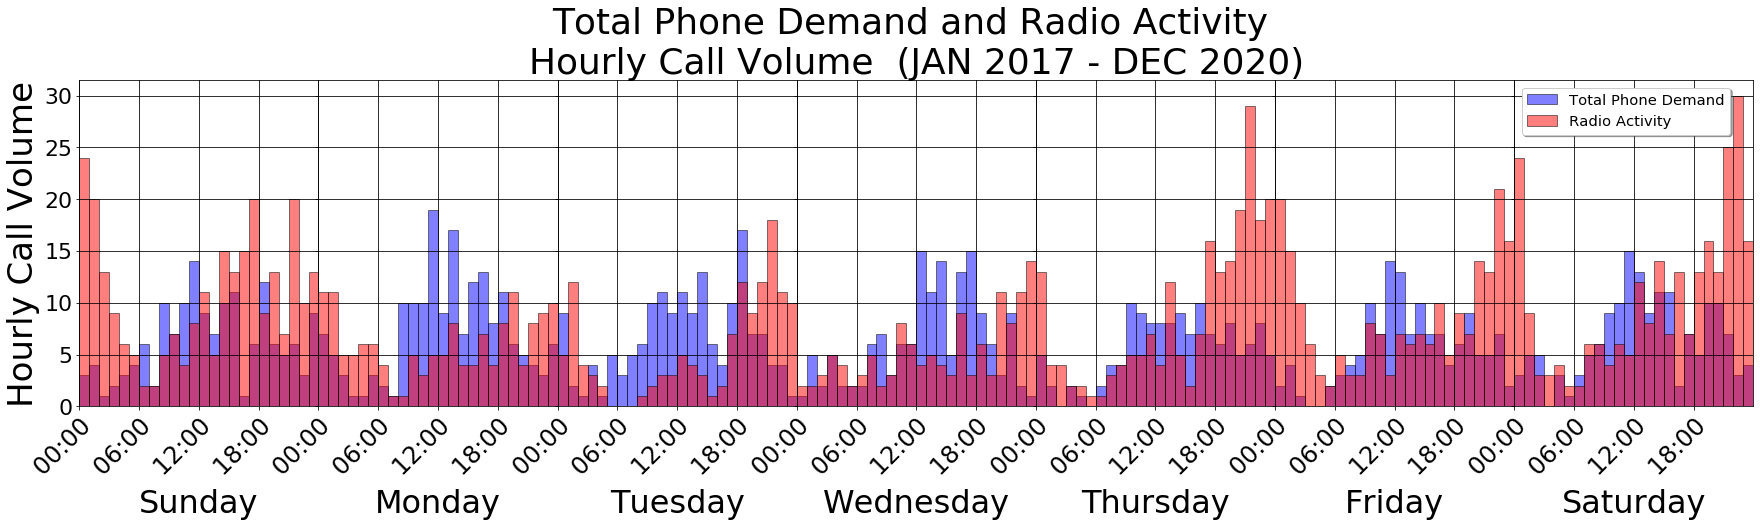

In [41]:
# Create a subplot to compare the Hourly Call Volume of Total Phone Demand and Radio Activity over the year range
fig, ax = plt.subplots(1, 7, figsize=(30,6), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) # Establish a subplot

for j in range(len(DOW)):
    ax[j].hist(x=Hours_Phone[j], bins=range(25), color='blue', edgecolor='black', 
               alpha=0.5, rwidth=1, label='Total Phone Demand') # Phone Demand histgram
    ax[j].hist(x=Hours_Radio[j], bins=range(25), color='red', edgecolor='black', 
               alpha=0.5, rwidth=1, label='Radio Activity') # Radio Activity histogram
    ax[j].grid(True, color='k')
    ax[j].set_xlabel(DOW[j], fontsize=32) # Passes index j sets day of the week as the x-lablel
    ax[j].margins(x=0) # Removes gaps between outer tick marks and figure
     
    ax[3].set_title('Total Phone Demand and Radio Activity \n'+'Hourly Call Volume '+' '+'('
                    +str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+' '+'-'+' '
                    +str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')', fontsize=36)
    ax[0].set_ylabel('Hourly Call Volume', fontsize=34)
    
    plt.sca(ax[j]) # Updatedes current figure to the parent of ax
    plt.xticks(time_ticks, time_labels, rotation=45, fontsize=24, ha='right', rotation_mode='anchor') # x-axis tick marks
    plt.yticks(fontsize=22)
    
    # Index Ranges
    start = j*24
    stop = (j*24)+23
    
    # Calculate the Spearman Correlation Coefficient for each day 
    print(DOW[j] + ":",stats.spearmanr(y_Phone[start:stop],y_Radio[start:stop]))
    print("")

ax[j].legend(prop={'size': 14.75},shadow=True)
plt.show()

## The Distribution of Total Phone Demand and Radio Activity can be visualized on the hour over an aggregate week

Spearman's Correlation was used to identify a potential relationship between Total Phone Demand and Radio Activity with respect to each day of the week over a large span of time. There is no strong indication that the call types are related by day over time. 

    • Thursday comes the closest with a 49% correlation and a p-value of 0.017 suggesting potential statistical 
    significance. Revisiting the Hourly distribution of Total Phone Demand Call Volume for Thursday, there aren't 
    any sharp increases in demand of the aggregate 24hr period, misleadingly indicating a relationship between the 
    two call types.

**Conclusion:** A lack of correlation brings to attention that crews are more likely to respond to Radio Activity during
the off peak windows of Total Phone Demand. Hence, days with more prominent separation between the peak hours of Hourly Call Volume are less correlated.

    • Case in point Monday, Tuesday, Wednesday, Friday and Saturday all have correlations of 26% or less. As the call 
    volumes appear to be more interleaved and the separation between peaks becomes ambiguous, as seen for Sunday, the 
    correlation will increase. 
   

# Create a Timeseries Week for Data Modeling

In [42]:
# Create an arbitrary placeholder week of dates in datetime format 
# Set a start and end date for the date range
start_date = '2020-01-05'
end_date = '2020-01-12'

date_1 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
date_2 = datetime.datetime.strptime(end_date, '%Y-%m-%d')

# Temporarily store each timestamp as a string
timestamp_string = {}

# Create a function that returns the number of days between two dates as a timedelta object
def date_range(date_1, date_2):
    delta = date_2 - date_1
    return delta

# For this date range the function will return: dateimte.timedelta(days=7)
delta = date_range(date_1,date_2)

# Append the hour of the time for each day. There will be one time for each hour of the day.  
for i in range(delta.days*24):
    timestamp_string[i] = str(date_1 + td(hours=i))
    
# Create a temporary DataFrame to store the timestamp strings for future indexing
dftemp = pd.DataFrame.from_dict(timestamp_string, orient='index', columns=['Timestamp'])

# Convert each timestamp string into a datetime object 
for i in range(len(dftemp)):
    dftemp['Timestamp'][i] = pd.to_datetime(dftemp['Timestamp'][i])

# Create the DataFrame containing the Hourly Call Volume over an aggregate week for Total Phone Demand and Radio Activity 
dfweek = pd.DataFrame()

# Store Total Phone Demand and Radio Activity in the DataFrame 'dfweek'
dfweek['Total Phone'] = y_Phone    
dfweek['Total Radio'] = y_Radio  

# Take the datetime entires from the temporary DataFrame 'dftemp' and assign it as the index for 'dfweek'
dfweek.index = dftemp['Timestamp'] 
dfweek

Total Phone  Total Radio
Timestamp                                    
2020-01-05 00:00:00          3.0         24.0
2020-01-05 01:00:00          4.0         20.0
2020-01-05 02:00:00          1.0         13.0
2020-01-05 03:00:00          2.0          9.0
2020-01-05 04:00:00          3.0          6.0
...                          ...          ...
2020-01-11 19:00:00         10.0         16.0
2020-01-11 20:00:00         10.0         13.0
2020-01-11 21:00:00          7.0         25.0
2020-01-11 22:00:00          3.0         30.0
2020-01-11 23:00:00          4.0         16.0

[168 rows x 2 columns]

# ARIMA Model Fitting - (Total Phone Demand)  

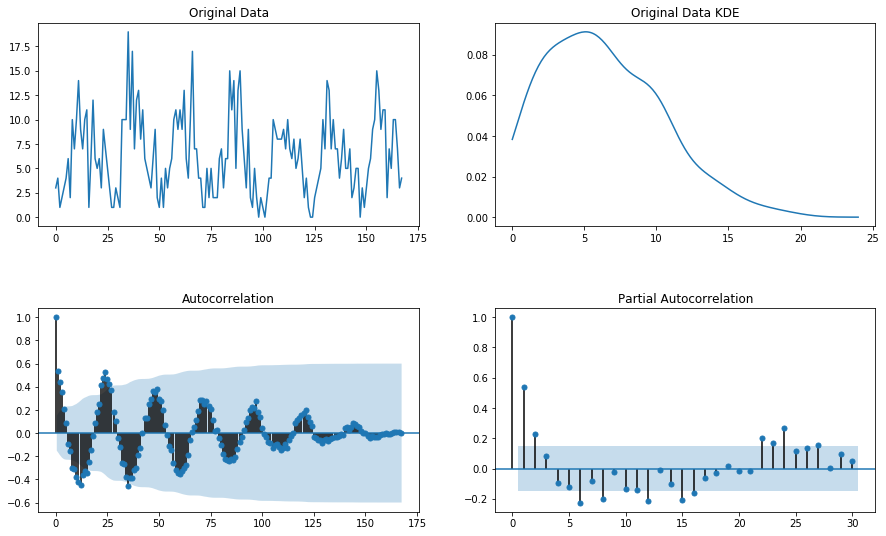

Test for Stationarity:
ADF Statistic: -6.165535
p-value: 0.000000


In [43]:
# View the Autocorrelation and Partial Autocorrelation plots and identify the points of stationarity
X = np.array(y_Phone)
fig, ax = plt.subplots(2,2, figsize=(15,9), gridspec_kw = {'wspace':0.2, 'hspace':0.4})

ax[0,0].plot(X)
ax[0,0].set_title('Original Data')

density = gaussian_kde(X)
xs = np.linspace(0,24,240)
ax[0,1].plot(xs,density(xs))
ax[0,1].set_title('Original Data KDE')

sm.graphics.tsa.plot_acf(X, lags=167, ax=ax[1,0])
sm.graphics.tsa.plot_pacf(X, lags=30, ax=ax[1,1])

plt.show() 

result = adfuller(X)
print('Test for Stationarity:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ACF shows the correlation of the series with itself at different lags <br>
PACF shows the amount of autocorrelation at lag k that is not explained by lower-order autocorrelations

## Check if the data is Stationary 

C:\Users\John\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



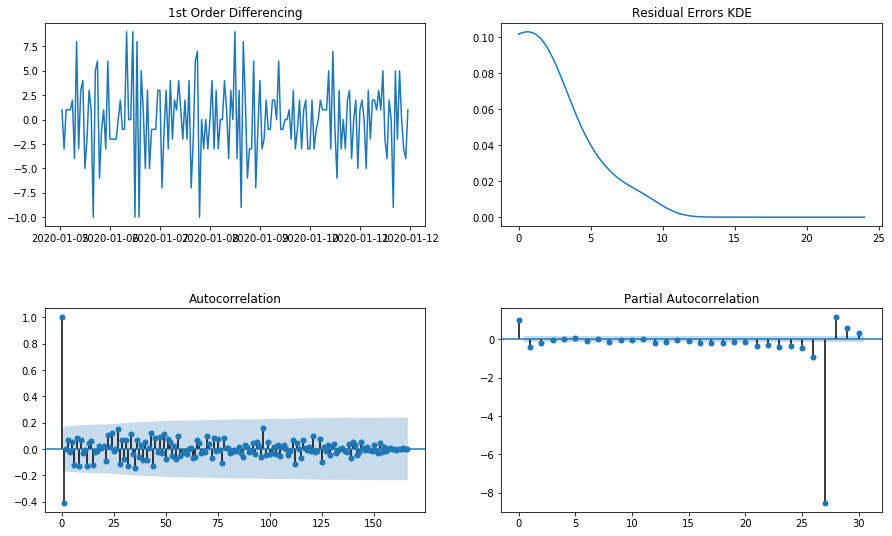

In [44]:
# View the Autocorrelation and Partial Autocorrelation plots and identify the points of stationarity
fig, ax = plt.subplots(2,2, figsize=(15,9), gridspec_kw = {'wspace':0.2, 'hspace':0.4})

ax[0,0].plot(dfweek['Total Phone'].diff())
ax[0,0].set_title('1st Order Differencing')

density = gaussian_kde(dfweek['Total Phone'].diff().dropna())
xs = np.linspace(0,24,240)
ax[0,1].plot(xs,density(xs))
ax[0,1].set_title('Residual Errors KDE')

sm.graphics.tsa.plot_acf(dfweek['Total Phone'].diff().dropna(), lags=166, ax=ax[1,0])
sm.graphics.tsa.plot_pacf(dfweek['Total Phone'].diff().dropna(), lags=30, ax=ax[1,1])

plt.show() 

C:\Users\John\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



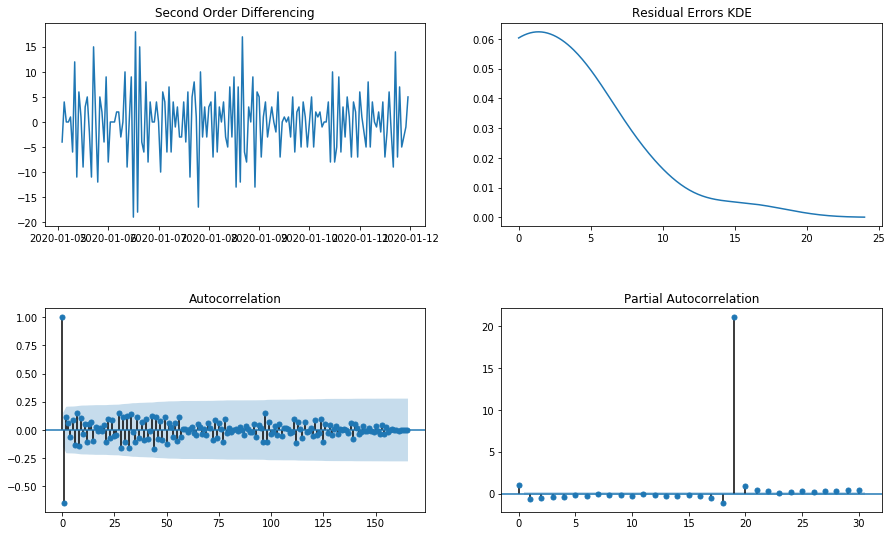

In [45]:
# View the Autocorrelation and Partial Autocorrelation plots and identify the points of stationarity
fig, ax = plt.subplots(2,2, figsize=(15,9), gridspec_kw = {'wspace':0.2, 'hspace':0.4})

ax[0,0].plot(dfweek['Total Phone'].diff().diff())
ax[0,0].set_title('Second Order Differencing')

density = gaussian_kde(dfweek['Total Phone'].diff().diff().dropna())
xs = np.linspace(0,24,240)
ax[0,1].plot(xs,density(xs))
ax[0,1].set_title('Residual Errors KDE')

sm.graphics.tsa.plot_acf(dfweek['Total Phone'].diff().diff().dropna(), lags=165, ax=ax[1,0])
sm.graphics.tsa.plot_pacf(dfweek['Total Phone'].diff().diff().dropna(), lags=30, ax=ax[1,1])

plt.show() 

In [46]:
# Check for lags above the significance level

# Check if a Seasonal ARIMA is Applicable 

In [47]:
# Observe the suggested ARIMA fit and use the information to tune the parameters accordingly
# Attempt to create a fit for the ARIMA model and consider options
# auto_arima_stepwise = pm.auto_arima(X, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
auto_arima_stepwise = pm.auto_arima(X, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
auto_arima_stepwise.summary() # Print the summary and see what the summary suggests. 


Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=857.315, BIC=872.565, Time=3.220 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=1049.186, BIC=1055.286, Time=0.152 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=849.958, BIC=862.157, Time=1.522 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=884.019, BIC=896.218, Time=6.260 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=1047.277, BIC=1050.327, Time=0.100 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=969.090, BIC=978.239, Time=0.379 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 12) (constant=True); AIC=847.726, BIC=862.975, Time=2.662 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 1, 12) (constant=True); AIC=835.130, BIC=853.429, Time=18.706 seconds
Near non-inverti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                  168
Model:             SARIMAX(1, 1, [1, 2], 12)   Log Likelihood                -408.263
Date:                       Thu, 04 Mar 2021   AIC                            826.526
Time:                               20:22:19   BIC                            841.775
Sample:                                    0   HQIC                           832.719
                                       - 168                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1097      0.140     -0.784      0.433      -0.384       0.165
ar.S.L12      -0.9902      0.017    -59.220      0.000      -1.023      -0.957
ma.S.L12      -0.0059      0.155     -0.038      0.970      -0.310       0.299
ma.S.L24      -0.7308      0.136     -5.364      0.000      -0.998      -0.464
sigma2         8.7458      1.146      7.631      0.000       6.500      10.992
===================================================================================
Ljung-Box (Q):                       37.81   Jarque-Bera (JB):                 4.65
Prob(Q):                              0.57   Prob(JB):                         0.10
Heteroskedasticity (H):               0.64   Skew:                             0.36
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
class arimaMaker:    
    def __init__(self,num_prediction_days,p,d,q,data):
        self.logger = logging.getLogger('arimaMaker')
        # Select how many days of the week predictions will be made on
        self.num_days = num_prediction_days # Predictions will be made on 3 days 
    
        if self.num_days <= 3:
        # Convert selection to a positional index in order to make the test train split 
            index_limit = len(data) - len(df['Hour'].unique())*self.num_days 

        # Implement the test train split by plugging in the specified index limit 
        # This sets the cieling index for train and the floor index for test
            train, self.test = X[:index_limit], X[index_limit:] 
            
        else:
            index_limit = len(data) - len(df['Hour'].unique())*(7-self.num_days)
            train, self.test = X[index_limit:], X[:index_limit]
            

        self.history = [x for x in train]                  # Declares the history as the "training set"
        self.predictions = list()                          # Declares a list for the predictions to be stored in
    
        self.p = p
        self.d = d
        self.q = q
        self.DOW = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
        self.residuals = None 
        self.logger.info('creating an instance of arimaMaker') 
        
    def train(self):
        self.logger.info('training model')
        for t in range(len(self.test)): 

            model = ARIMA(self.history, order=(self.p,self.d,self.q))      # ARIMA function
            model_fit1 = model.fit(disp=0)                   
            self.residuals = model_fit1.resid
            output = model_fit1.forecast()
            yhat = output[0]
            self.predictions.append(yhat)                   # Appended array of the output or "predictions"
            obs = self.test[t]
            self.history.append(obs)                        # Appended array of the history or "training set"                    
            #print('predicted=%f, expected=%f' % (yhat, obs))
        self.logger.info('model created')
        
    def plotter(self):
        fig, ax = plt.subplots(2,2, figsize=(15,9), gridspec_kw = {'wspace':0.2, 'hspace':0.4})

        ax[0,0].plot(self.residuals)
        ax[0,0].set_title('Stationarized Data')

        density = gaussian_kde(self.residuals)
        xs = np.linspace(0,24,240)
        ax[0,1].plot(xs,density(xs))
        ax[0,1].set_title('Residual Errors KDE')

        sm.graphics.tsa.plot_acf(self.residuals, lags=160, ax=ax[1,0])
        sm.graphics.tsa.plot_pacf(self.residuals, lags=30, ax=ax[1,1])

        plt.show() 

        # Create a plot comparing the test and training data results 
        fig, ax1 = plt.subplots(1,1, figsize=(15,5))
        ax1.plot(self.test[:-1], color='blue', lw=2, label='Test Data')
        ax1.plot(self.predictions[1:], color='red', lw=2, label='Predictions')

        # Label and format plot 
        ax1.set_ylabel('Hourly Call Volume',fontsize=22)
        ax1.set_title('ARIMA Model Comparison',fontsize=24)

        ax1.margins(x=0) # Removes gaps between x-ticks
        ax1.grid(True, color='k', alpha=1)
        ax1.legend(prop={'size': 12},shadow=True) 

        # Make recurrent list for the time labels
        xticks_Phone = np.arange(0,len(self.test),6) # Time label Positional markers
        extended_time_labels = duplicate([' 00:00',' 06:00',' 12:00',' 18:00'],self.num_days) # Recurrent list of times to label each day

        # Format the x and y-tick labels 
        plt.xticks(xticks_Phone, extended_time_labels, rotation=45, fontsize=17, ha='right', rotation_mode='anchor') #x-axis tick marks
        plt.yticks(fontsize=20)

        # Create a second x-axis for adding the DOW labels  
        ax2 = ax1.twiny()

        # Label and format second axis
        xticks_DOW = np.arange(12,len(self.test),24) # DOW label positional markers
        ax2.set_xticks(xticks_DOW)
        
        if self.num_days <= 3:    
            ax2.set_xticklabels(self.DOW[len(self.DOW)-self.num_days:])
        else:
            ax2.set_xticklabels(self.DOW[:self.num_days])
        ax2.tick_params(axis='x', labelsize=20, color='w')

        # Set the position of the second axis                 
        ax2.xaxis.set_ticks_position('bottom') 
        ax2.xaxis.set_label_position('bottom') 
        ax2.spines['bottom'].set_position(('outward',70)) 
        ax2.spines['bottom'].set_color('w') # Hide second x-axis
        plt.setp(ax2.get_xticklabels(), color='k') # Set DOW label color 
        ax2.set_xlim(ax1.get_xlim())    
        
    def stats(self):
        # Calculate the stats 
        error = mean_squared_error(self.test[:len(self.test)-1], self.predictions[1:])
        square_error = math.sqrt(error)
        MAPE = mean_absolute_error(self.test[:len(self.test)-1], self.predictions[1:])
        r2 = r2_score(self.test[:len(self.test)-1], self.predictions[1:])
        
        # Report the stats 
        print('Trained On: '+str("{:0.1f}".format((len(self.DOW)-self.num_days)*100/len(self.DOW)))+' %'+
              'Tested On: '+str("{:0.1f}".format(self.num_days*100/len(self.DOW)))+' %')
        print('\n')
        print('Test MSE: %.3f' % error)
        print('Test RSME: %.3f' % square_error)
        print('Test MAPE: %.3f' % MAPE)
        print('Test R\u00B2: %.3f' % r2)
        self.logger.info('model stats calculated')
        
    def train_and_display(self):
        self.train()
        self.plotter()
        self.stats()

# ARIMA Test and Predictions - (Total Phone Demand) 
## Holt's Linear Method ARIMA(0,2,2) - Train on Sun-Wed and Predict on Thurs-Sat

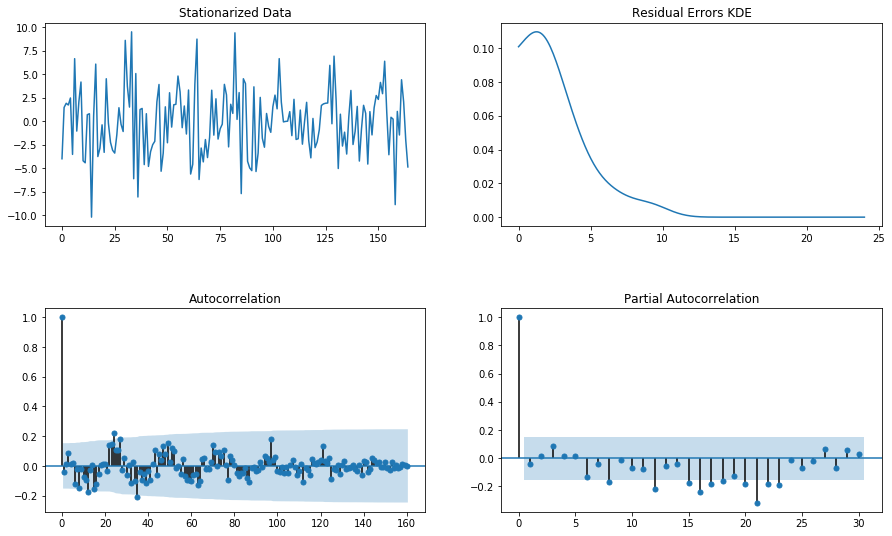

Trained On: 57.1 %Tested On: 42.9 %


Test MSE: 1.824
Test RSME: 1.351
Test MAPE: 1.061
Test R²: 0.859


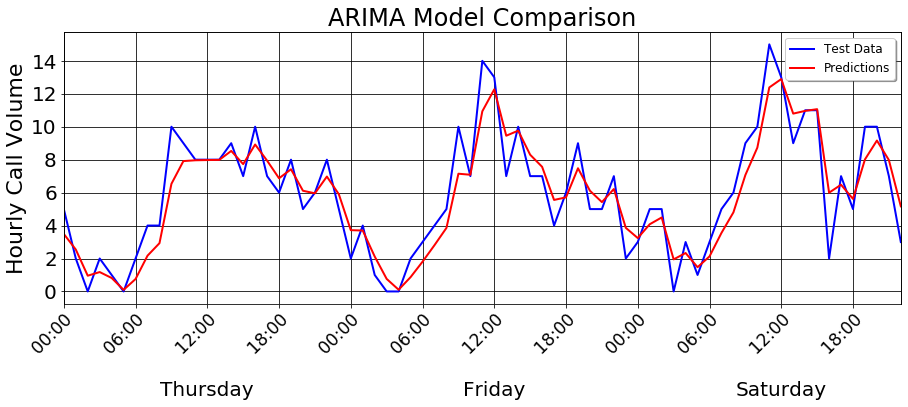

In [49]:
Arima = arimaMaker(num_prediction_days=3, p=0, d=2, q=2, data=y_Phone)
Arima.train_and_display()

## Holt's Linear Method - ARIMA(0,2,2) - Train on Thurs-Sat and Predict on Sun-Wed

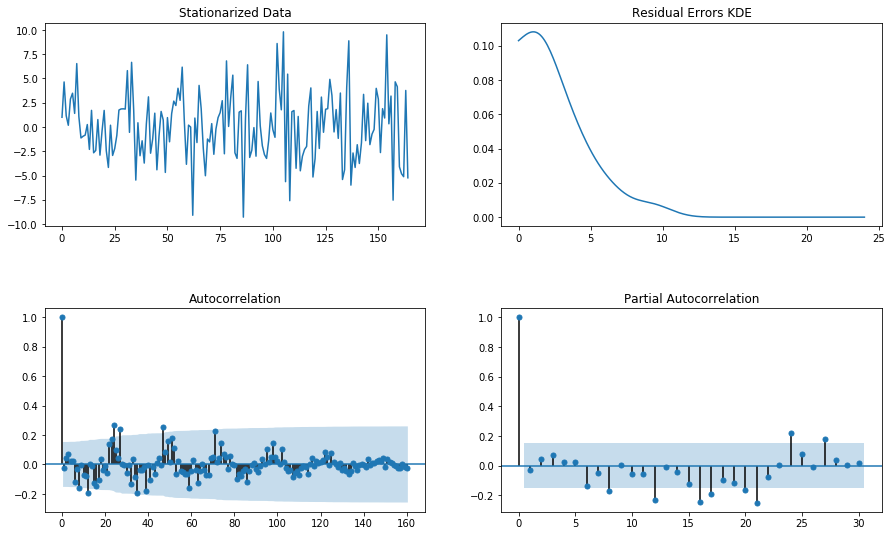

Trained On: 42.9 %Tested On: 57.1 %


Test MSE: 2.432
Test RSME: 1.560
Test MAPE: 1.256
Test R²: 0.864


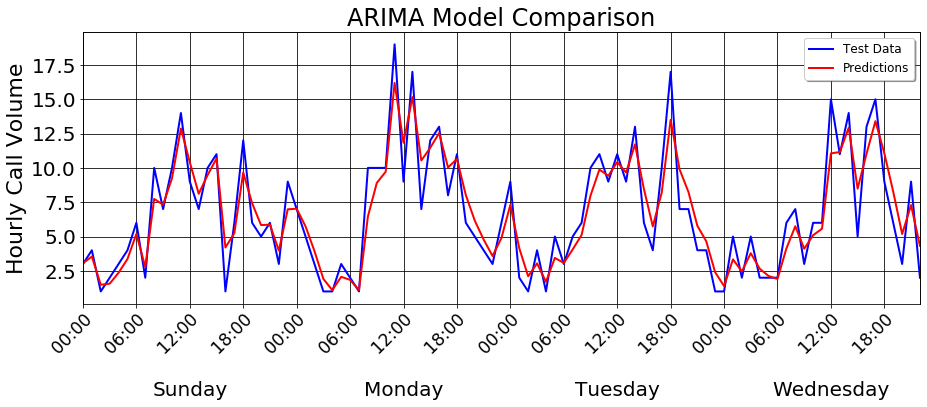

In [50]:
Arima = arimaMaker(num_prediction_days=4, p=0, d=2, q=2, data=y_Phone)
Arima.train_and_display()

## Two ARIMA tests were performed to evaluate the nature and predictibility of the data

**Two Out-of-Time Cross Validation test were performed:**
    
    1) Train on Sun-Wed and Predict on Thurs-Sat
    2) Train on Thurs-Sat and Predict on Sun-Wed

**Holt's Linear Method - ARIMA(0,2,2)**

    • Linear Exponential Smoothing performed well on both out-of-time cross validation sets.
    • This model implements two orders of differencing and 2 time lags for the error terms for the MA component.
    • Correlation coefficient of the predictions relative to the test data was greater than 0.85
    • Almost all of the lags in the ACF and PACF fall below or near the significance level
    • For both cases the predictions assume the general shape of the test data

**Models possible for all days of the week using this method**
    
   **Note:** Several other ARIMA configurations were attempted <br>
   
    • Linear Exponential Smoothing provided the most robust prediction results
    • Changing the order of the MA term from 2 to 1 provides predictions which are almost identical to the test data
    • This model undershot some of the lower values to a nominal degree
  

# LSTM Forecasting with Batches - (Total Phone Demand) 

Train Score: 5.06 RMSE
Test Score: 4.63 RMSE


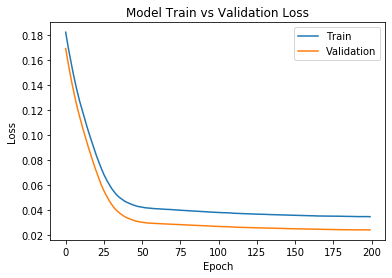

In [51]:
# Load the dataset
dataframe = dfweek[['Total Phone']]
dataset = dataframe.astype('float32')
np.random.seed(0)

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1
look_back = 1
dropout_rate = 0
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(1))
model.add(Dropout(dropout_rate))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), verbose=0)

# make predictions
trainPredict = model.predict(trainX)
trainPredict = trainPredict - min(trainPredict)
testPredict = model.predict(testX)
testPredict = testPredict - min(testPredict)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate and display the stats (MSE)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Shift the train and test predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:] = testPredict

# Compare the train and validation loss curves  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

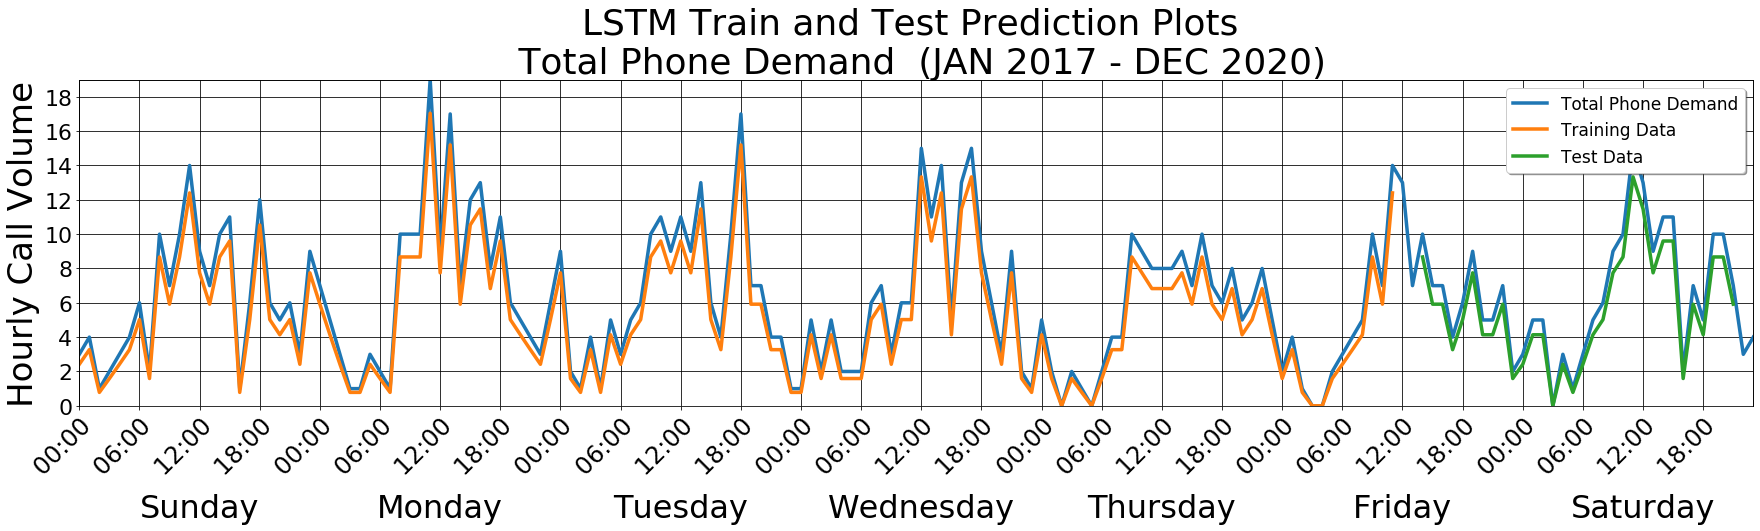

In [52]:
# Create a plot displaying the Total Phone Demand (baseline) and train and test predictions from the LSTM model
fig1, ax1 = plt.subplots(1, 1, figsize=(30,6), gridspec_kw = {'wspace':0, 'hspace':1}) #Establish a subplot

# Plot Total Phone Demand, Training Data and Test Data 
ax1.plot(scaler.inverse_transform(dataset), lw=3.5, label='Total Phone Demand')
ax1.plot(trainPredictPlot[1:]*2, lw=3.5, label='Training Data')
ax1.plot(testPredictPlot[1:]*2, lw=3.5, label='Test Data')

# Label and format plot
ax1.set_title('LSTM Train and Test Prediction Plots \n Total Phone Demand '+' '+'('
              +str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+' '+'-'+' '
              +str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')',fontsize=36)
ax1.set_ylabel('Hourly Call Volume', fontsize=34)

ax1.yaxis.set_major_locator(MaxNLocator(integer=True)) # Converts y-axis to integers 
ax1.margins(x=0) # Removes gaps between x-ticks
ax1.margins(y=0) # Removes gaps between y-ticks
ax1.grid(True, color='k', alpha=1)
ax1.legend(prop={'size': 17},shadow=True)

# Make recurrent list for the time labels 
xticks_Phone = np.arange(0,len(y_Phone),6) # Time label Positional markers
extended_time_labels = duplicate(time_labels,len(DOW)) # Recurrent list of times to label each day

# Format the x and y-tick labels 
plt.xticks(xticks_Phone, extended_time_labels, rotation=45, fontsize=24, ha='right', rotation_mode='anchor') #x-axis tick marks
plt.yticks(fontsize=22)

# Create a second x-axis for adding the DOW labels  
ax2 = ax1.twiny()

# Label and format second axis
xticks_DOW = np.arange(12,len(y_Phone),24) # DOW label positional markers
ax2.set_xticks(xticks_DOW)
ax2.set_xticklabels(DOW)
ax2.tick_params(axis='x', labelsize=32, color='w')

# Set the position of the second axis                 
ax2.xaxis.set_ticks_position('bottom') 
ax2.xaxis.set_label_position('bottom') 
ax2.spines['bottom'].set_position(('outward', 80)) 
ax2.spines['bottom'].set_color('w') # Hide second x-axis
plt.setp(ax2.get_xticklabels(), color='k') # Set DOW label color 
ax2.set_xlim(ax1.get_xlim())
plt.show()

### LSTM with Memory Between Batches Model Parameters

****

**Train size:** First 80% of data <br>
**Test size:** Remaining 20% of data <br>

****

**Number of nodes:** 6 <br>
**Number of dense layers:** 1 <br>
**Number of epochs:** 200 <br>

****

# Explore the potential for more Phone Demand Patterns with Gaussian KDE

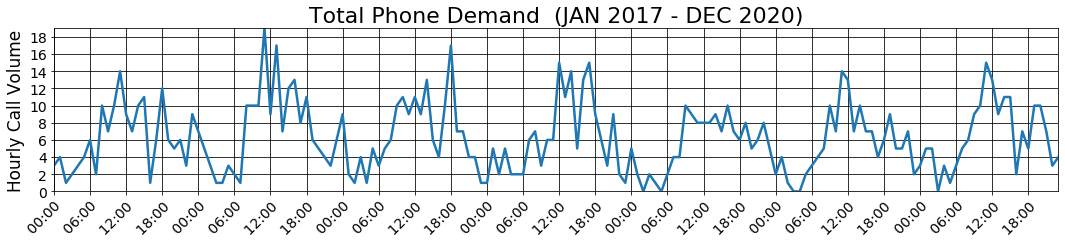

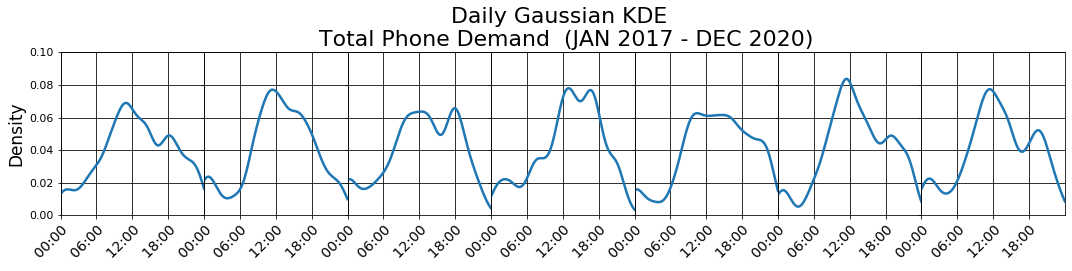

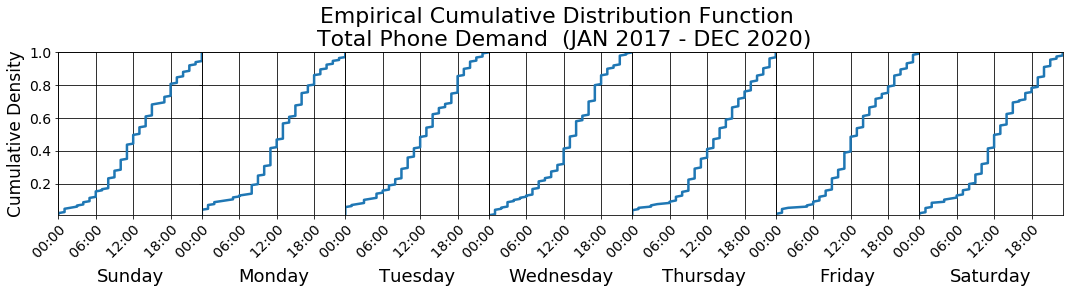

In [53]:
# Explore the Total Phone demand in different conformations to gain more insight on waves and windows of phone demand
# Generate an estimated probability density function for each day
# Find the local maxima within each KDE plot to identify the primary and secondary times

# Create a plot to dispaly the Total Phone Demand as reference to the KDE and ECDF plots 
fig1, ax1 = plt.subplots(1, 1, figsize=(18,3), gridspec_kw = {'wspace':0, 'hspace':1}) # Establish a subplot

# Take the outline from the Total Phone Demand Hourly Call Volume histogram and plot it as a function of time
ax1.plot(y_Phone, lw=2.5)

# Label and format plot
ax1.set_title('Total Phone Demand '+' '+'('+str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+' '+'-'+' '+
              str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')',fontsize=22)
ax1.set_ylabel('Hourly Call Volume', fontsize=17)

ax1.yaxis.set_major_locator(MaxNLocator(integer=True)) # Converts y-axis to integers
ax1.margins(x=0) # Removes gaps between x-ticks
ax1.margins(y=0) # Removes gaps between y-ticks
ax1.grid(True, color='k')
plt.xticks(xticks_Phone, extended_time_labels, rotation=45, fontsize=14, ha='right', rotation_mode='anchor') # x-axis tick marks
plt.yticks(fontsize=14) 
plt.show()

# Declare the two remaining figures as subplots outside 
fig2, ax2 = plt.subplots(1, 7, figsize=(18,3), gridspec_kw = {'wspace':0, 'hspace':1}, sharey='row') # Establish a subplot
fig3, ax3 = plt.subplots(1, 7, figsize=(18,3), gridspec_kw = {'wspace':0, 'hspace':1}, sharey=True) # Establish a subplot

appended_kde = [] # List of the KDE results  
KDE_index = [] # List of the local maxima from each KDE plot    
KDE_peak_diff = [] # # Store the hourly time difference between primary and secondary peaks
KDE_table_data = [] # Peaks from the KDE data in format for Dataframe  

for l in range(len(DOW)):
    # Create a Gaussian KDE plot - Estimate the Probability Density Function for each day  
    density = gaussian_kde(Hours_Phone[l])
    xs = np.linspace(0,24,240)
    density.covariance_factor = lambda : 0.22
    density._compute_covariance()
    appended_kde.append(density(xs))
    
    ax2[l].plot(xs, density(xs), lw=2.5)
    ax2[3].set_title('Daily Gaussian KDE \n Total Phone Demand '+' '+'('+str.upper(df['Month Name'][0])+' '
                     +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
                     +str(year_range_all[-1])+')',fontsize=22)
    ax2[0].set_ylabel('Density', fontsize=17)
    ax2[0].tick_params(axis='y', labelsize=11)
    ax2[0].set_ylim([0,0.1]) # y-axis upper and lower bounds
    
    ax2[l].set_xticks([0,6,12,18])
    ax2[l].set_xticklabels(time_labels, rotation=45, fontsize=14, ha='right', rotation_mode='anchor')
    
    ax2[l].margins(x=0) # Removes gaps between x-ticks
    ax2[l].margins(y=0) # Removes gaps between y-ticks
    ax2[l].grid(True, color='k')
    
    # Create a Empirical Cumulative Distribution Function - Step function to view the cumulative probability 
    ecdf = ECDF(Hours_Phone[l])
    ax3[l].plot(ecdf.x, ecdf.y, lw=2.5, label='ECDF')
    
    ax3[l].set_xlabel(DOW[l], fontsize=18) # Passes index j sets day of the week as the x-lablel
    ax3[0].set_ylabel('Cumulative Density', fontsize=17)
    ax3[3].set_title('Empirical Cumulative Distribution Function \n Total Phone Demand '+' '+'('
                     +str.upper(df['Month Name'][0])+' '+str(year_range_all[0])+' '+'-'+' '
                     +str.upper(df['Month Name'][-1])+' '+str(year_range_all[-1])+')',fontsize=22)
    ax3[0].tick_params(axis='y', labelsize=14)
    plt.sca(ax3[l]) # Updatedes current figure to the parent of ax
    ax3[l].set_xticks(time_ticks)
    ax3[l].set_xticklabels(time_labels, rotation=45, fontsize=14, ha='right', rotation_mode='anchor')
    
    ax3[l].margins(x=0) # Removes gaps between x-ticks
    ax3[l].margins(y=0) # Removes gaps between y-ticks
    ax3[l].grid(True, color='k')
plt.show()

for i in range(len(DOW)):
    # Find the local maxima of each KDE plot 
    KDE_index.append(argrelextrema(appended_kde[i], np.greater))
    
    # Append the hourly time difference between primary and secondary peaks
    KDE_peak_diff.append(abs(round(int(KDE_index[i][0][-2])/10)-round(int(KDE_index[i][0][-1])/10)))
    
    if i == 1 or i ==2: # For Monday and Tuesday, switch the indexing order of the saved data - see comments for more info 
        KDE_table_data.append([str(round(int(KDE_index[i][0][-1])/10))+':00', str(round(int(KDE_index[i][0][-2])/10))+':00', 
                               KDE_peak_diff[i]])
   
    else: # Save the first and second indicies as the primary and secondary peaks respectively  
        KDE_table_data.append([str(round(int(KDE_index[i][0][-2])/10))+':00', str(round(int(KDE_index[i][0][-1])/10))+':00', 
                               KDE_peak_diff[i]])

header = ['Primary Time', 'Secondary Time', 'Time Window (hrs)'] # Horizontal labels for KDE Dataframe
KDE_stats_df = pd.DataFrame(KDE_table_data, DOW, header) #Dataframe for primary and secondary peaks

In [54]:
print('\n')
print('Table of Total Phone Demand Primary and Secondary KDE Peaks:')
display(KDE_stats_df)
print('\n')
print('Table of Total Phone Demand Primary and Secondary Thresholded Peaks:')
display(peaks_df[['Primary Time','Secondary Time','Time Window (hrs)']])



Table of Total Phone Demand Primary and Secondary KDE Peaks:


Primary Time Secondary Time  Time Window (hrs)
Sunday           11:00          18:00                  7
Monday           11:00           1:00                 10
Tuesday          18:00          12:00                  6
Wednesday        13:00          16:00                  3
Thursday         10:00          15:00                  5
Friday           11:00          19:00                  8
Saturday         11:00          19:00                  8



Table of Total Phone Demand Primary and Secondary Thresholded Peaks:


Primary Time Secondary Time  Time Window (hrs)
Sunday           11:00          18:00                  7
Monday           11:00          16:00                  5
Tuesday          18:00          14:00                  4
Wednesday        12:00          17:00                  5
Thursday          9:00          16:00                  7
Friday           11:00          19:00                  8
Saturday         11:00          19:00                  8

## Gaussian KDE is an alternative estimate of Total Phone Demand daily Time Windows 

Applying the Gaussian function adequately smooths the original phone demand data while retaining pertinent information with respect to time. The local maxima with the two greatest densities were found for each estimated probability density function and labels for the primary and secondary peaks were made accordingly.

The Thresholding Method was used as a baseline for the true results in order to compare and assess the accuracy of the KDE models. The following discoveries were made:

• The local maxima extracted from the KDE models identified the peak times for Friday, Saturday and Sunday identically to the Thresholding Method. The peaks for these graphs were clearly defined for the local maxima to be found accurately.

• The primary and secondary times for Wednesday and Thursday were both 1 hour off from the expected times. When comparing the primary peaks from raw data to the KDE plots for these days however, the discrepancy is reasonable due to the proximity of the primary and secondary peaks. Based on the lambda value, the general behavior of the smoothing function, the peaks were generalized and shifted over by 1 hour. The secondary time for Tuesday faced the same issue but the secondary time was marked 2 hours earlier than the expected time.  

• The KDE model completely failed at identifying the secondary peak for Monday. In the vicinity of 1600 hrs (the true time of the secondary peak), no clear separation exists relative to the primary peak at 1100 hrs. The algorithm picked up the local maxima at 0100 hrs and assigned it as the secondary peak instead.

• Lowering the value of lambda would generalize the smooth less and allow us to find the missing peak. This would come at the expense of revealing unwanted data and misidentifying peaks in some of the other KDE plots. 

• Considering the tradeoff, choosing the lambda of 0.22 was the most conservative approach. 

• Displaying the ECDF plots provides the portion of observations of the measured variable that are equal or less than the specified value. A higher change in cumulative density with respect to a unit of time corresponds to a higher density of call volume - the opposite relation is also true.    

# Gaussian KDE  Generalized over all days - (Total Phone Demand)

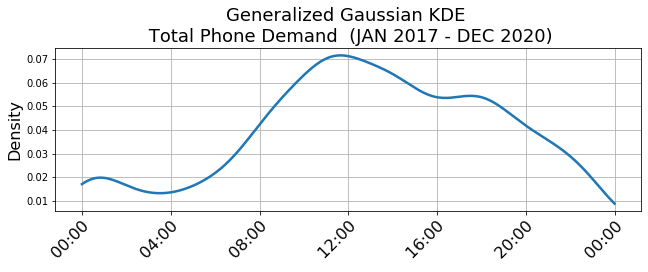

In [55]:
# Generate an estimated probability density function for all instances of phone demand - 'Generalized KDE'
# Pool together all instances of phone demand
Hours_Phone_All = Hours_Phone[0]+Hours_Phone[1]+Hours_Phone[2]+Hours_Phone[3]+Hours_Phone[4]+Hours_Phone[5]+Hours_Phone[6]

# Create a Gaussian KDE plot - Estimate the Probability Density Function for all instances of phone demand
density = gaussian_kde(Hours_Phone_All)
xs = np.linspace(0,24,240)
density.covariance_factor = lambda : 0.2
density._compute_covariance()


fig1, ax1 = plt.subplots(1, 1, figsize=(10.5,3), gridspec_kw = {'wspace':0, 'hspace':1}) # Establish a subplot
ax1.plot(xs, density(xs), lw=2.5)

# Format and label plot 
ax1.set_title('Generalized Gaussian KDE \n Total Phone Demand '+' '+'('+str.upper(df['Month Name'][0])+' '
              +str(year_range_all[0])+' '+'-'+' '+str.upper(df['Month Name'][-1])+' '
              +str(year_range_all[-1])+')',fontsize=18)
ax1.set_ylabel('Density', fontsize=16)
plt.xticks([0, 4, 8, 12, 16, 20, 24], [' 00:00',' 04:00',' 08:00',' 12:00',' 16:00',' 20:00','00:00'],
           rotation=45, fontsize=16, ha='right', rotation_mode='anchor') #x-axis tick marks
ax1.grid()

General_KDE_index = argrelextrema(density(xs), np.greater) # Find the local maxima of the Generalized KDE  
primary_KDE_time_avg = round(General_KDE_index[0][-2]/10*2)/2 # Primay time - local maxima with greatest value
secondary_KDE_time_avg = round(General_KDE_index[0][-1]/10*2)/2 # Secondary time - local maxima with 2nd greatest value  

## The Generalized KDE is an 'average' of the Daily KDE's 

Including all of the data into one model has an averaging effect on the result and returns a generalized pattern. The two greatest local maxima correspond to the primary peak at 1130 hrs and the secondary peak at 1730 hrs respectively. 

    • The results are similar to taking averages of the thresholded primary and secondary peaks - (the true results). 
    
    • For more info summary comparing the results of the Generalized KDE and Prophet models 
    against the Thresholding Method, consult the final table titled: 'Model Comparison of Peak 
    Phone Demand Times and Time Windows'.  

# Prophet Forecasting Model - (Total Phone Demand)

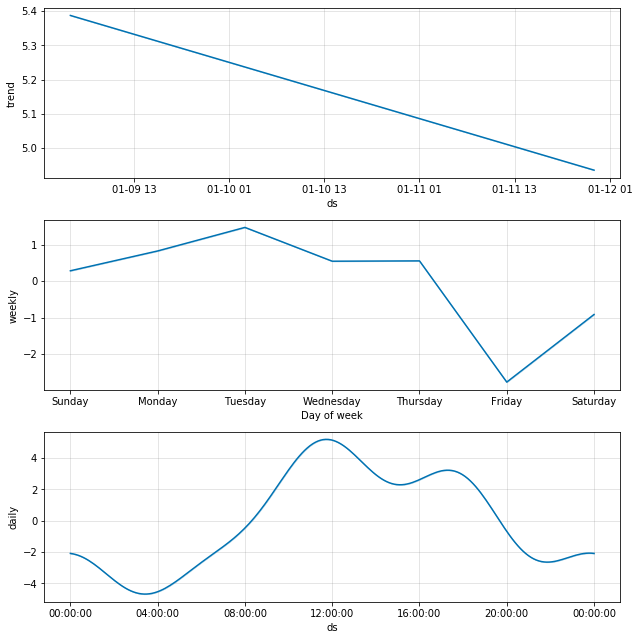

In [56]:
# Use the Prophet Model to assess Weekly and Daily Trends. Compare model to the actual results. 
# Set up the time axis and split date 
dfweek['Datetime'] = dfweek.index # Assign the DataFrame index its own column labeled 'Datetime'
split_date = '2020-01-09 04:00:00' # Split date for the test train split

# Apply the split date to perform a test train split
train_data = dfweek.iloc[dfweek.index <= split_date].copy()
test_data = dfweek.iloc[dfweek.index > split_date].copy()

# Assign the parameters for the Prophet model 
model = Prophet(yearly_seasonality=False,weekly_seasonality=True) # Establish the model 
model.fit(train_data.reset_index(drop=True).rename(columns={'Datetime':'ds','Total Phone':'y'})) # Train the model
predictions = model.predict(df=test_data.reset_index(drop=True).rename(columns={'Datetime':'ds'})) # Test the model 

py.init_notebook_mode()
# Plot the model results
py.iplot(plot_plotly(model, predictions))

# Look at the model components
fig = model.plot_components(predictions)

## Analysis of Prophet Model Components and Predictions 

Prophet Model Weekly Trend Analysis:

    • The aggregate Daily Call Volume serves as the true weekly trend for call volume totals. The busiest day was Monday and the least active day was Friday. (Consult figure from Daily Call Volume Section)
    
    • The Prophet Model describes the same trend except it appears the busiest and least active days have shifted to Tuesday and Friday respectively. This is not true however, because the tick marks represent the start of the labeled day and the conclusion of the previous one.
    
    • In conclusion the Prophet Model preserves the true weekly trend.
    
Prophet Model Daily Trend Analysis:
 
     • The Prophet Model Daily Trend is more robust than the Gaussian KDE Models because there are three clearly defined 
     waves of demand with no sign of discontinuity between the transition at midnight. The Daily and Generalized KDE Models 
     suffer from discontinuity issues because the calculations do not take into account information from the past. 
     
     • The first two waves on the Prophet Model are the primary and secondary peaks of demand. The third wave is show around 
     23:00 hrs but has not been discussed until now because it is a harder feature to consistently identify with the KDE
     Models due to the aforementioned discontinuity issue.  
     
     • Comparing this model to the Generalized KDE plot, we can see that the peaks and valleys are more defined. It is 
     unknown if the Prophet model also utilizes a density function but the results portray the shape of the data better than  the KDE Models.
     
     • In conclusion, the Prophet Model generalizes the daily trend better than the Generalized KDE Model, but is not 
     capable of picking up the subtle differences in peak demand times like the Thresholding Method or Daily KDE Models can. 
     
Prophet Model Predictions Analysis:     

    • This model was trained on Sunday-Wednesday and predictions were made on Thursday-Saturday. The predictions are simply a superposition of the Weekly and Daily trends and reveal intuitive results - the Daily trend with influences in the 
    amplitude from the weekly trend. 
    
    • Note that the primary and secondary peak times have each shifted by 30 mins to 1200 and 1800 hrs respectively. This 
    shift forward relative to the Daily trend peak times, is most likely due to influences from the weekly trend component.
    This difference is negligible however, because the forecasted peak times now match the average peak times from the 
    Thresholding Method. 
    
    • To conclude, the Phophet model gives a good general estimate of the Daily trend and can take into account the 
    differences in Daily Call Volume for predictions throughout the week.   

In [57]:
# Create a table comparing the Peak Phone Demand Times and Time Windows for the 2 models against the Thresholding Method:
model_data = [[dec2time(primary_time_avg),
               dec2time(secondary_time_avg), str(int(secondary_time_avg-primary_time_avg))],
              [dec2time(primary_KDE_time_avg),
               dec2time(secondary_KDE_time_avg), str(int(secondary_KDE_time_avg-primary_time_avg))],
               ['11:30','17:30','5']]

header = ['Primary Time','Secondary Time','Time Window (hrs)'] # Horizontal labels  
vert_label = ['Thresholding Method','Generalized KDE Model','Prophet Model'] # Vertical Labels
model_df = pd.DataFrame(model_data, vert_label, header) #Dataframe for primary and secondary peaks

In [58]:
print('Model Comparison of Peak Phone Demand Times and Time Windows')
model_df

Model Comparison of Peak Phone Demand Times and Time Windows


Primary Time Secondary Time Time Window (hrs)
Thresholding Method          12:00          17:00                 5
Generalized KDE Model        11:30          17:30                 5
Prophet Model                11:30          17:30                 5

## The Prophet and Generalized Models perform exceptionally well

Both Models were capable of preserving the Peak Phone Demand Times and Time Windows. Note that the 30 min time difference to the Thresholding Method is negligible. The Primary and Secondary Times calculated from the Thresholding Method are averages and were rounded to the nearest integer instead of down to the exact minute for simplicity. Since staffing is typically a 6 or 8 hour shift per day, being off by a matter of minutes is a reasonable tolerance when the magnitude of demand is based by the hour.  

**Conclusion:** Crew availability will dictate the staffing approach that is used for staffing ambulance members for duty.

• If there is no time preference, staff based on the primary and secondary times from the Thresholding Method or the Generalized KDE Model. Consult the graphs for information on the optimal windows of demand.

• Fine-tune the start time of the shift based on when the density of call volume starts to rise sharply. <br> (Typically 2-3 hours prior to the primary wave of demand)

• Set the end time of the shift 6 or 8 hrs after the start time depending on the shift duration. 

• If the optimal window of demand is shorter than 6 hours, extend the start or end time of the shift to make up the time difference and cover the demand waves. 

• If a simpler staffing approach is desired, use the average primary and secondary times. 